# AI + Earthquake Networks models for Seismicity Analysis in Colombia

This notebook contains the codes needed to process a Seismicity Catalog, contruct Earthquake Networks and create AI models using information from the models to forecast characteristics from the seismicity in a region, specifically in Colombia. 

The catalog used for this analysis has been downloaded from USGS-NEIC (https://www.usgs.gov/programs/earthquake-hazards/lists-maps-and-statistics) for the Colombian region, between latitudes -5 and 13, and longitudes -82 and -66; from 01/January/1973 and 11/October/2023. Accounted events have magnitude higher than 4.0.

The catalog is used to create earthquake networks from a cubic grid constructed for the region, where cells have the same dimensions. Cell size has varied from 10 to 120km to create different earthquake networks.


## Catalog and data loading for processing.

### Data loading, and global variables definition

In [1]:
#import sys
#!{sys.executable} -m pip install imbalanced-learn

In [1]:
%%time
import pandas as pd
import math

#catalogo original
catalogo=pd.read_csv("https://raw.githubusercontent.com/daniel-leon/redessismos/main/Catalogo-con-todo.csv",sep=',',parse_dates=["time"])

#tiempo inicial para analizar el catálogo.
tini=(pd.Timestamp("1973-01-01T00:00:00Z")-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')
#Umbrales espaciales de la región
ltmin=-5
lnmin=-82
ltmax=13
lnmax=-66
#Magnitud de completitud = 4.1. Se toma entonces mmin como 4.05, para tomar todos los sismos con magnitud mayores a este valor.
mmin=4.05

#Parámetro de conversión entre grados y kilometros
gr2km=111

#Dimensiones de la región 
largo=((((ltmax-ltmin)*gr2km)//100)+(1 if ((ltmax-ltmin)*gr2km)%100 > 1 else 0))*100
ancho=((((lnmax-lnmin)*gr2km)//100)+(1 if ((lnmax-lnmin)*gr2km)%100 > 1 else 0))*100

catalogo=catalogo.drop(columns=["Unnamed: 0"])

CPU times: user 1.35 s, sys: 758 ms, total: 2.11 s
Wall time: 4.23 s


In [2]:
catalogo.head()

time  latitude  longitude  depth  mag    epochs  \
0 1973-01-05 00:39:48.200000+00:00     0.683    -80.018   36.0  4.7  95042388   
1 1973-01-07 01:04:57.200000+00:00     6.856    -73.074  160.0  5.1  95216697   
2 1973-01-11 06:50:51.800000+00:00    12.174    -76.865   33.0  4.5  95583051   
3 1973-01-11 21:03:48.600000+00:00     6.839    -72.926  156.0  4.2  95634228   
4 1973-01-13 07:47:27.800000+00:00    -0.459    -77.957   25.0  4.4  95759247   

        energia  DTsegs    DTdays  energialog  ...  celda102  celda104  \
0  7.079458e+11       0  0.000000   27.285633  ...       108       106   
1  2.818383e+12  174309  2.017465   28.667184  ...    121339    112334   
2  3.548134e+11  366354  4.240208   26.594858  ...       323       317   
3  1.258925e+11   51177  0.592326   25.558695  ...    121339    112334   
4  2.511886e+11  125019  1.446979   26.249470  ...        75        74   

   celda106  celda108  celda110  celda112  celda114  celda116  celda118  \
0        87        86        84        82        80        79        78   
1    104153     96708     89902     83700     78027     72830     68060   
2       294       289       284       279       257       253       249   
3    104153     96708     89902     83700     78027     72830     68060   
4        72        71        70        69        67        66        65   

   celda120  
0        77  
1     63663  
2       230  
3     63663  
4        64  

[5 rows x 68 columns]

El catálogo tiene información de localización, magnitud, tiempos entre eventos, e identificación de celdas. Del análisis del catálogo, se ha elegido el tamaño de celda 50km. Los identificadores de celda corresponden a redes 3d.

Para facilitar la construcción de redes de sismos con este tamaño de celda, se crean dos dataframes para tamaño de celda 50km, y se hace la comparación entre redes 2d y redes 3d.

In [2]:
%%time

tcel=50

def calculacelda2D(ltmin,lnmin,tmcel,gr2km,ancho,largo,lat,lon):
    idx=ancho/tmcel
    i=int((lat-ltmin)*gr2km/tmcel)
    j=i*idx
    
    k=int((lon-lnmin)*gr2km/tmcel)
    return int(k+j+1)

def calculacelda3D(ltmin,lnmin,tmcel,gr2km,ancho,largo,lat,lon,prof):
    idx=ancho/tmcel
    i=int((lat-ltmin)*gr2km/tmcel)
    j=i*idx
    k=int((lon-lnmin)*gr2km/tmcel)
    #ki=int(i+j+1)
    ki=int(k+j+1)
    
    idp=int(prof/tmcel)
    idy=largo/tmcel
    idxy=idy*idx + 2
    #fidp=int(idp*idp)
    fidp=int(idxy*idxy)*idp

    return ki + fidp

cp2d=[]
cp3d=[]
for i, lin in catalogo.iterrows():
    cp2d.append(calculacelda2D(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"]))
    cp3d.append(calculacelda3D(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"],lin["depth"]))

catalogo.insert(len(catalogo.columns),"celda2d"+str(tcel),cp2d)
catalogo.insert(len(catalogo.columns),"celda3d"+str(tcel),cp3d)


dfceldas2d=pd.DataFrame(cp2d,columns=["celda2D"])
dfceldas3d=pd.DataFrame(cp3d,columns=["celda3D"])


CPU times: user 482 ms, sys: 3.54 ms, total: 485 ms
Wall time: 487 ms


# Creacion de redes y vectores de características

## (correr si no se han creado antes y no se tienen archivos de redes generadas previamente.

Se calcula para cada identificador de celda información promedio de energía, latitud, longitud, y total de numero de eventos. Esto luego servirá para anotar los nodos cuando se crean las redes. Se tienen dataframes pivotes para calcular por separado energía, latitud, longitud, profundidad y magnitud por celda; y luego dataframes que compilan la información de cada variable: estos dataframes son <code>dftcelstodo2d</code> y <code>dftcelstodo3d</code>.

In [3]:
%%time

import numpy as np
from scipy import stats
import networkx as nx
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter

#Funciones para crear vectores de características.
def gradprom( g ):
    return sum(dict(g.degree()).values())/len(g.degree())

def disprobgrado(grafo):
    m=nx.adjacency_matrix(grafo)
    v=[0 for i in range (m.shape[0])]
    v1=[0 for i in range (m.shape[0])]
    for i in range (m.shape[1]):
        i1=m[i].todense().sum()
        v[i1-1]=v[i1-1]+1
    tod=sum(v)
    for i in range(m.shape[1]):
        v1[i]=v[i]/tod
    return v1

def dentropy(v):
    v1=[i*math.log(i) for i in list(filter(lambda x: x>0, v))]
    a=math.log(len(v)-1)
    if a>0:
        s1=-sum(v1)/a
    else:
        s1=-sum(v1)/0.00001
    return s1

def smallworldness(g):
    n=nx.number_of_nodes(g)
    gp=gradprom(g)
    c=nx.average_clustering(g)
    p=nx.average_shortest_path_length(g)
    sw=c*n*np.log(n)/(p*gp*np.log(gp))
    return sw


#información de cada celda, para anotar los nodos.
dftcels2denergia=pd.pivot_table(catalogo,values="energia",index=["celda2d"+str(tcel)],aggfunc={'energia':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels2dlatitud=pd.pivot_table(catalogo,values="latitude",index=["celda2d"+str(tcel)],aggfunc={'latitude':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels2dlongitud=pd.pivot_table(catalogo,values="longitude",index=["celda2d"+str(tcel)],aggfunc={'longitude':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels2dprof=pd.pivot_table(catalogo,values="depth",index=["celda2d"+str(tcel)],aggfunc={'depth':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels2dmag=pd.pivot_table(catalogo,values="mag",index=["celda2d"+str(tcel)],aggfunc={'mag':[np.mean,np.sum,np.median,stats.mode,'count']})

dftcels3denergia=pd.pivot_table(catalogo,values="energia",index=["celda3d"+str(tcel)],aggfunc={'energia':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels3dlatitud=pd.pivot_table(catalogo,values="latitude",index=["celda3d"+str(tcel)],aggfunc={'latitude':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels3dlongitud=pd.pivot_table(catalogo,values="longitude",index=["celda3d"+str(tcel)],aggfunc={'longitude':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels3dprof=pd.pivot_table(catalogo,values="depth",index=["celda3d"+str(tcel)],aggfunc={'depth':[np.mean,np.sum,np.median,stats.mode,'count']})
dftcels3dmag=pd.pivot_table(catalogo,values="mag",index=["celda3d"+str(tcel)],aggfunc={'mag':[np.mean,np.sum,np.median,stats.mode,'count']})

dftcelstodo2d=pd.DataFrame(list(dftcels2dlatitud.index),columns=["celda"])
dftcelstodo2d.insert(len(dftcelstodo2d.columns),"count",dftcels2dlatitud["count"].tolist())
dftcelstodo2d.insert(len(dftcelstodo2d.columns),"energia",dftcels2denergia["mean"].tolist())
dftcelstodo2d.insert(len(dftcelstodo2d.columns),"latitude",dftcels2dlatitud["mean"].tolist())
dftcelstodo2d.insert(len(dftcelstodo2d.columns),"longitude",dftcels2dlongitud["mean"].tolist())
dftcelstodo2d.insert(len(dftcelstodo2d.columns),"depth",dftcels2dprof["mean"].tolist())
dftcelstodo2d.insert(len(dftcelstodo2d.columns),"mag",dftcels2dmag["mean"].tolist())

dftcelstodo3d=pd.DataFrame(list(dftcels3dlatitud.index),columns=["celda"])
dftcelstodo3d.insert(len(dftcelstodo3d.columns),"count",dftcels3dlatitud["count"].tolist())
dftcelstodo3d.insert(len(dftcelstodo3d.columns),"energia",dftcels3denergia["mean"].tolist())
dftcelstodo3d.insert(len(dftcelstodo3d.columns),"latitude",dftcels3dlatitud["mean"].tolist())
dftcelstodo3d.insert(len(dftcelstodo3d.columns),"longitude",dftcels3dlongitud["mean"].tolist())
dftcelstodo3d.insert(len(dftcelstodo3d.columns),"depth",dftcels3dprof["mean"].tolist())
dftcelstodo3d.insert(len(dftcelstodo3d.columns),"mag",dftcels3dmag["mean"].tolist())

#Ahora se crean las redes. Este proceso es largo. Se crean para conjuntos de 10, 50 y 100 eventos.

listaneventos=[10,50,100]

#Diccionarios stellargraph, que pueden usarse en GCN
grafosstellars2dall={}
grafosstellars3dall={}
#Diccionarios networkx, que se pueden usar en RF, SVM y LSTM
redes2d={}
redes3d={}
#Diccionarios de vectores de características de las redes.
dfvecs2d={}
dfvecs3d={}

for neventos in listaneventos:
    print(neventos)
    
    redesnx2d=[]
    redesnx3d=[]

    dfbordes2d=[]   # dataframe con los bordes con los que se construyen las redes en formato stellargraph
    node_datas2d=[] # características de los nodos para stellargraph

    dfbordes3d=[]   # dataframe con los bordes con los que se construyen las redes en formato stellargraph
    node_datas3d=[] # características de los nodos para stellargraph
    
    veccaracs2d=[]
    veccaracs3d=[]
    
    for i in range(len(catalogo)-neventos-1):
        grafotemp2d=nx.Graph()
        grafotemp3d=nx.Graph()

        nod12d=[]
        nod22d=[]
        nod13d=[]
        nod23d=[]

        #se calculan las redes - vértices. Se guardan en variables tipo networkx en grafotemp y
        #en variables tipo pandas dfbordes con vértices, que luego se usa para crear variable stellargraph
        for j in range(neventos-1):
            grafotemp2d.add_edge(dfceldas2d.iloc[i+j]["celda2D"],dfceldas2d.iloc[i+j+1]["celda2D"])
            grafotemp3d.add_edge(dfceldas3d.iloc[i+j]["celda3D"],dfceldas3d.iloc[i+j+1]["celda3D"])
            nod12d.append(dfceldas2d.iloc[i+j]["celda2D"])
            nod22d.append(dfceldas2d.iloc[i+j+1]["celda2D"])
            nod13d.append(dfceldas3d.iloc[i+j]["celda3D"])
            nod23d.append(dfceldas3d.iloc[i+j+1]["celda3D"])

        dfbordes2d.append(pd.DataFrame({"source": nod12d, "target": nod22d}))
        dfbordes3d.append(pd.DataFrame({"source": nod13d, "target": nod23d}))
        
        #se crea diccionario para anotar los nodos en node_datas. Esto se hace para cada tipo de red.

        cl=[] # listado de las celdas
        lt=[] 
        ln=[]
        dp=[]        

        for n in grafotemp2d.nodes:
            dct1=dftcelstodo2d[(dftcelstodo2d['celda']==n)][["latitude","longitude","depth"]].to_dict('records')[0]
            dct1={n:dct1}
            nx.set_node_attributes(grafotemp2d,dct1)
            
            row=dftcelstodo2d[dftcelstodo2d['celda']==n][["latitude","longitude","depth"]]
            cl.append(n)
            lt.append(row["latitude"].values[0])
            ln.append(row["longitude"].values[0])
            dp.append(row["depth"].values[0])
        
            nx.set_node_attributes(grafotemp2d,dct1)
            
        node_datas2d.append(pd.DataFrame({"latitud": lt, "longitud": ln, "prof": dp}, index=cl))

        redesnx2d.append(grafotemp2d)

        cl=[] # listado de las celdas
        lt=[] 
        ln=[]
        dp=[]        

        for n in grafotemp3d.nodes:
            dct1=dftcelstodo3d[(dftcelstodo3d['celda']==n)][["latitude","longitude","depth"]].to_dict('records')[0]
            dct1={n:dct1}
            nx.set_node_attributes(grafotemp3d,dct1)

            row=dftcelstodo3d[dftcelstodo3d['celda']==n][["latitude","longitude","depth"]]
            cl.append(n)
            lt.append(row["latitude"].values[0])
            ln.append(row["longitude"].values[0])
            dp.append(row["depth"].values[0])
        
            nx.set_node_attributes(grafotemp3d,dct1)
        node_datas3d.append(pd.DataFrame({"latitud": lt, "longitud": ln, "prof": dp}, index=cl))

        redesnx3d.append(grafotemp3d)
        
        #Se crea vector de características de cada red networkx.
        energia=0
        for k in range(neventos):
            energia=energia+catalogo.iloc[i+k]["energia"]
        lenergia=np.log(energia)

        clusttemp2d=nx.average_clustering(grafotemp2d)
        clusttemp3d=nx.average_clustering(grafotemp3d)

        #average path length
        pathstemp2d=nx.average_shortest_path_length(grafotemp2d)
        pathstemp3d=nx.average_shortest_path_length(grafotemp3d)

        #numero de bordes
        nedgestemp2d=grafotemp2d.number_of_edges()
        nedgestemp3d=grafotemp3d.number_of_edges()

        #numero de nodos
        nodostemp2d=nx.number_of_nodes(grafotemp2d)
        nodostemp3d=nx.number_of_nodes(grafotemp3d)

        #Grado promedio
        gradstemp2d=gradprom( grafotemp2d )
        gradstemp3d=gradprom( grafotemp3d )

        #distribucion de grado
        prgradtemp2d=disprobgrado(grafotemp2d)
        prgradtemp3d=disprobgrado(grafotemp3d)

        #Entropia
        enttemp2d=dentropy(prgradtemp2d)
        enttemp3d=dentropy(prgradtemp3d)

        #Smallworldness
        smallworldtemp2d=smallworldness(grafotemp2d)
        smallworldtemp3d=smallworldness(grafotemp3d)

        #betweenness centrality
        betweentemp2d=list(nx.betweenness_centrality(grafotemp2d).values())
        mbetweentemp2d=np.mean([float(d) for d in betweentemp2d])
        betweentemp3d=list(nx.betweenness_centrality(grafotemp3d).values())
        mbetweentemp3d=np.mean([float(d) for d in betweentemp3d])

        tinis=catalogo.epochs.values[i]
        tfins=catalogo.epochs.values[i+neventos]
        dtdias=(tfins-tinis)/(60*60*24)
        #dtdias=dtsegs

        sismicidad=energia/dtdias
        lsismicidad=np.log(sismicidad)
        veccaracs2d.append([nodostemp2d,nedgestemp2d,gradstemp2d,clusttemp2d,pathstemp2d,enttemp2d,smallworldtemp2d,mbetweentemp2d,lenergia,dtdias,lsismicidad])
        veccaracs3d.append([nodostemp3d,nedgestemp3d,gradstemp3d,clusttemp3d,pathstemp3d,enttemp3d,smallworldtemp3d,mbetweentemp3d,lenergia,dtdias,lsismicidad])
    
    print("termina neventos ",neventos," - len dfbordes2d: ",len(dfbordes2d)," - len nodedatas2d: ",len(node_datas2d))
    
    grafosstellars2d=[]
    for i in range(len(dfbordes2d)):
        dfbordes2d[i].columns=["source","target"]
        grafosstellars2d.append(StellarGraph(node_datas2d[i],dfbordes2d[i]))
    grafosstellars3d=[]
    for i in range(len(dfbordes3d)):
        dfbordes3d[i].columns=["source","target"]
        grafosstellars3d.append(StellarGraph(node_datas3d[i],dfbordes3d[i]))

    grafosstellars2dall['nev'+str(neventos)]=grafosstellars2d
    grafosstellars3dall['nev'+str(neventos)]=grafosstellars3d

    redes2d['nev'+str(neventos)]=redesnx2d
    redes3d['nev'+str(neventos)]=redesnx3d

    dfvecs2d['nev'+str(neventos)]=pd.DataFrame(veccaracs2d,columns=["nodos","edges","grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"])
    dfvecs3d['nev'+str(neventos)]=pd.DataFrame(veccaracs3d,columns=["nodos","edges","grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"])



2025-01-23 20:42:46.904020: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2025-01-23 20:43:26.237581: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-01-23 20:43:26.865562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-23 20:43:26.866226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 930MX computeCapability: 5.0
coreClock: 0.9015GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 29.80GiB/s
2025-01-23 20:43:26.866400: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2025-01-23 20:43:28.997452: I tensorflow/stream_executor/platf

10
termina neventos  10  - len dfbordes2d:  6251  - len nodedatas2d:  6251
50
termina neventos  50  - len dfbordes2d:  6211  - len nodedatas2d:  6211
100
termina neventos  100  - len dfbordes2d:  6161  - len nodedatas2d:  6161
CPU times: user 57min 34s, sys: 8.02 s, total: 57min 42s
Wall time: 58min 50s


# Carga de redes previamente generadas

Este proceso se hizo antes, aquí se cargan las redes antes creadas y los vectores de características. Las redes se crean en los diccionarios <code>grafosstellars3dall</code>, <code>grafosstellars2dall</code>, <code>redes2d</code> y <code>redes3d</code>; y los vectores en diccionarios de dataframes <code>dfvecs2d</code> y <code>dfvecs3d</code>. Esto toma mas o menos 4 minutos.

In [3]:
%%time

import networkx as nx
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter

listaneventos=[10,50,100]

grafosstellars2dall={}
grafosstellars3dall={}
redes2d={}
redes3d={}
dfvecs2d={}
dfvecs3d={}

for neventos in listaneventos:
    print(neventos)
    redesnx2d=[]
    redesnx3d=[]

    dfbordes2d=[]   # dataframe con los bordes con los que se construyen las redes en formato stellargraph
    node_datas2d=[] # características de los nodos para stellargraph

    dfbordes3d=[]   # dataframe con los bordes con los que se construyen las redes en formato stellargraph
    node_datas3d=[] # características de los nodos para stellargraph
    
    for i in range(len(catalogo)-neventos-1):
        red2d=pd.read_csv("/data/doctorado/redessismos/redesIA/redesstellargraph/bordes/bordes2dn"+str(neventos)+"-i"+str(i)+".csv").drop(columns=["Unnamed: 0"])
        dfbordes2d.append(red2d)
        red3d=pd.read_csv("/data/doctorado/redessismos/redesIA/redesstellargraph/bordes/bordes3dn"+str(neventos)+"-i"+str(i)+".csv").drop(columns=["Unnamed: 0"])
        dfbordes3d.append(red3d)
        redesnx2d.append(nx.from_pandas_edgelist(red2d))
        redesnx3d.append(nx.from_pandas_edgelist(red3d))
        node_datas2d.append(pd.read_csv("/data/doctorado/redessismos/redesIA/redesstellargraph/data/data2dn"+str(neventos)+"-i"+str(i)+".csv",index_col="Unnamed: 0"))
        node_datas3d.append(pd.read_csv("/data/doctorado/redessismos/redesIA/redesstellargraph/data/data3dn"+str(neventos)+"-i"+str(i)+".csv",index_col="Unnamed: 0"))

    grafosstellars2d=[]
    for i in range(len(dfbordes2d)):
        dfbordes2d[i].columns=["source","target"]
        grafosstellars2d.append(StellarGraph(node_datas2d[i],dfbordes2d[i]))
    grafosstellars3d=[]
    for i in range(len(dfbordes3d)):
        dfbordes3d[i].columns=["source","target"]
        grafosstellars3d.append(StellarGraph(node_datas3d[i],dfbordes3d[i]))

    grafosstellars2dall['nev'+str(neventos)]=grafosstellars2d
    grafosstellars3dall['nev'+str(neventos)]=grafosstellars3d

    redes2d['nev'+str(neventos)]=redesnx2d
    redes3d['nev'+str(neventos)]=redesnx3d
    print("termina neventos ",neventos," - len dfbordes2d: ",len(dfbordes2d)," - len nodedatas2d: ",len(node_datas2d))


    dfvecs2d["nev"+str(neventos)]=pd.read_csv("/data/doctorado/redessismos/redesIA/redesstellargraph/veccaracs2dnev"+str(neventos)+".csv")
    dfvecs3d["nev"+str(neventos)]=pd.read_csv("/data/doctorado/redessismos/redesIA/redesstellargraph/veccaracs3dnev"+str(neventos)+".csv")
    

2025-01-24 14:32:52.913241: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2025-01-24 14:33:07.769435: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-01-24 14:33:08.075030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-24 14:33:08.075745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 930MX computeCapability: 5.0
coreClock: 0.9015GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 29.80GiB/s
2025-01-24 14:33:08.075918: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2025-01-24 14:33:08.746204: I tensorflow/stream_executor/platf

10
termina neventos  10  - len dfbordes2d:  6251  - len nodedatas2d:  6251
50
termina neventos  50  - len dfbordes2d:  6211  - len nodedatas2d:  6211
100
termina neventos  100  - len dfbordes2d:  6161  - len nodedatas2d:  6161
CPU times: user 3min, sys: 5.95 s, total: 3min 6s
Wall time: 3min 47s


Se tienen las redes en formato networkx y stellargraph. Networkx se usa para crear vectores de características de las redes y aplicar clasificación y/o regresión a partir de ML tradicional, tipo RandomForest, Support-Vector-Machine. También se puede probar LSTM.

# Cálculo de salidas para entrenar algoritmos.

In [4]:
%%time

#Salidas para clasificacion y regresión usando solo los datos de una sola red.

dfvecsalidas={}
#vsalidas={}

for neventos in listaneventos:
    tammuestras=len(catalogo)-neventos-1

    vecsalidas=[]

    for i in range(tammuestras):
        v=[]
        posmuestra=i+neventos

        #predice DTdays - regresion
        v.append(catalogo.DTdays.values[posmuestra])
        #predice magnitud - regresion
        v.append(catalogo.mag.values[posmuestra])
        #predice etiqueta label - 5 sectores - clasificacion
        v.append(catalogo.label5.values[posmuestra])
        #predice etiqueta label1 - 4 sectores - clasificacion
        v.append(catalogo.label4.values[posmuestra])
        #predice nivel de magnitud - 3 niveles
        m=catalogo.mag.values[posmuestra]
        if m<5.0:
            c=0
        elif m< 6.0:
            c=1
        else:
            c=2
        v.append(c)
        #magnitud 2 niveles - umbral 5.0
        if m <5.0:
            v.append(0)
        else:
            v.append(1)
        vecsalidas.append(v)

    #vsalidas['nev'+str(neventos)]=vecsalidas
    dfvecsalidas['nev'+str(neventos)]=pd.DataFrame(vecsalidas,columns=["DTdays","mag","clase5","clase4","nmag","nmag2"])

        #print(catalogo.time.values[i+neventos+1])

CPU times: user 547 ms, sys: 3.99 ms, total: 551 ms
Wall time: 553 ms


In [5]:
%%time

import numpy as np

#se calcula para sismicidad, donde se recoge información de datos de conjuntos de sismos.

dfvsalidassigs={}
lnsiguientes=[10,20]
for neventos in listaneventos:

    for nsiguientes in lnsiguientes:

        tammuestrassiguientes=len(catalogo)-neventos-nsiguientes
        vecsalidassiguientes=[]

        for i in range(tammuestras):
            posmuestra=i+neventos
            energia=catalogo.energia[posmuestra:posmuestra+nsiguientes].sum()
            tini=catalogo.epochs.values[i]
            tfin=catalogo.epochs.values[i+nsiguientes-1]
            #sismicidad de siguientes nsiguientes eventos
            sismi=np.log(energia/(tfin-tini))
            vecsalidassiguientes.append(sismi)
        dfvsalidassigs["nev"+str(neventos)+"-nsig"+str(nsiguientes)]=pd.DataFrame(vecsalidassiguientes,columns=["sismicidad"])


CPU times: user 4.17 s, sys: 128 µs, total: 4.17 s
Wall time: 4.17 s


# Clasificación

In [6]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

from sklearn import model_selection
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy, binary_crossentropy
import tensorflow as tf
import time


## Geoclass 4 classes


*** imbalanced ****

Imbalanced Class=0, n=1396 (24.136%)
Imbalanced Class=2, n=1365 (23.600%)
Imbalanced Class=3, n=1446 (25.000%)
Imbalanced Class=1, n=140 (2.420%)


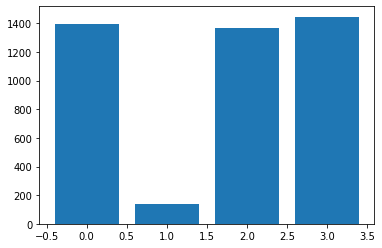

[[248   4 133 181]
 [ 16   4  21  33]
 [135   3 234 189]
 [200  10 194 259]]
              precision    recall  f1-score   support

           0       0.41      0.44      0.43       566
           1       0.19      0.05      0.08        74
           2       0.40      0.42      0.41       561
           3       0.39      0.39      0.39       663

    accuracy                           0.40      1864
   macro avg       0.35      0.32      0.33      1864
weighted avg       0.39      0.40      0.39      1864


*** balanced ****

Class=0, n=1446 (25.000%)
Class=2, n=1446 (25.000%)
Class=3, n=1446 (25.000%)
Class=1, n=1446 (25.000%)


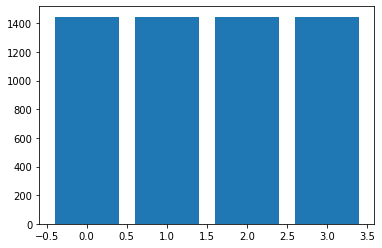

[[236  27 133 170]
 [ 17  14  16  27]
 [127  30 227 177]
 [196  46 182 239]]
              precision    recall  f1-score   support

           0       0.41      0.42      0.41       566
           1       0.12      0.19      0.15        74
           2       0.41      0.40      0.41       561
           3       0.39      0.36      0.37       663

    accuracy                           0.38      1864
   macro avg       0.33      0.34      0.34      1864
weighted avg       0.39      0.38      0.39      1864

CPU times: user 4.26 s, sys: 304 ms, total: 4.56 s
Wall time: 3.97 s


In [15]:
%%time

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


oversample=SMOTE()


idx="nev50"
clase="clase4"

x0=dfvecs3d[idx][0:len(dfvecsalidas[idx])] #.drop(columns=["Unnamed: 0"])
y0=dfvecsalidas[idx][clase]

Xtrain, Xtest, ytrain, ytest = train_test_split(x0, y0, test_size=0.3, random_state=42)

x,y = oversample.fit_resample(Xtrain,ytrain)

print("\n*** imbalanced ****\n")
counter = Counter(ytrain)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Imbalanced Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

modelo1 = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
modelo1.fit(Xtrain, ytrain)
predicciones1 = modelo1.predict(Xtest)
confmat1=confusion_matrix(ytest, predicciones1)
print(confmat1)
print(classification_report(ytest, predicciones1))

print("\n*** balanced ****\n")

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

modelo2 = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
modelo2.fit(x, y)
predicciones2 = modelo2.predict(Xtest)
confmat2=confusion_matrix(ytest, predicciones2)
print(confmat2)
print(classification_report(ytest, predicciones2))





*** imbalanced ****

Imbalanced Class=0, n=1396 (19.308%)
Imbalanced Class=2, n=669 (9.253%)
Imbalanced Class=4, n=1446 (20.000%)
Imbalanced Class=3, n=696 (9.627%)
Imbalanced Class=1, n=140 (1.936%)


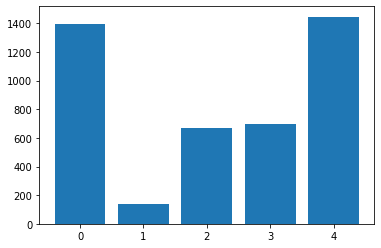

[[259   7  57  43 200]
 [ 21   6   8   8  31]
 [ 82   1  80  16 108]
 [ 70   2  24  82  96]
 [223   7  68  60 305]]
              precision    recall  f1-score   support

           0       0.40      0.46      0.42       566
           1       0.26      0.08      0.12        74
           2       0.34      0.28      0.31       287
           3       0.39      0.30      0.34       274
           4       0.41      0.46      0.43       663

    accuracy                           0.39      1864
   macro avg       0.36      0.32      0.33      1864
weighted avg       0.39      0.39      0.39      1864


*** balanced ****

Class=0, n=1446 (20.000%)
Class=2, n=1446 (20.000%)
Class=4, n=1446 (20.000%)
Class=3, n=1446 (20.000%)
Class=1, n=1446 (20.000%)


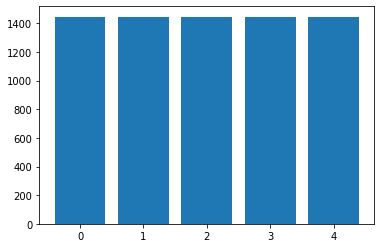

[[236  22  79  56 173]
 [ 18  13  10   9  24]
 [ 70  12  91  18  96]
 [ 56  15  33  92  78]
 [207  42 102  94 218]]
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       566
           1       0.12      0.18      0.15        74
           2       0.29      0.32      0.30       287
           3       0.34      0.34      0.34       274
           4       0.37      0.33      0.35       663

    accuracy                           0.35      1864
   macro avg       0.31      0.31      0.31      1864
weighted avg       0.35      0.35      0.35      1864

CPU times: user 5.08 s, sys: 328 ms, total: 5.41 s
Wall time: 4.81 s


In [23]:
%%time

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


oversample=SMOTE()


idx="nev50"
clase="clase5"

x0=dfvecs3d[idx][0:len(dfvecsalidas[idx])] #.drop(columns=["Unnamed: 0"])
y0=dfvecsalidas[idx][clase]

Xtrain, Xtest, ytrain, ytest = train_test_split(x0, y0, test_size=0.3, random_state=42)

x,y = oversample.fit_resample(Xtrain,ytrain)

print("\n*** imbalanced ****\n")
counter = Counter(ytrain)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Imbalanced Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

modelo1 = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
modelo1.fit(Xtrain, ytrain)
predicciones1 = modelo1.predict(Xtest)
confmat1=confusion_matrix(ytest, predicciones1)
print(confmat1)
print(classification_report(ytest, predicciones1))

print("\n*** balanced ****\n")

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

modelo2 = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
modelo2.fit(x, y)
predicciones2 = modelo2.predict(Xtest)
confmat2=confusion_matrix(ytest, predicciones2)
print(confmat2)
print(classification_report(ytest, predicciones2))




In [19]:
%%time

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


oversample=SMOTE()


idx="nev100"
clase="nmag"

x0=dfvecs3d[idx][0:len(dfvecsalidas[idx])] #.drop(columns=["Unnamed: 0"])
y0=dfvecsalidas[idx][clase]

Xtrain, Xtest, ytrain, ytest = train_test_split(x0, y0, test_size=0.3, random_state=42)

x,y = oversample.fit_resample(Xtrain,ytrain)

print("\n*** imbalanced ****\n")
counter = Counter(ytrain)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Imbalanced Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
#plt.bar(counter.keys(), counter.values())
#plt.show()

modelo1 = RandomForestClassifier(n_estimators=1000, random_state=42,class_weight='balanced')
modelo1.fit(Xtrain, ytrain)
predicciones1 = modelo1.predict(Xtest)
confmat1=confusion_matrix(ytest, predicciones1)
print(confmat1)
print(classification_report(ytest, predicciones1))

print("\n*** balanced ****\n")

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
#plt.bar(counter.keys(), counter.values())
#plt.show()

modelo2 = RandomForestClassifier(n_estimators=1000, random_state=42,class_weight='balanced')
modelo2.fit(x, y)
predicciones2 = modelo2.predict(Xtest)
confmat2=confusion_matrix(ytest, predicciones2)
print(confmat2)
print(classification_report(ytest, predicciones2))





*** imbalanced ****

Imbalanced Class=0, n=3636 (33.333%)
Imbalanced Class=1, n=598 (5.482%)
Imbalanced Class=2, n=78 (0.715%)
[[1523   39    2]
 [ 248    9    0]
 [  26    2    0]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1564
           1       0.18      0.04      0.06       257
           2       0.00      0.00      0.00        28

    accuracy                           0.83      1849
   macro avg       0.34      0.34      0.32      1849
weighted avg       0.74      0.83      0.77      1849


*** balanced ****

Class=0, n=3636 (33.333%)
Class=1, n=3636 (33.333%)
Class=2, n=3636 (33.333%)
[[1280  246   38]
 [ 195   56    6]
 [  21    5    2]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1564
           1       0.18      0.22      0.20       257
           2       0.04      0.07      0.05        28

    accuracy                           0.72      1849
   macro av


*** imbalanced ****

Imbalanced Class=0, n=3636 (50.000%)
Imbalanced Class=1, n=676 (9.296%)


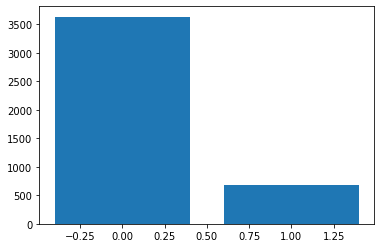

[[1516   48]
 [ 278    7]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1564
           1       0.13      0.02      0.04       285

    accuracy                           0.82      1849
   macro avg       0.49      0.50      0.47      1849
weighted avg       0.73      0.82      0.77      1849


*** balanced ****

Class=0, n=3636 (50.000%)
Class=1, n=3636 (50.000%)


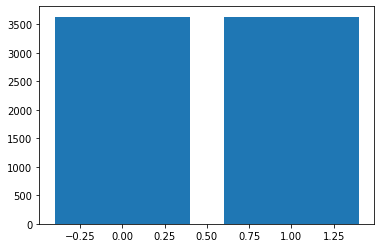

[[1292  272]
 [ 219   66]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1564
           1       0.20      0.23      0.21       285

    accuracy                           0.73      1849
   macro avg       0.53      0.53      0.53      1849
weighted avg       0.75      0.73      0.74      1849

CPU times: user 43.7 s, sys: 388 ms, total: 44.1 s
Wall time: 43.5 s


In [25]:
%%time

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


oversample=SMOTE()


idx="nev100"
clase="nmag2"

x0=dfvecs3d[idx][0:len(dfvecsalidas[idx])].drop(columns=["Unnamed: 0","nodos","edges"])
y0=dfvecsalidas[idx][clase]

Xtrain, Xtest, ytrain, ytest = train_test_split(x0, y0, test_size=0.3, random_state=42)

x,y = oversample.fit_resample(Xtrain,ytrain)

print("\n*** imbalanced ****\n")
counter = Counter(ytrain)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Imbalanced Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

modelo1 = RandomForestClassifier(n_estimators=1000, random_state=42,class_weight='balanced')
modelo1.fit(Xtrain, ytrain)
predicciones1 = modelo1.predict(Xtest)
confmat1=confusion_matrix(ytest, predicciones1)
print(confmat1)
print(classification_report(ytest, predicciones1))

print("\n*** balanced ****\n")

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

modelo2 = RandomForestClassifier(n_estimators=1000, random_state=42,class_weight='balanced')
modelo2.fit(x, y)
predicciones2 = modelo2.predict(Xtest)
confmat2=confusion_matrix(ytest, predicciones2)
print(confmat2)
print(classification_report(ytest, predicciones2))




In [42]:
modelo1.feature_importances_

array([0.08734507, 0.08502789, 0.11630307, 0.11578951, 0.09992036,
       0.11346253, 0.11986125, 0.14390675, 0.11838357])

In [43]:
modelo2.feature_importances_

array([0.10221794, 0.11171185, 0.09252592, 0.10675022, 0.11239157,
       0.09657454, 0.12075189, 0.14726412, 0.10981194])

In [44]:
Xtrain.columns

Index(['grad', 'clus', 'path', 'ent', 'sw', 'bet', 'energia', 'dtdias',
       'sismicidad'],
      dtype='object')

In [13]:
confmat

array([[165,  23,  83, 102],
       [ 11,   8,  12,  16],
       [ 96,  24, 151, 106],
       [127,  18, 125, 176]])

In [15]:
print(classification_report(ytest, predicciones))

              precision    recall  f1-score   support

           0       0.41      0.44      0.43       373
           1       0.11      0.17      0.13        47
           2       0.41      0.40      0.40       377
           3       0.44      0.39      0.42       446

    accuracy                           0.40      1243
   macro avg       0.34      0.35      0.35      1243
weighted avg       0.41      0.40      0.41      1243



In [ ]:
lidx=["nev10","nev50","nev100"]
clase="clase4"


for idx in lidx:
    #2D
    Xtrain, Xtest, ytrain, ytest = train_test_split(dfvecs2d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)
    
    #Random Forest 100 arboles
    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(Xtrain, ytrain)

    #Se salva el modelo
    with open("classmodelo-RF-2D-"+idx+"-"+clase+".pkl","wb") as fil:
        pickle.dump(modelo,fil)

    predicciones = modelo.predict(Xtest)

    #precision[idx+clase] = accuracy_score(ytest[idx+clase], predicciones[idx+clase])

    print('Matriz de Confusión:')
    confmat=confusion_matrix(ytest[idx+clase], predicciones[idx+clase])
    print(confmat)

            resultadotest[tipo+idx+clase] = Xtest[idx].copy()
            resultadotest[tipo+idx+clase]['valorreal'] = ytest[idx+clase].values
            resultadotest[tipo+idx+clase]['valorprediccion'] = predicciones[idx+clase]

            # Mostrar el conjunto de prueba con las predicciones y la columna real
            print("Conjunto de Prueba con Predicciones:")
            print(resultadotest[tipo+idx+clase])

            # Evaluar el modelo en el conjunto de prueba
            precisiontest[idx+clase] = accuracy_score(ytest[idx+clase], predicciones[idx+clase])
            print(f'\nPrecisión en el conjunto de prueba: {precisiontest[idx+clase]}')

            print('\nInforme de Clasificación:')
            print(classification_report(ytest[idx+clase], predicciones[idx+clase]))
            fig, ax = plt.subplots(figsize=(8,6), dpi=100)
            d1=dfvecsalidas[idx][clase].unique()
            d1=list(d1)
            d1.sort()

            display = ConfusionMatrixDisplay(confmat, display_labels=d1)

            # set the plot title using the axes object
            ax.set(title=tipo+' Networks - Confusion Matrix - Random Forest - '+idx+' - Class: '+clase)

            # show the plot. 
            # Pass the parameter ax to show customizations (ex. title) 
            display.plot(ax=ax);
            plt.savefig("CM-RF-"+idx+"-"+clase+"-"+tipo+".svg",format="svg")

    
    

## Random Forest Classifiers

*****************
 idx: nev10 - clase: clase4

Matriz de Confusión:
[[157   1  89 152]
 [  7   3   8  19]
 [ 95   4 161 139]
 [107   6 107 196]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448      9      9  2.000000  0.240741  2.694444  0.408131   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      6      8  2.666667  0.277778  1.933333  0.826165   
6109        6109      9      9  2.000000  0.000000  2.416667  0.408131   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564 

Matriz de Confusión:
[[1016   33]
 [ 195    7]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448      9      9  2.000000  0.240741  2.694444  0.408131   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      6      8  2.666667  0.277778  1.933333  0.826165   
6109        6109      9      9  2.000000  0.000000  2.416667  0.408131   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564          564      8      9  2.250000  0.000000  2.642857  0.378035   

            sw       bet  

*****************
 idx: nev50 - clase: nmag

Matriz de Confusión:
[[1015   46    2]
 [ 153   11    2]
 [  13    0    1]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
6158        6158     36     45  2.500000  0.088973  3.852381  0.184971   
1108        1108     33     42  2.545455  0.112213  3.683712  0.201989   
4442        4442     31     43  2.774194  0.034562  3.498925  0.281259   
2480        2480     15     23  3.066667  0.378413  2.495238  0.361216   
167          167     10     19  3.800000  0.581667  1.755556  0.732487   
...          ...    ...    ...       ...       ...       ...       ...   
2025        2025     16     23  2.875000  0.258929  2.591667  0.499840   
2339        2339     35     41  2.342857  0.042857  4.800000  0.298332   
2418        2418     29     38  2.620690  0.245813  6.110837  0.359871   
1344        1344     37     47  2.540541  0.055019  3.600601  0.273765   
2795        2795     39     

      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1056        1056     60     83  2.766667  0.142474  3.351977  0.217362   
410          410     38     68  3.578947  0.196592  2.640114  0.356487   
3948        3948     68     91  2.676471  0.044567  4.312555  0.232136   
3821        3821     53     83  3.132075  0.155165  3.150943  0.301526   
969          969     61     86  2.819672  0.046307  3.967760  0.255074   
...          ...    ...    ...       ...       ...       ...       ...   
4110        4110     66     92  2.787879  0.058333  4.040093  0.235279   
978          978     60     84  2.800000  0.040834  3.702260  0.235260   
5706        5706     58     80  2.758621  0.157389  3.163339  0.258192   
5244        5244     76     98  2.578947  0.015448  4.856140  0.179699   
3708        3708     62     88  2.838710  0.114045  3.414067  0.255165   

            sw       bet    energia      dtdias  sismicidad  valorreal  \
1056  3.708660  0.040551  34.200204  

      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448     10      9  1.800000  0.000000  3.666667  0.227743   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      7      9  2.571429  0.380952  1.904762  0.754445   
6109        6109     10      9  1.800000  0.000000  3.666667  0.227743   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564          564      9      9  2.000000  0.000000  3.333333  0.167753   

            sw       bet    energia     dtdias  sismicidad  valorreal  \
1703  0.000000  0.333333  32.866828  3

Matriz de Confusión:
[[1016   33]
 [ 192   10]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448     10      9  1.800000  0.000000  3.666667  0.227743   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      7      9  2.571429  0.380952  1.904762  0.754445   
6109        6109     10      9  1.800000  0.000000  3.666667  0.227743   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564          564      9      9  2.000000  0.000000  3.333333  0.167753   

            sw       bet  

*****************
 idx: nev50 - clase: nmag

Matriz de Confusión:
[[1013   48    2]
 [ 152   12    2]
 [  14    0    0]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
6158        6158     38     45  2.368421  0.031433  4.533428  0.175119   
1108        1108     34     42  2.470588  0.069697  3.827094  0.175456   
4442        4442     34     45  2.647059  0.032423  4.087344  0.311498   
2480        2480     16     24  3.000000  0.313095  2.575000  0.460416   
167          167     11     19  3.454545  0.395022  1.909091  0.614214   
...          ...    ...    ...       ...       ...       ...       ...   
2025        2025     18     23  2.555556  0.218254  3.307190  0.432751   
2339        2339     37     44  2.378378  0.095495  5.210210  0.259364   
2418        2418     30     38  2.533333  0.237619  6.271264  0.308551   
1344        1344     37     47  2.540541  0.055019  3.600601  0.273765   
2795        2795     40     

<timed exec>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


*****************
 idx: nev100 - clase: clase5

Matriz de Confusión:
[[162   4  36  34 136]
 [ 10   6   1   5  19]
 [ 53   6  53  16  70]
 [ 56   2  15  68  64]
 [140   6  46  31 194]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1056        1056     61     83  2.721311  0.118280  3.372131  0.204531   
410          410     41     70  3.414634  0.205538  3.023171  0.354161   
3948        3948     74     93  2.513514  0.033896  4.889300  0.173730   
3821        3821     57     84  2.947368  0.120244  3.338346  0.281655   
969          969     64     86  2.687500  0.052022  4.849206  0.237624   
...          ...    ...    ...       ...       ...       ...       ...   
4110        4110     71     95  2.676056  0.047066  4.260362  0.201991   
978          978     62     84  2.709677  0.039671  4.526177  0.232318   
5706        5706     61     86  2.819672  0.173731  3.609836  0.234083   
5244        5244     80     98  2.4500

CPU times: user 51.4 s, sys: 13.2 s, total: 1min 4s
Wall time: 2min 40s


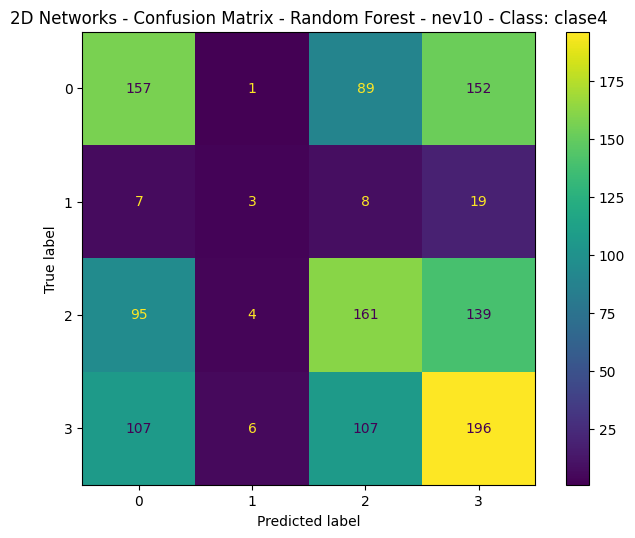

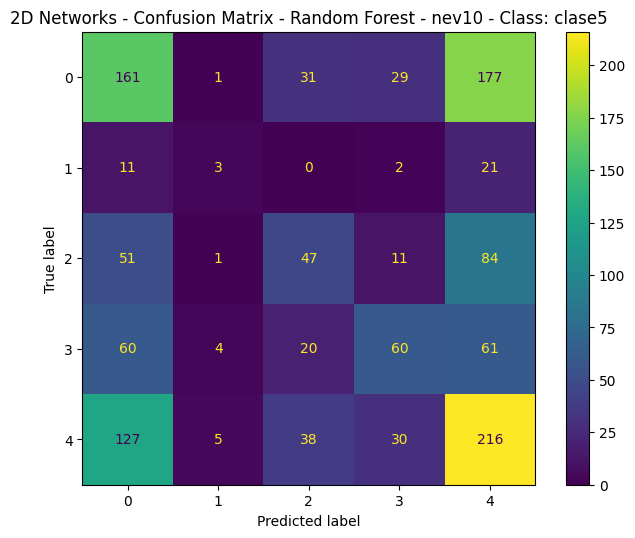

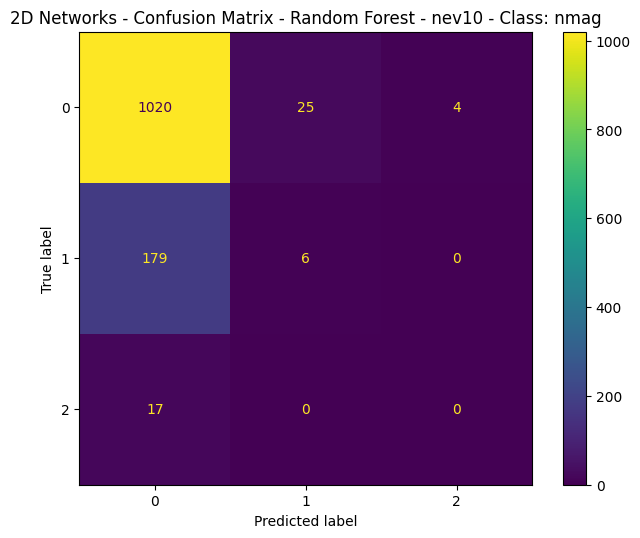

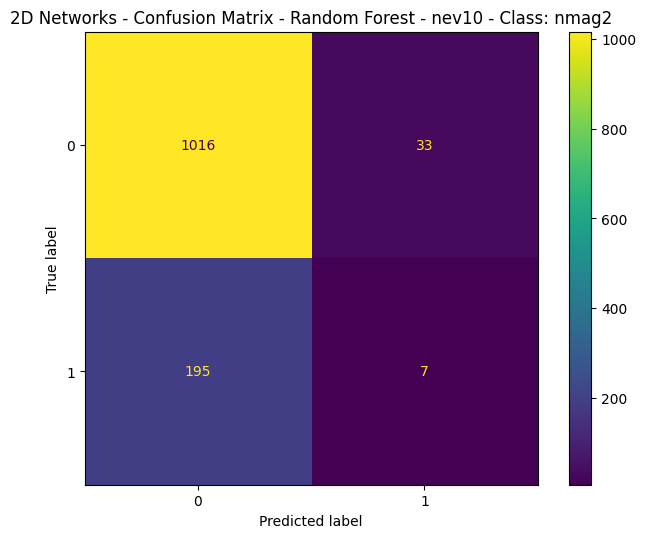

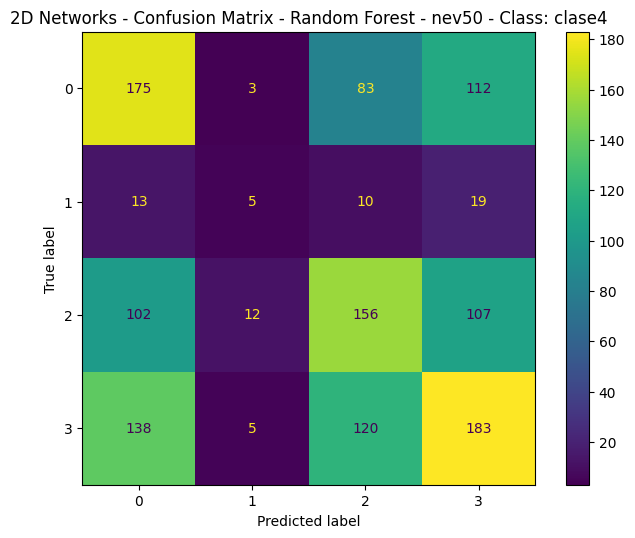

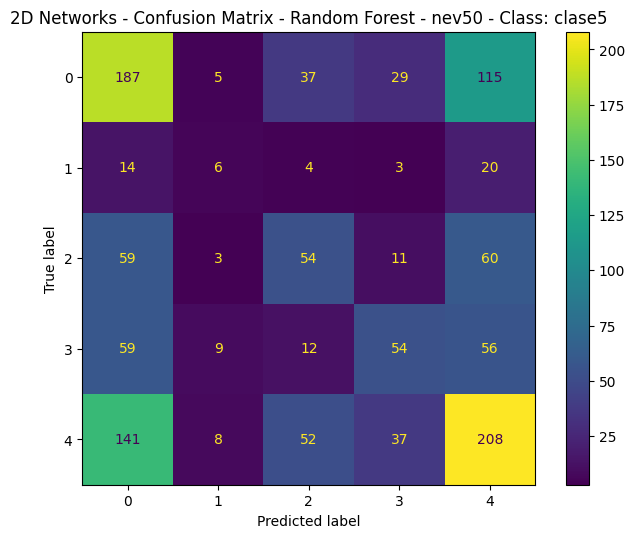

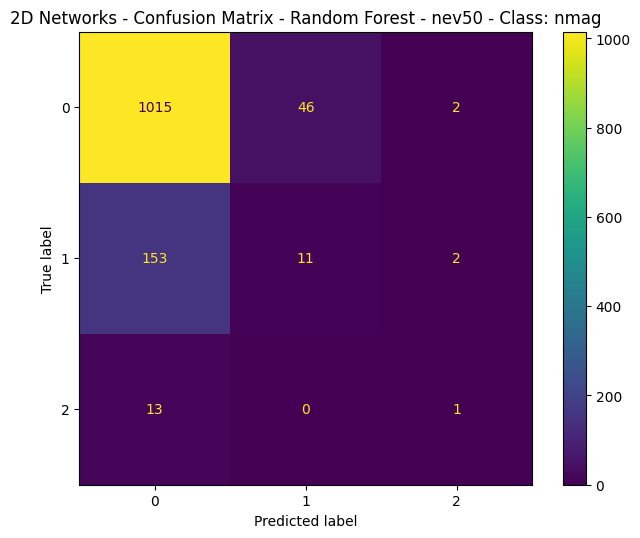

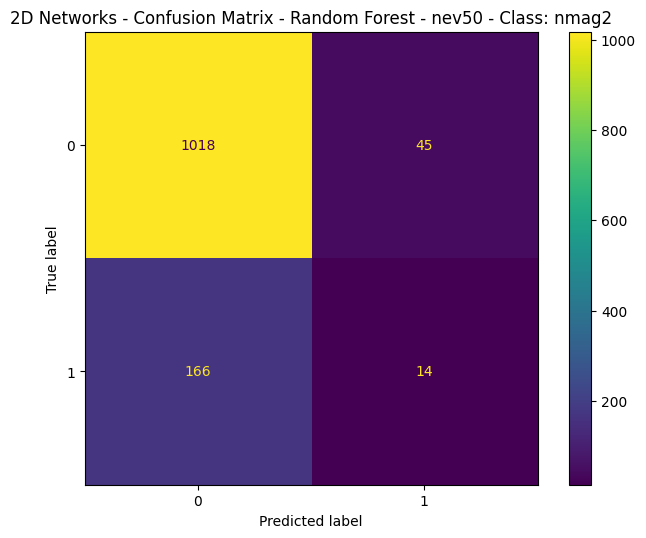

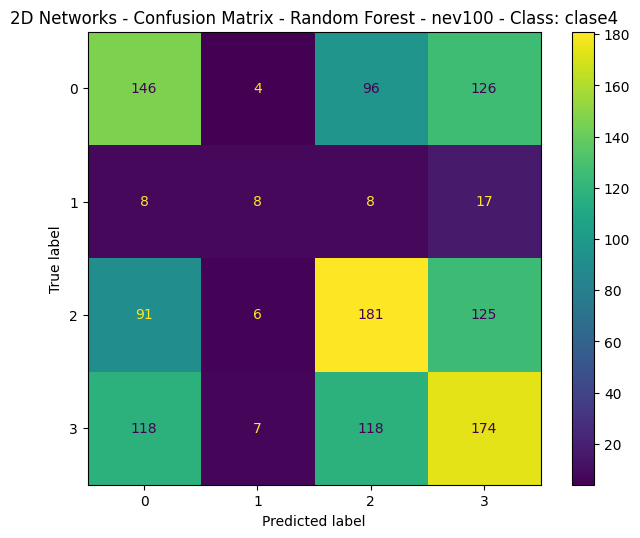

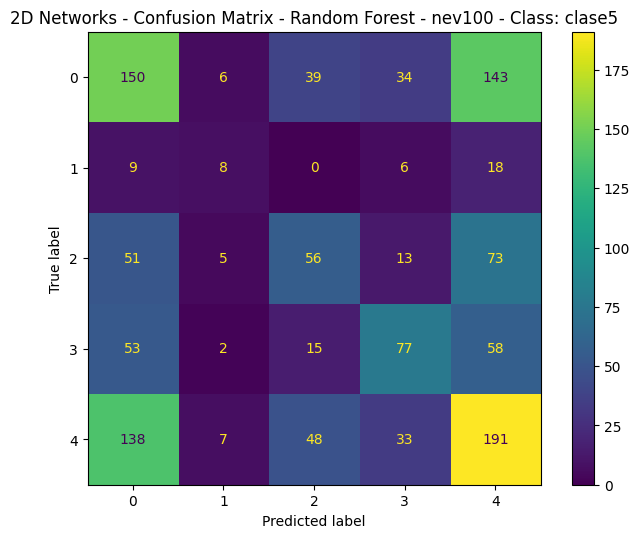

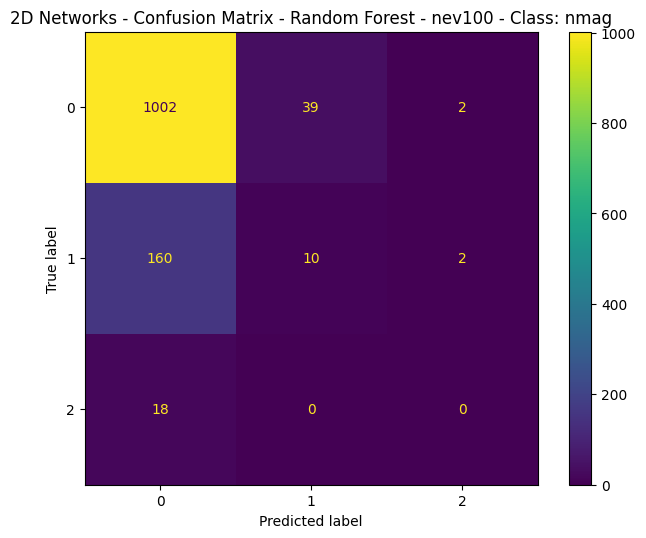

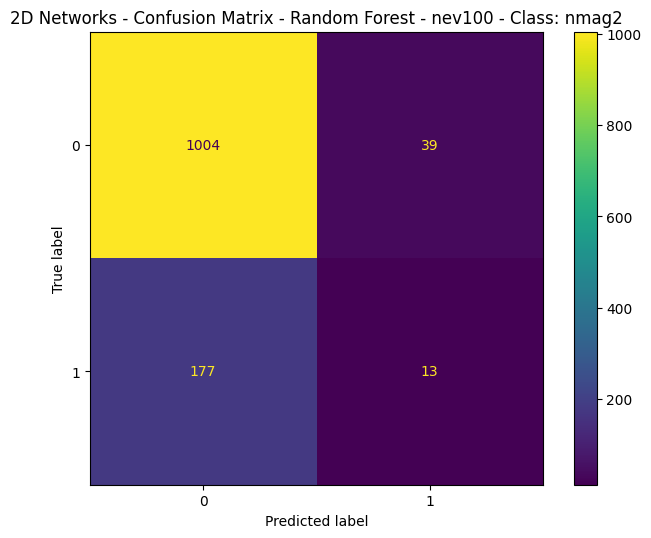

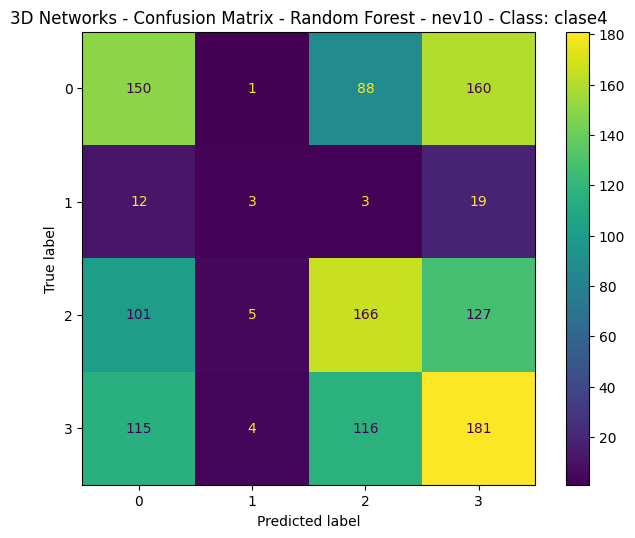

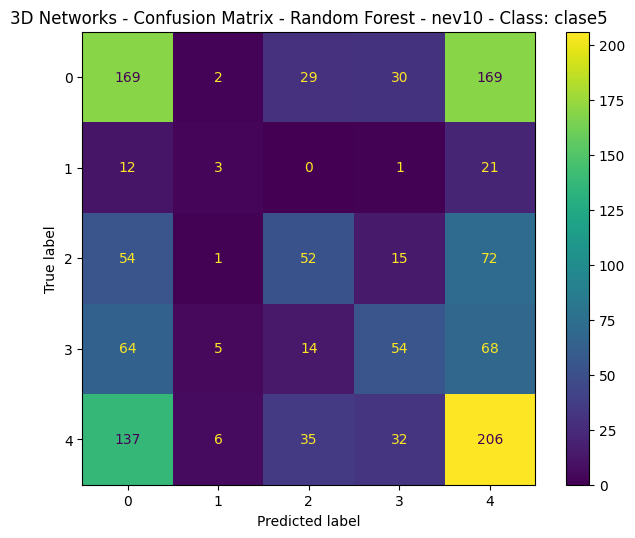

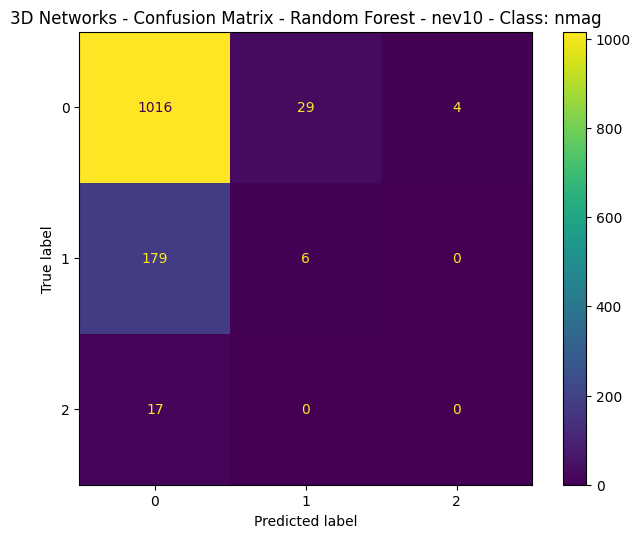

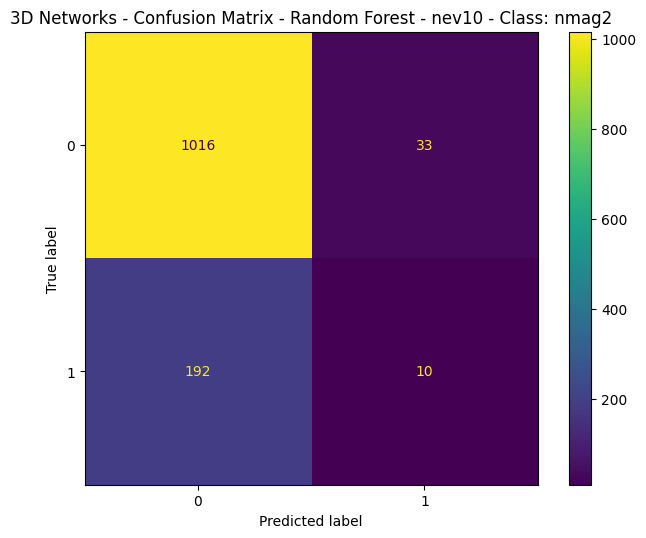

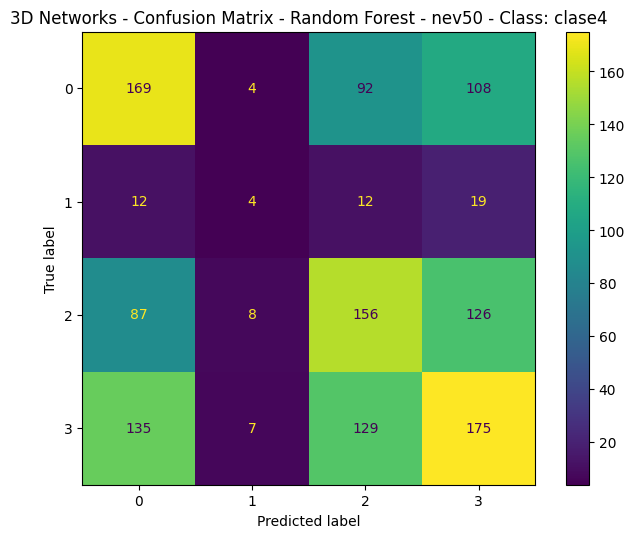

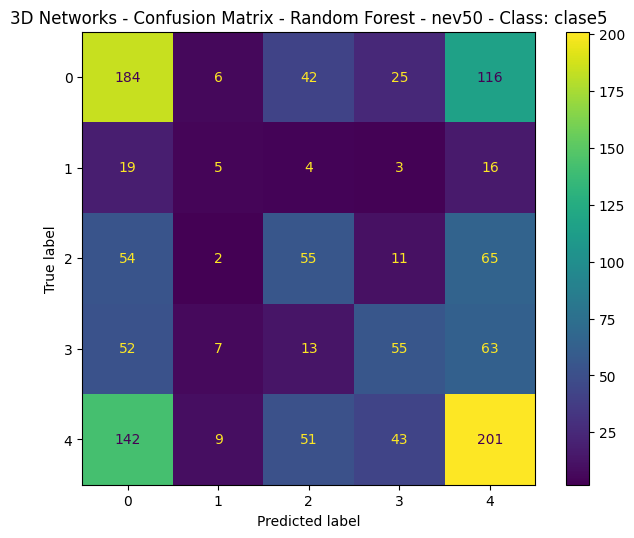

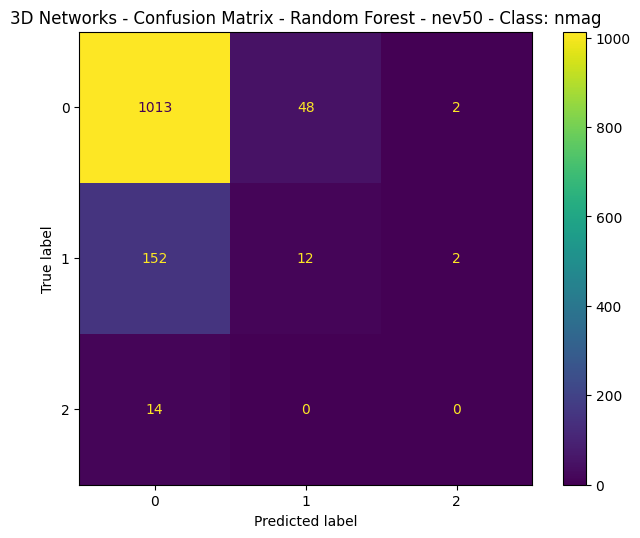

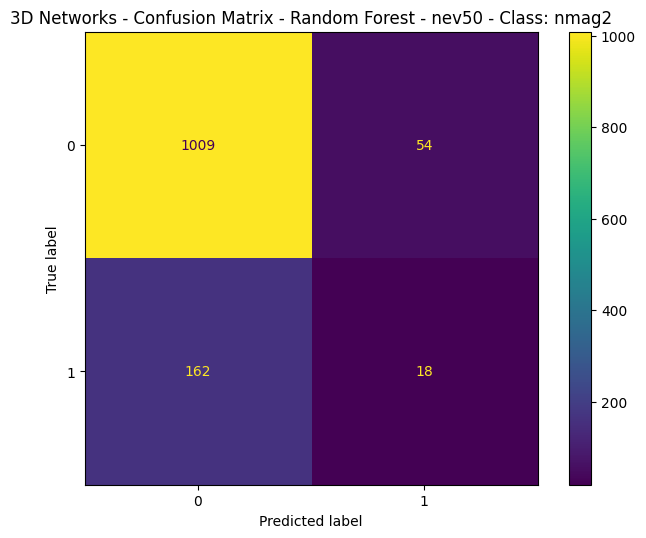

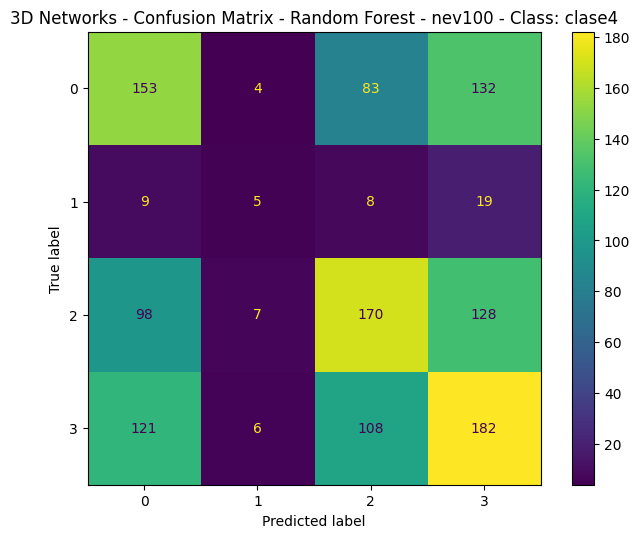

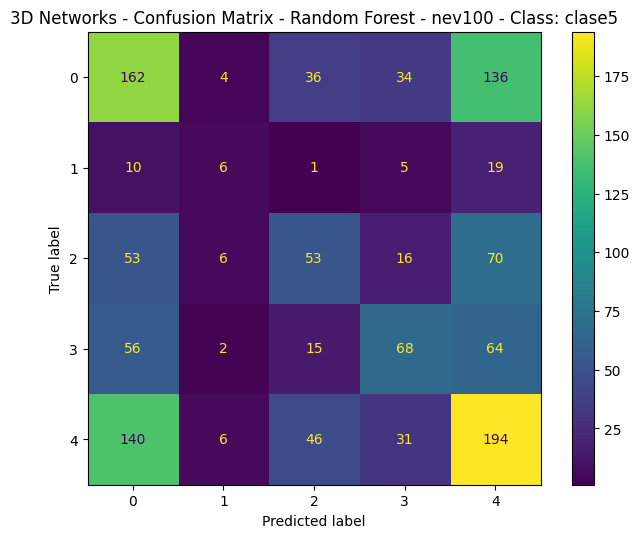

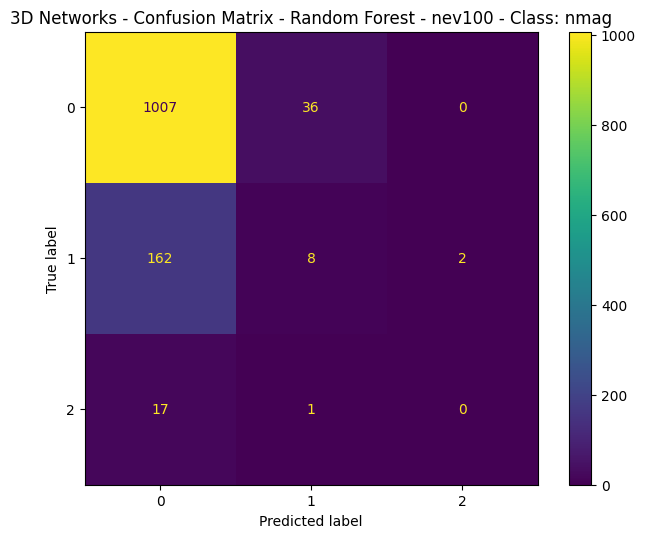

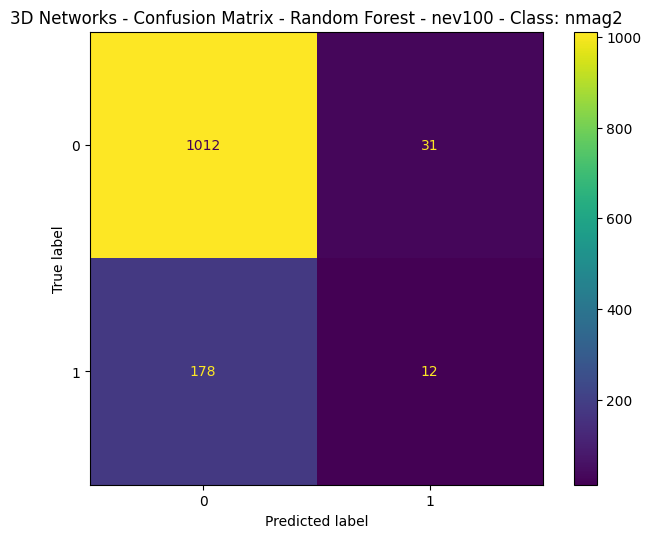

In [14]:
%%time

Xtrain={}
Xtest={}
ytrain={}
ytest={}
modelorf={}
predicciones={}
resultadotest={}
precisiontest={}

lidx=["nev10","nev50","nev100"]
#idx="nev10"
lclase=["clase4","clase5","nmag","nmag2"]
#clase="clase4"
#y=dfvecsalidas[idx]
#x=dfvecs3d[idx][0:len(y)]
#.drop([""])

tipos=["2D","3D"]

for tipo in tipos:
    for idx in lidx:
        for clase in lclase:
            print("*****************\n idx: "+idx+" - clase: "+clase+"\n")

            if tipo == "2D":
                Xtrain[idx], Xtest[idx], ytrain[idx+clase], ytest[idx+clase] = train_test_split(dfvecs2d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)
            else:
                Xtrain[idx], Xtest[idx], ytrain[idx+clase], ytest[idx+clase] = train_test_split(dfvecs3d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)

            # Crear el modelo de Random Forest
            modelorf[idx+clase] = RandomForestClassifier(n_estimators=100, random_state=42)

            # Entrenar el modelo
            modelorf[idx+clase].fit(Xtrain[idx], ytrain[idx+clase])

            #Se salva el modelo
            with open("classmodelo-RF-"+tipo+"-"+idx+"-"+clase+".pkl","wb") as fil:
                pickle.dump(modelorf,fil)

            predicciones[idx+clase] = modelorf[idx+clase].predict(Xtest[idx])

            #precision[idx+clase] = accuracy_score(ytest[idx+clase], predicciones[idx+clase])

            print('Matriz de Confusión:')
            confmat=confusion_matrix(ytest[idx+clase], predicciones[idx+clase])
            print(confmat)

            resultadotest[tipo+idx+clase] = Xtest[idx].copy()
            resultadotest[tipo+idx+clase]['valorreal'] = ytest[idx+clase].values
            resultadotest[tipo+idx+clase]['valorprediccion'] = predicciones[idx+clase]

            # Mostrar el conjunto de prueba con las predicciones y la columna real
            print("Conjunto de Prueba con Predicciones:")
            print(resultadotest[tipo+idx+clase])

            # Evaluar el modelo en el conjunto de prueba
            precisiontest[idx+clase] = accuracy_score(ytest[idx+clase], predicciones[idx+clase])
            print(f'\nPrecisión en el conjunto de prueba: {precisiontest[idx+clase]}')

            print('\nInforme de Clasificación:')
            print(classification_report(ytest[idx+clase], predicciones[idx+clase]))
            fig, ax = plt.subplots(figsize=(8,6), dpi=100)
            d1=dfvecsalidas[idx][clase].unique()
            d1=list(d1)
            d1.sort()

            display = ConfusionMatrixDisplay(confmat, display_labels=d1)

            # set the plot title using the axes object
            ax.set(title=tipo+' Networks - Confusion Matrix - Random Forest - '+idx+' - Class: '+clase)

            # show the plot. 
            # Pass the parameter ax to show customizations (ex. title) 
            display.plot(ax=ax);
            plt.savefig("CM-RF-"+idx+"-"+clase+"-"+tipo+".svg",format="svg")


## Support Vector Machine classifier

*****************
 idx: nev10 - clase: clase4

Matriz de Confusión:
[[150   1  88 160]
 [ 12   3   3  19]
 [101   5 166 127]
 [115   4 116 181]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448      9      9  2.000000  0.240741  2.694444  0.408131   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      6      8  2.666667  0.277778  1.933333  0.826165   
6109        6109      9      9  2.000000  0.000000  2.416667  0.408131   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564 

*****************
 idx: nev10 - clase: nmag2

Matriz de Confusión:
[[1016   33]
 [ 192   10]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448      9      9  2.000000  0.240741  2.694444  0.408131   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      6      8  2.666667  0.277778  1.933333  0.826165   
6109        6109      9      9  2.000000  0.000000  2.416667  0.408131   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564          564      8      9  2.250000  0.000000  2.6

*****************
 idx: nev50 - clase: nmag

Matriz de Confusión:
[[1013   48    2]
 [ 152   12    2]
 [  14    0    0]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
6158        6158     36     45  2.500000  0.088973  3.852381  0.184971   
1108        1108     33     42  2.545455  0.112213  3.683712  0.201989   
4442        4442     31     43  2.774194  0.034562  3.498925  0.281259   
2480        2480     15     23  3.066667  0.378413  2.495238  0.361216   
167          167     10     19  3.800000  0.581667  1.755556  0.732487   
...          ...    ...    ...       ...       ...       ...       ...   
2025        2025     16     23  2.875000  0.258929  2.591667  0.499840   
2339        2339     35     41  2.342857  0.042857  4.800000  0.298332   
2418        2418     29     38  2.620690  0.245813  6.110837  0.359871   
1344        1344     37     47  2.540541  0.055019  3.600601  0.273765   
2795        2795     39     

Matriz de Confusión:
[[1007   36    0]
 [ 162    8    2]
 [  17    1    0]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1056        1056     60     83  2.766667  0.142474  3.351977  0.217362   
410          410     38     68  3.578947  0.196592  2.640114  0.356487   
3948        3948     68     91  2.676471  0.044567  4.312555  0.232136   
3821        3821     53     83  3.132075  0.155165  3.150943  0.301526   
969          969     61     86  2.819672  0.046307  3.967760  0.255074   
...          ...    ...    ...       ...       ...       ...       ...   
4110        4110     66     92  2.787879  0.058333  4.040093  0.235279   
978          978     60     84  2.800000  0.040834  3.702260  0.235260   
5706        5706     58     80  2.758621  0.157389  3.163339  0.258192   
5244        5244     76     98  2.578947  0.015448  4.856140  0.179699   
3708        3708     62     88  2.838710  0.114045  3.414067  0.255165   

Matriz de Confusión:
[[1016   29    4]
 [ 179    6    0]
 [  17    0    0]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1703        1703     10      9  1.800000  0.000000  3.666667  0.227743   
5448        5448     10      9  1.800000  0.000000  3.666667  0.227743   
5058        5058     10      9  1.800000  0.000000  3.666667  0.227743   
1149        1149      7      7  2.000000  0.000000  2.476190  0.560478   
432          432      3      3  2.000000  0.000000  1.333333  0.918296   
...          ...    ...    ...       ...       ...       ...       ...   
416          416      7      9  2.571429  0.380952  1.904762  0.754445   
6109        6109     10      9  1.800000  0.000000  3.666667  0.227743   
3185        3185      9      9  2.000000  0.240741  2.694444  0.408131   
2025        2025      9      8  1.777778  0.000000  3.055556  0.450548   
564          564      9      9  2.000000  0.000000  3.333333  0.167753   

*****************
 idx: nev50 - clase: nmag

Matriz de Confusión:
[[1013   48    2]
 [ 152   12    2]
 [  14    0    0]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
6158        6158     38     45  2.368421  0.031433  4.533428  0.175119   
1108        1108     34     42  2.470588  0.069697  3.827094  0.175456   
4442        4442     34     45  2.647059  0.032423  4.087344  0.311498   
2480        2480     16     24  3.000000  0.313095  2.575000  0.460416   
167          167     11     19  3.454545  0.395022  1.909091  0.614214   
...          ...    ...    ...       ...       ...       ...       ...   
2025        2025     18     23  2.555556  0.218254  3.307190  0.432751   
2339        2339     37     44  2.378378  0.095495  5.210210  0.259364   
2418        2418     30     38  2.533333  0.237619  6.271264  0.308551   
1344        1344     37     47  2.540541  0.055019  3.600601  0.273765   
2795        2795     40     

<timed exec>:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Matriz de Confusión:
[[162   4  36  34 136]
 [ 10   6   1   5  19]
 [ 53   6  53  16  70]
 [ 56   2  15  68  64]
 [140   6  46  31 194]]
Conjunto de Prueba con Predicciones:
      Unnamed: 0  nodos  edges      grad      clus      path       ent  \
1056        1056     61     83  2.721311  0.118280  3.372131  0.204531   
410          410     41     70  3.414634  0.205538  3.023171  0.354161   
3948        3948     74     93  2.513514  0.033896  4.889300  0.173730   
3821        3821     57     84  2.947368  0.120244  3.338346  0.281655   
969          969     64     86  2.687500  0.052022  4.849206  0.237624   
...          ...    ...    ...       ...       ...       ...       ...   
4110        4110     71     95  2.676056  0.047066  4.260362  0.201991   
978          978     62     84  2.709677  0.039671  4.526177  0.232318   
5706        5706     61     86  2.819672  0.173731  3.609836  0.234083   
5244        5244     80     98  2.450000  0.014744  5.717405  0.162147   
3708        

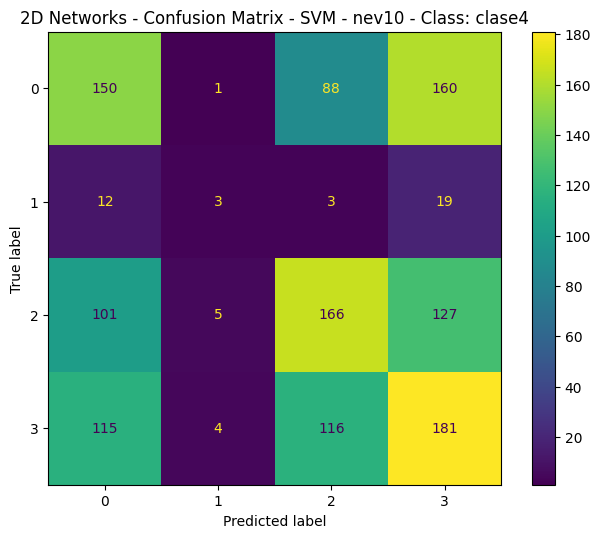

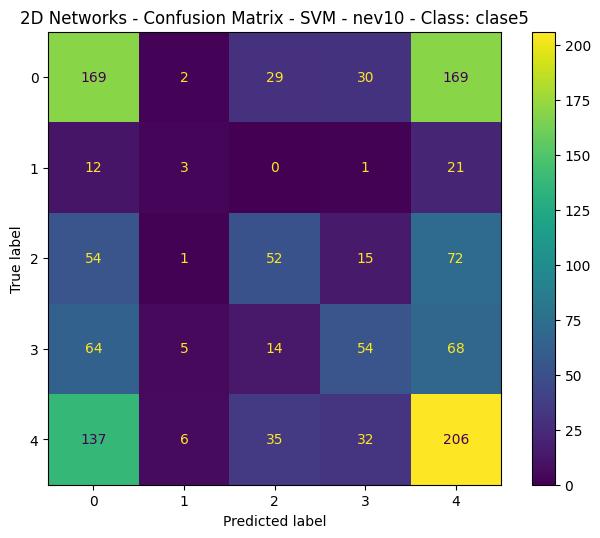

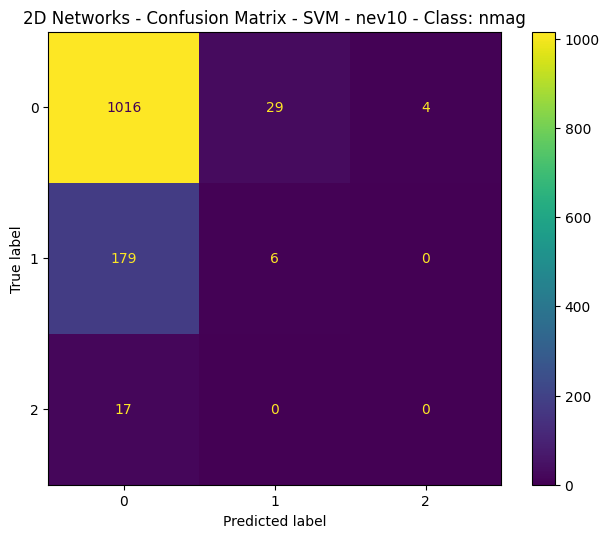

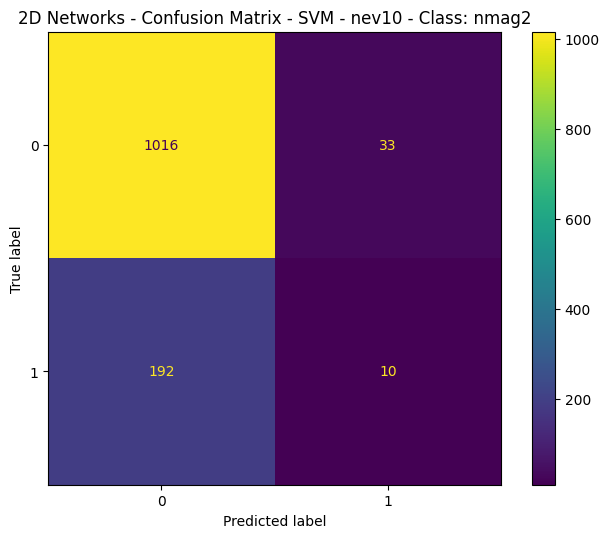

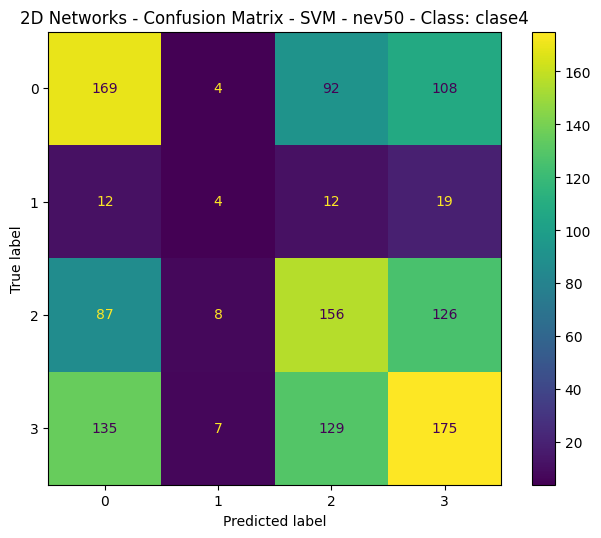

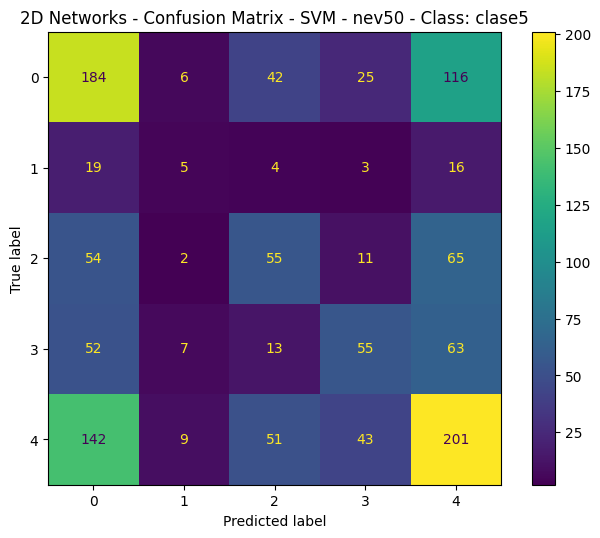

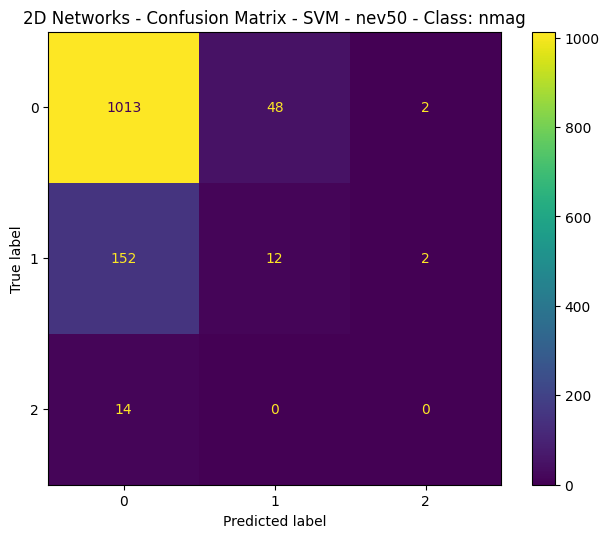

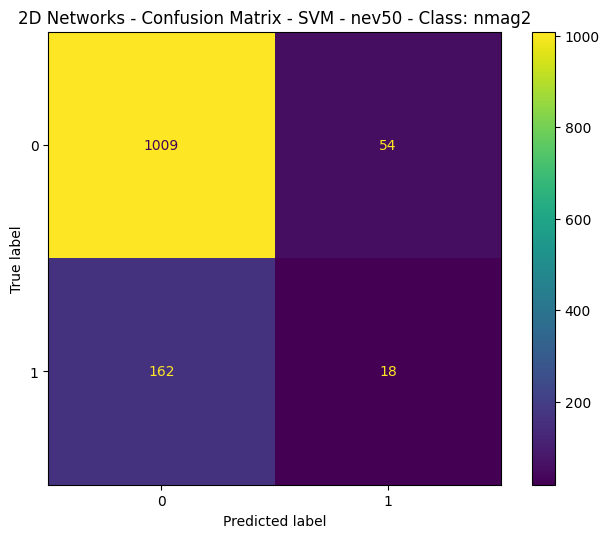

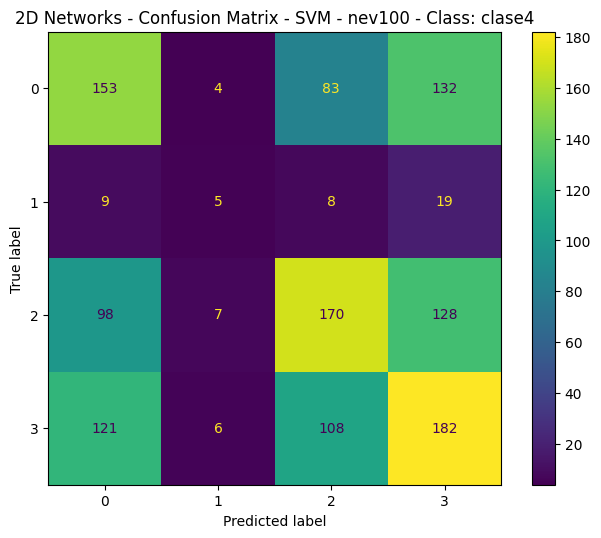

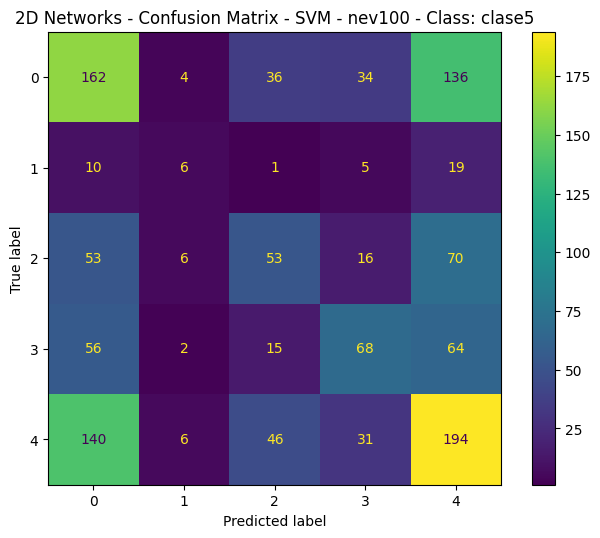

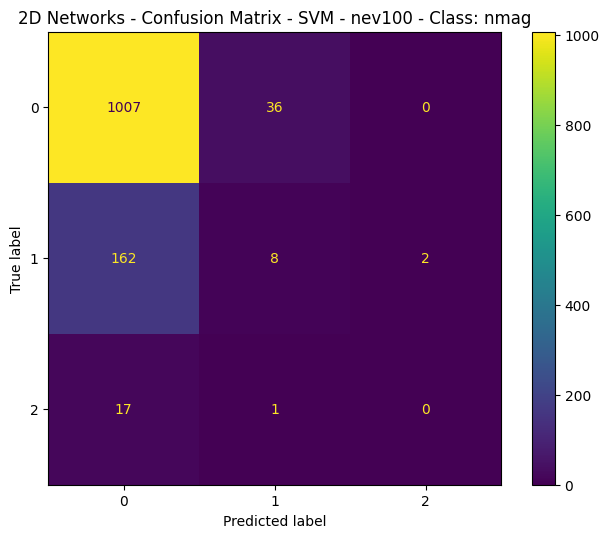

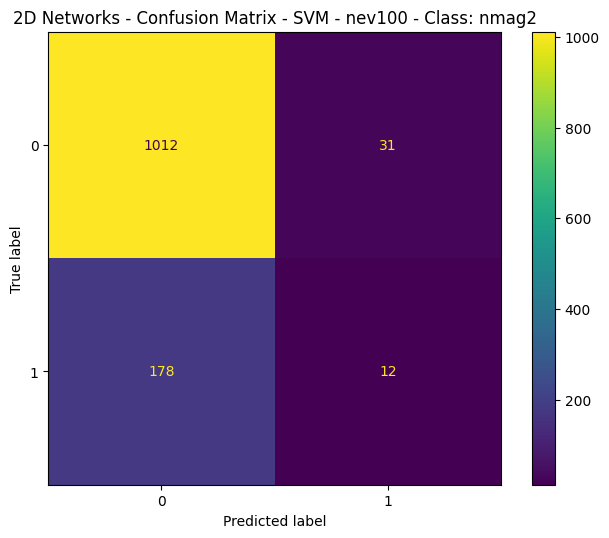

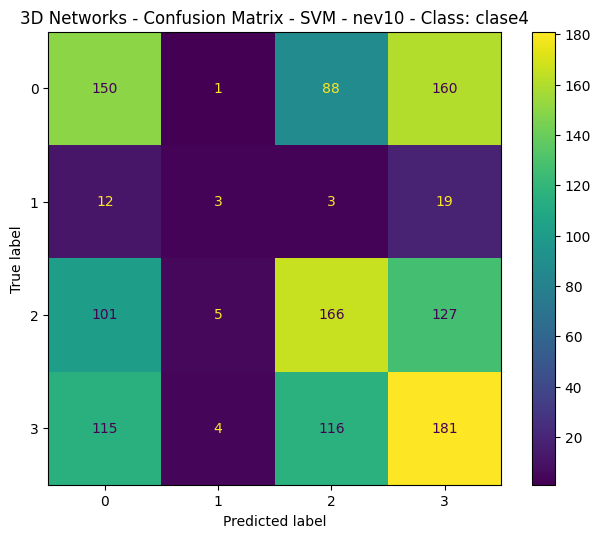

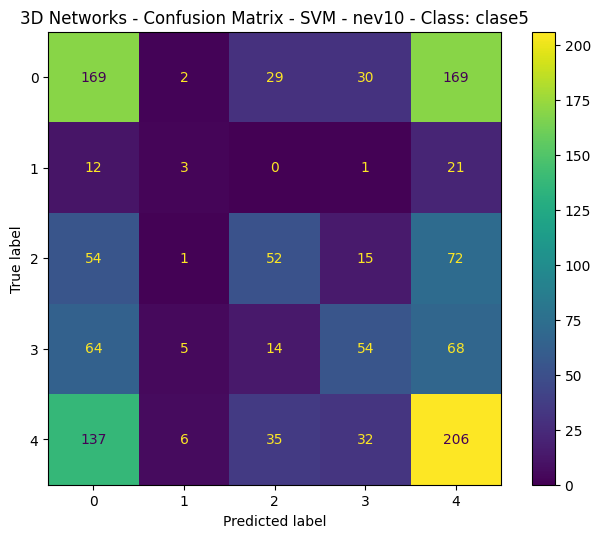

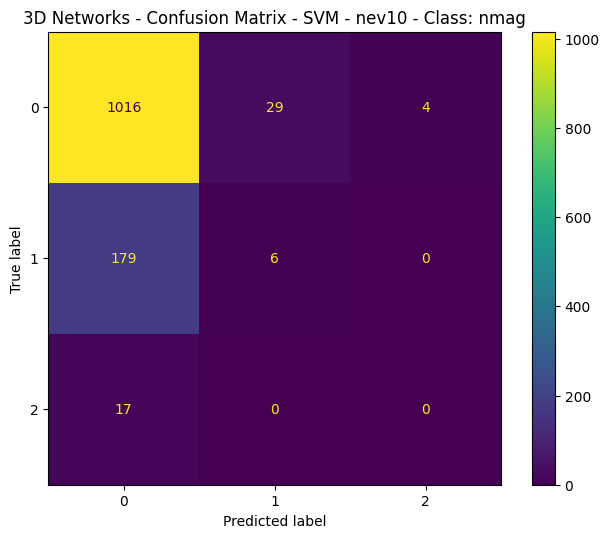

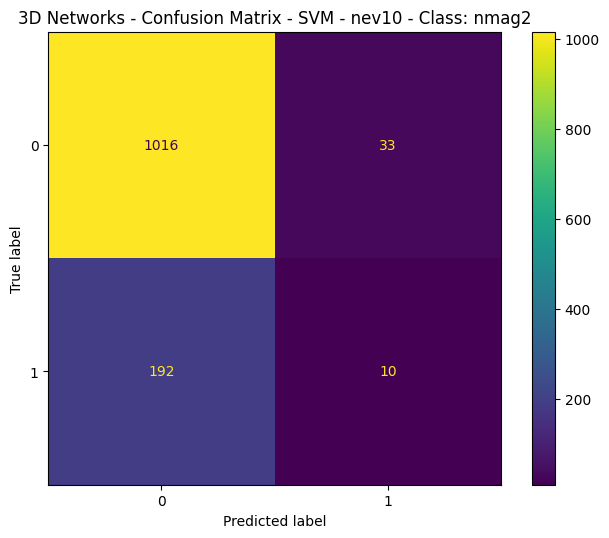

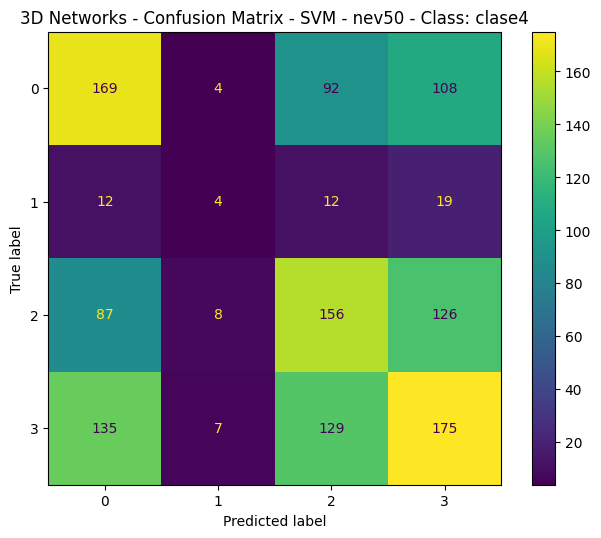

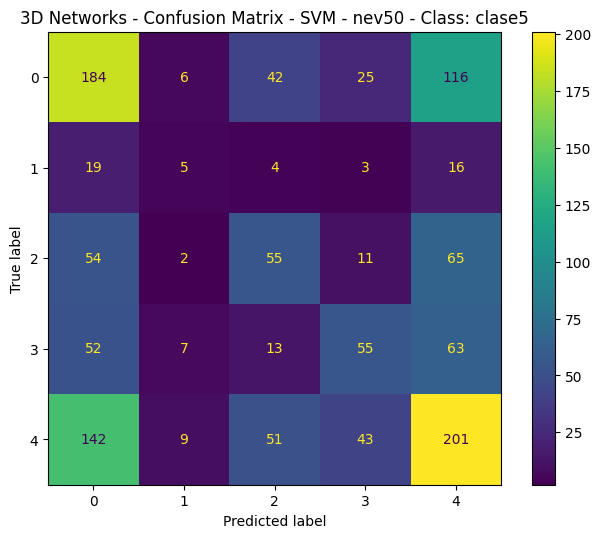

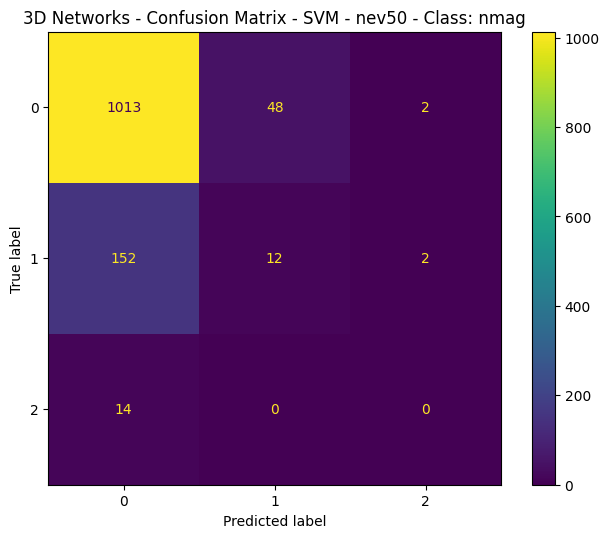

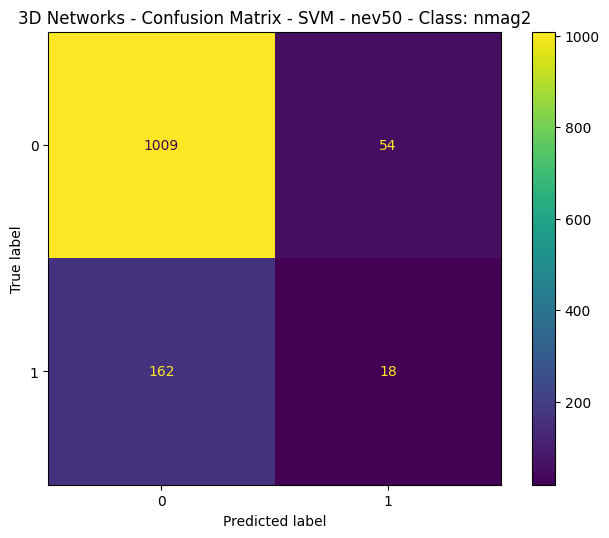

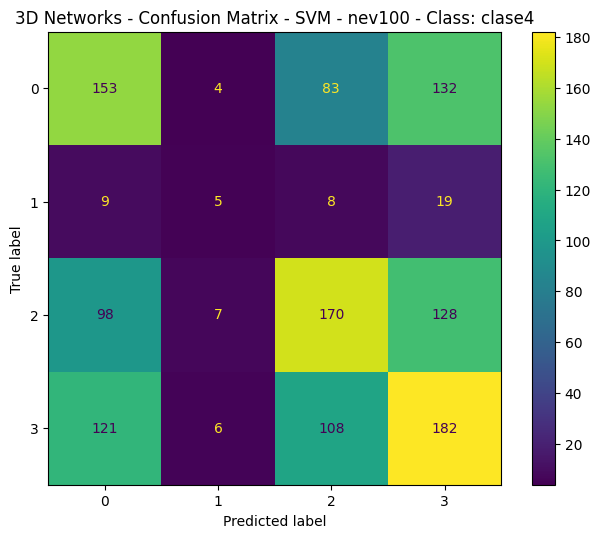

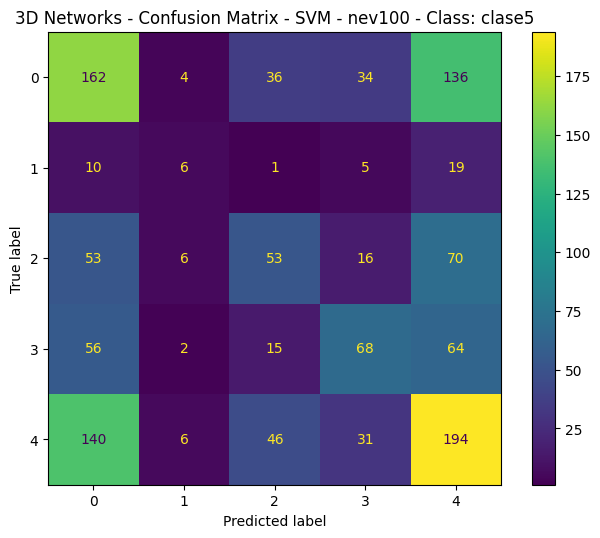

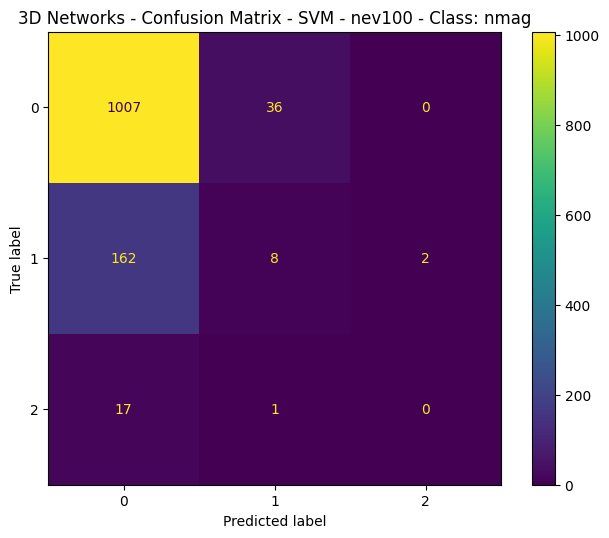

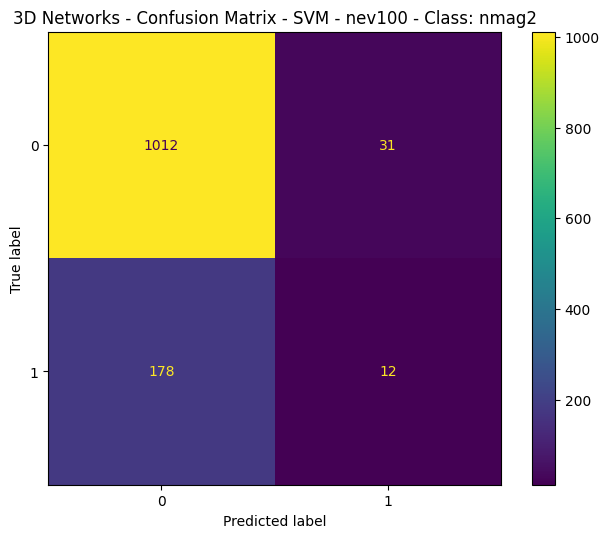

In [21]:
%%time

from sklearn import datasets, svm

Xtrain={}
Xtest={}
ytrain={}
ytest={}
#modelosvm={}
prediccionessvm={}
resultadotestsvm={}
precisiontestsvm={}

tipos=["2D","3D"]

lidx=["nev10","nev50","nev100"]
#idx="nev10"
lclase=["clase4","clase5","nmag","nmag2"]
#clase="clase4"
#y=dfvecsalidas[idx]
#x=dfvecs3d[idx][0:len(y)]
#.drop([""])

for tipo in tipos:
    for idx in lidx:
        for clase in lclase:
            print("*****************\n idx: "+idx+" - clase: "+clase+"\n")
            d1=dfvecsalidas[idx][clase].unique()
            d1=list(d1)
            d1.sort()


            if tipo == "2D":
                Xtrain[idx], Xtest[idx], ytrain[idx+clase], ytest[idx+clase] = train_test_split(dfvecs2d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)
            else:
                Xtrain[idx], Xtest[idx], ytrain[idx+clase], ytest[idx+clase] = train_test_split(dfvecs3d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)

            # Crear el modelo de Random Forest
            modelosvm = svm.SVC(kernel="rbf", gamma=0.7, C=1.0)

            # Entrenar el modelo
            modelosvm.fit(Xtrain[idx], ytrain[idx+clase])

            #Se salva el modelo
            with open("classmodelo-svm-"+tipo+"-"+idx+"-"+clase+".pkl","wb") as fil:
                pickle.dump(modelosvm,fil)

            prediccionessvm[idx+clase] = modelosvm.predict(Xtest[idx])

            #precision[idx+clase] = accuracy_score(ytest[idx+clase], predicciones[idx+clase])

            print('Matriz de Confusión:')
            confmat=confusion_matrix(ytest[idx+clase], predicciones[idx+clase])
            print(confmat)

            resultadotest[tipo+idx+clase] = Xtest[idx].copy()
            resultadotest[tipo+idx+clase]['valorreal'] = ytest[idx+clase].values
            resultadotest[tipo+idx+clase]['valorprediccion'] = predicciones[idx+clase]

            # Mostrar el conjunto de prueba con las predicciones y la columna real
            print("Conjunto de Prueba con Predicciones:")
            print(resultadotest[tipo+idx+clase])

            # Evaluar el modelo en el conjunto de prueba
            precisiontest[idx+clase] = accuracy_score(ytest[idx+clase], predicciones[idx+clase])
            print(f'\nPrecisión en el conjunto de prueba: {precisiontest[idx+clase]}')

            print('\nInforme de Clasificación:')
            print(classification_report(ytest[idx+clase], predicciones[idx+clase]))
            fig, ax = plt.subplots(figsize=(8,6), dpi=100)
            d1=dfvecsalidas[idx][clase].unique()
            d1=list(d1)
            d1.sort()

            display = ConfusionMatrixDisplay(confmat, display_labels=d1)

            # set the plot title using the axes object
            ax.set(title=tipo+' Networks - Confusion Matrix - SVM - '+idx+' - Class: '+clase)

            # show the plot. 
            # Pass the parameter ax to show customizations (ex. title) 
            display.plot(ax=ax);
            plt.savefig("CM-SVM-"+idx+"-"+clase+"-"+tipo+".svg",format="svg")


## Stellargraph - Graph Convolutional Neural Networks.

Se escogen valores para entrenar la GCNN. Estos se toman de una tabla de experimentos previos.

Empieza modelo con learnrate:  0.0005
Epoch 1/100


/home/danileo/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


100/100 [==============================] - 12s 124ms/step - loss: 0.5514 - accuracy: 0.9897 - val_loss: 0.4976 - val_accuracy: 1.0000
Epoch 2/100
100/100 [==============================] - 7s 67ms/step - loss: 0.5047 - accuracy: 1.0000 - val_loss: 0.4903 - val_accuracy: 1.0000
Epoch 3/100
100/100 [==============================] - 5s 54ms/step - loss: 0.5054 - accuracy: 1.0000 - val_loss: 0.4911 - val_accuracy: 1.0000
Epoch 4/100
100/100 [==============================] - 6s 60ms/step - loss: 0.5082 - accuracy: 1.0000 - val_loss: 0.4911 - val_accuracy: 1.0000
Epoch 5/100
100/100 [==============================] - 6s 56ms/step - loss: 0.5067 - accuracy: 1.0000 - val_loss: 0.4884 - val_accuracy: 1.0000
Epoch 6/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5011 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 1.0000
Epoch 7/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5036 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 1.0000
Ep

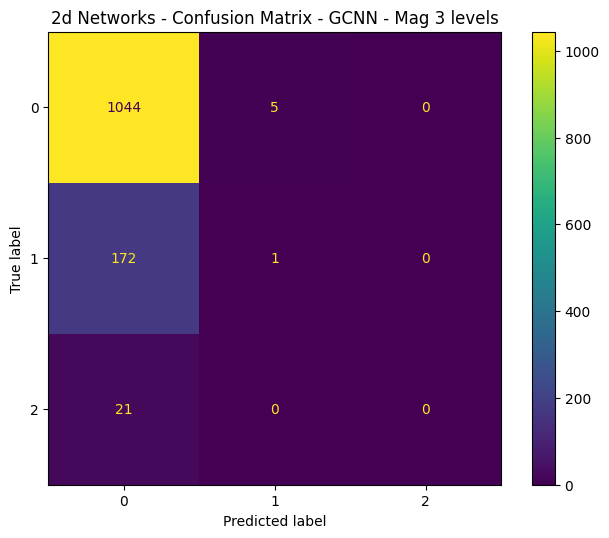

In [18]:
%%time

#nmag
tipo="2d"

idx="nev50"
clase="nmag"

batchtrain=50
batchtest=1
nrows=30
layer_dims=[30,30,30,4]
filters1=16
filters2=32
poolsize=2
ksize=8
units=128
activation1="relu"
activation2="softmax"
learnrate=0.0005
epochs=100


dfylabels=pd.DataFrame(dfvecsalidas[idx][clase].values,columns=["label"])
d1=dfvecsalidas[idx][clase].unique()
d1=list(d1)
d1.sort()

c=dfylabels.value_counts("label")

unout=len(c)

glabels = pd.get_dummies(dfylabels, drop_first=True)

train_graphs, test_graphs = model_selection.train_test_split(
    glabels, test_size=.2, stratify=dfylabels, random_state = 42
)


if tipo == "2d":
    gen = PaddedGraphGenerator(graphs=grafosstellars2dall[idx])
elif tipo == "3d":
    gen = PaddedGraphGenerator(graphs=grafosstellars3dall[idx])

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtrain,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtest,
)

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_dims,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=nrows,
    bias=False,
    generator=gen,
)

gnn_inp, gnn_out = dgcnn_model.in_out_tensors()

x_out = Conv1D(filters=filters1, kernel_size=sum(layer_dims), strides=sum(layer_dims))(gnn_out)
x_out = MaxPool1D(pool_size=poolsize)(x_out)
x_out = Conv1D(filters=filters2, kernel_size=ksize, strides=1)(x_out)
x_out = Flatten()(x_out)

x_out = Dense(units=units, activation=activation1)(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=unout, activation=activation2)(x_out)

modelnmag = Model(inputs=gnn_inp, outputs=predictions)
modelnmag.compile(optimizer=Adam(lr=learnrate), loss=sparse_categorical_crossentropy, metrics=["accuracy"])

print("Empieza modelo con learnrate: ",learnrate)
ini=time.time()
history = modelnmag.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

#modelnmag.save()
modelnmag.save("gcnn-"+tipo+"-"+idx+"-"+clase+".keras")

fin=time.time()
dif=fin-ini

predictlabels=modelnmag.predict(test_gen)
predicted_labels=[]

for v in predictlabels:
    c=0
    a=v[0]
    for i in range(len(v)):
        if v[i] > a:
            a=v[i]
            c=i
    predicted_labels.append(c)

targets=test_graphs.values
conf_matrix=confusion_matrix(targets,predicted_labels)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=d1)
 
# set the plot title using the axes object
ax.set(title=tipo+' Networks - Confusion Matrix - GCNN - Mag 3 levels')
 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

plt.savefig("CM-GCNN-Mag3-"+tipo+".svg",format="svg")

Empieza modelo con learnrate:  0.0005
Epoch 1/100


/home/danileo/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


100/100 [==============================] - 3s 33ms/step - loss: 0.4560 - accuracy: 0.9986 - val_loss: 0.4380 - val_accuracy: 1.0000
Epoch 2/100
100/100 [==============================] - 3s 32ms/step - loss: 0.4465 - accuracy: 1.0000 - val_loss: 0.4356 - val_accuracy: 1.0000
Epoch 3/100
100/100 [==============================] - 3s 32ms/step - loss: 0.4413 - accuracy: 1.0000 - val_loss: 0.4349 - val_accuracy: 1.0000
Epoch 4/100
100/100 [==============================] - 3s 32ms/step - loss: 0.4402 - accuracy: 1.0000 - val_loss: 0.4364 - val_accuracy: 1.0000
Epoch 5/100
100/100 [==============================] - 3s 32ms/step - loss: 0.4423 - accuracy: 1.0000 - val_loss: 0.4321 - val_accuracy: 1.0000
Epoch 6/100
100/100 [==============================] - 3s 31ms/step - loss: 0.4409 - accuracy: 1.0000 - val_loss: 0.4336 - val_accuracy: 1.0000
Epoch 7/100
100/100 [==============================] - 3s 33ms/step - loss: 0.4412 - accuracy: 1.0000 - val_loss: 0.4338 - val_accuracy: 1.0000
Epoc

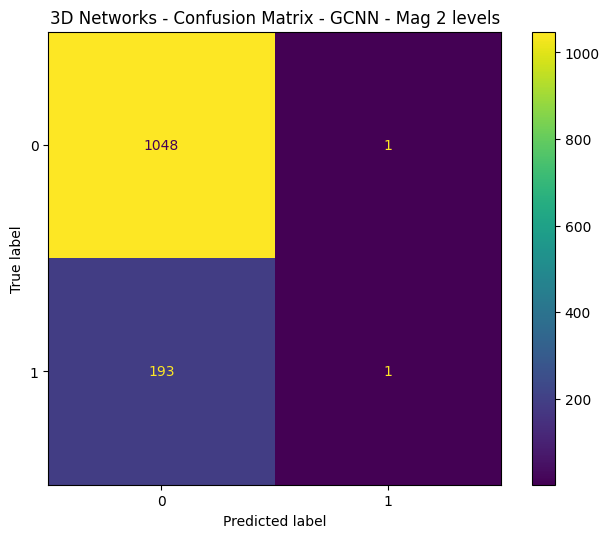

In [31]:
%%time

#nmag2
tipo="3d"

idx="nev50"
clase="nmag2"

batchtrain=50
batchtest=1
nrows=30
layer_dims=[30,30,30,4]
filters1=16
filters2=32
poolsize=2
ksize=8
units=128
activation1="relu"
activation2="softmax"
learnrate=0.0005
epochs=100


dfylabels=pd.DataFrame(dfvecsalidas[idx][clase].values,columns=["label"])
d1=dfvecsalidas[idx][clase].unique()
d1=list(d1)
d1.sort()

c=dfylabels.value_counts("label")

unout=len(c)

glabels = pd.get_dummies(dfylabels, drop_first=True)

train_graphs, test_graphs = model_selection.train_test_split(
    glabels, test_size=.2, stratify=dfylabels, random_state = 42
)


if tipo == "2d":
    gen = PaddedGraphGenerator(graphs=grafosstellars2dall[idx])
elif tipo == "3d":
    gen = PaddedGraphGenerator(graphs=grafosstellars3dall[idx])

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtrain,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtest,
)

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_dims,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=nrows,
    bias=False,
    generator=gen,
)

gnn_inp, gnn_out = dgcnn_model.in_out_tensors()

x_out = Conv1D(filters=filters1, kernel_size=sum(layer_dims), strides=sum(layer_dims))(gnn_out)
x_out = MaxPool1D(pool_size=poolsize)(x_out)
x_out = Conv1D(filters=filters2, kernel_size=ksize, strides=1)(x_out)
x_out = Flatten()(x_out)

x_out = Dense(units=units, activation=activation1)(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=unout, activation=activation2)(x_out)

modelnmag2 = Model(inputs=gnn_inp, outputs=predictions)
modelnmag2.compile(optimizer=Adam(lr=learnrate), loss=sparse_categorical_crossentropy, metrics=["accuracy"])

print("Empieza modelo con learnrate: ",learnrate)
ini=time.time()
history = modelnmag2.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

fin=time.time()
dif=fin-ini

predictlabels=modelnmag2.predict(test_gen)
predicted_labels=[]

for v in predictlabels:
    c=0
    a=v[0]
    for i in range(len(v)):
        if v[i] > a:
            a=v[i]
            c=i
    predicted_labels.append(c)

targets=test_graphs.values
conf_matrix=confusion_matrix(targets,predicted_labels)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=d1)
 
# set the plot title using the axes object
ax.set(title='3D Networks - Confusion Matrix - GCNN - Mag 2 levels')
 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

plt.savefig("CM-GCNN-Mag2-3D.svg",format="svg")

Empieza modelo con learnrate:  0.001
Epoch 1/100


/home/danileo/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


100/100 [==============================] - 3s 33ms/step - loss: 1.2335 - accuracy: 0.3001 - val_loss: 1.2303 - val_accuracy: 0.6702
Epoch 2/100
100/100 [==============================] - 3s 31ms/step - loss: 1.2125 - accuracy: 0.2967 - val_loss: 1.2053 - val_accuracy: 0.0217
Epoch 3/100
100/100 [==============================] - 3s 32ms/step - loss: 1.1987 - accuracy: 0.2295 - val_loss: 1.1900 - val_accuracy: 0.0861
Epoch 4/100
100/100 [==============================] - 3s 30ms/step - loss: 1.1887 - accuracy: 0.2713 - val_loss: 1.1906 - val_accuracy: 0.8866
Epoch 5/100
100/100 [==============================] - 3s 32ms/step - loss: 1.1885 - accuracy: 0.3414 - val_loss: 1.1834 - val_accuracy: 0.0949
Epoch 6/100
100/100 [==============================] - 3s 30ms/step - loss: 1.1897 - accuracy: 0.2269 - val_loss: 1.1941 - val_accuracy: 0.0660
Epoch 7/100
100/100 [==============================] - 3s 33ms/step - loss: 1.1860 - accuracy: 0.3039 - val_loss: 1.1790 - val_accuracy: 0.0434
Epoc

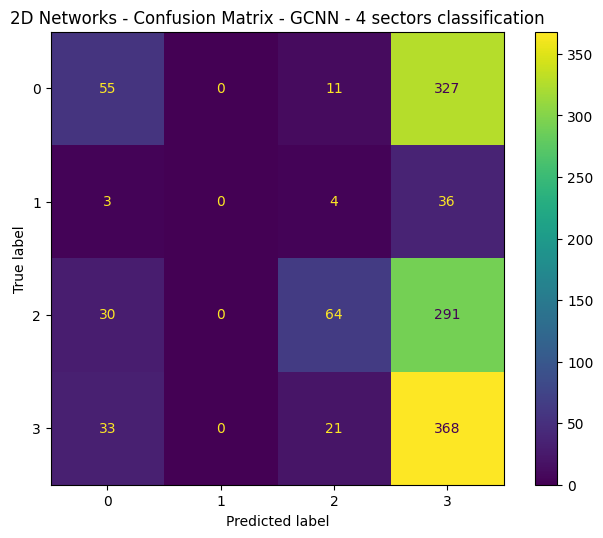

In [32]:
%%time

#clase4
tipo="2d"

idx="nev50"
clase="clase4"

batchtrain=50
batchtest=1
nrows=30
layer_dims=[30,30,30,4]
filters1=16
filters2=25
poolsize=2
ksize=8
units=128
activation1="relu"
activation2="softmax"
learnrate=0.001
epochs=100


dfylabels=pd.DataFrame(dfvecsalidas[idx][clase].values,columns=["label"])
d1=dfvecsalidas[idx][clase].unique()
d1=list(d1)
d1.sort()

c=dfylabels.value_counts("label")

unout=len(c)

glabels = pd.get_dummies(dfylabels, drop_first=True)

train_graphs, test_graphs = model_selection.train_test_split(
    glabels, test_size=.2, stratify=dfylabels, random_state = 42
)


if tipo == "2d":
    gen = PaddedGraphGenerator(graphs=grafosstellars2dall[idx])
elif tipo == "3d":
    gen = PaddedGraphGenerator(graphs=grafosstellars3dall[idx])

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtrain,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtest,
)

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_dims,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=nrows,
    bias=False,
    generator=gen,
)

gnn_inp, gnn_out = dgcnn_model.in_out_tensors()

x_out = Conv1D(filters=filters1, kernel_size=sum(layer_dims), strides=sum(layer_dims))(gnn_out)
x_out = MaxPool1D(pool_size=poolsize)(x_out)
x_out = Conv1D(filters=filters2, kernel_size=ksize, strides=1)(x_out)
x_out = Flatten()(x_out)

x_out = Dense(units=units, activation=activation1)(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=unout, activation=activation2)(x_out)

modelclase4 = Model(inputs=gnn_inp, outputs=predictions)
modelclase4.compile(optimizer=Adam(lr=learnrate), loss=sparse_categorical_crossentropy, metrics=["accuracy"])

print("Empieza modelo con learnrate: ",learnrate)
ini=time.time()
history = modelclase4.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

fin=time.time()
dif=fin-ini

predictlabels=modelclase4.predict(test_gen)
predicted_labels=[]

for v in predictlabels:
    c=0
    a=v[0]
    for i in range(len(v)):
        if v[i] > a:
            a=v[i]
            c=i
    predicted_labels.append(c)

targets=test_graphs.values
conf_matrix=confusion_matrix(targets,predicted_labels)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=d1)
 
# set the plot title using the axes object
ax.set(title='2D Networks - Confusion Matrix - GCNN - 4 sectors classification')
 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);
plt.savefig("CM-GCNN-4sectors-2D.svg",format="svg")

Empieza modelo con learnrate:  0.0005
Epoch 1/100


/home/danileo/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


100/100 [==============================] - 3s 32ms/step - loss: 1.4728 - accuracy: 0.3843 - val_loss: 1.4173 - val_accuracy: 0.7450
Epoch 2/100
100/100 [==============================] - 3s 31ms/step - loss: 1.4374 - accuracy: 0.4052 - val_loss: 1.4015 - val_accuracy: 0.0660
Epoch 3/100
100/100 [==============================] - 3s 30ms/step - loss: 1.4255 - accuracy: 0.3744 - val_loss: 1.3898 - val_accuracy: 0.1327
Epoch 4/100
100/100 [==============================] - 3s 31ms/step - loss: 1.4108 - accuracy: 0.3116 - val_loss: 1.3900 - val_accuracy: 0.9123
Epoch 5/100
100/100 [==============================] - 3s 31ms/step - loss: 1.3971 - accuracy: 0.3205 - val_loss: 1.4084 - val_accuracy: 0.7128
Epoch 6/100
100/100 [==============================] - 3s 33ms/step - loss: 1.3912 - accuracy: 0.2919 - val_loss: 1.3636 - val_accuracy: 0.1183
Epoch 7/100
100/100 [==============================] - 3s 33ms/step - loss: 1.3814 - accuracy: 0.2882 - val_loss: 1.3596 - val_accuracy: 0.1014
Epoc

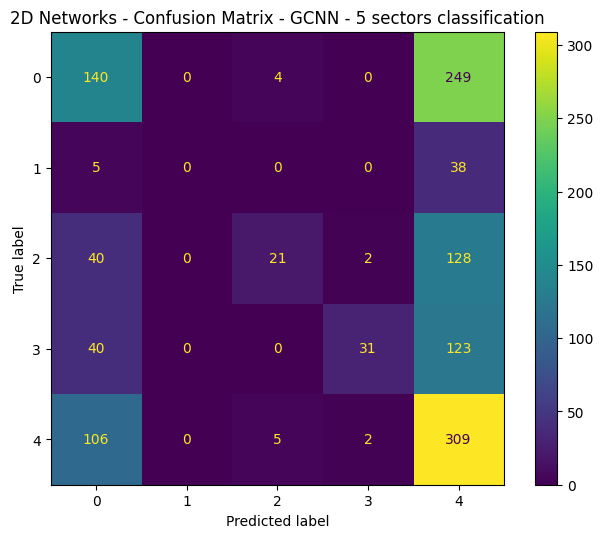

In [33]:
%%time

#clase5
tipo="2d"

idx="nev50"
clase="clase5"

batchtrain=50
batchtest=1
nrows=30
layer_dims=[30,30,30,4]
filters1=16
filters2=32
poolsize=2
ksize=8
units=128
activation1="relu"
activation2="softmax"
learnrate=0.0005
epochs=100


dfylabels=pd.DataFrame(dfvecsalidas[idx][clase].values,columns=["label"])
d1=dfvecsalidas[idx][clase].unique()
d1=list(d1)
d1.sort()

c=dfylabels.value_counts("label")

unout=len(c)

glabels = pd.get_dummies(dfylabels, drop_first=True)

train_graphs, test_graphs = model_selection.train_test_split(
    glabels, test_size=.2, stratify=dfylabels, random_state = 42
)


if tipo == "2d":
    gen = PaddedGraphGenerator(graphs=grafosstellars2dall[idx])
elif tipo == "3d":
    gen = PaddedGraphGenerator(graphs=grafosstellars3dall[idx])

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtrain,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    symmetric_normalization=False,
    batch_size=batchtest,
)

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_dims,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=nrows,
    bias=False,
    generator=gen,
)

gnn_inp, gnn_out = dgcnn_model.in_out_tensors()

x_out = Conv1D(filters=filters1, kernel_size=sum(layer_dims), strides=sum(layer_dims))(gnn_out)
x_out = MaxPool1D(pool_size=poolsize)(x_out)
x_out = Conv1D(filters=filters2, kernel_size=ksize, strides=1)(x_out)
x_out = Flatten()(x_out)

x_out = Dense(units=units, activation=activation1)(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=unout, activation=activation2)(x_out)

modelclase5 = Model(inputs=gnn_inp, outputs=predictions)
modelclase5.compile(optimizer=Adam(lr=learnrate), loss=sparse_categorical_crossentropy, metrics=["accuracy"])

print("Empieza modelo con learnrate: ",learnrate)
ini=time.time()
history = modelclase5.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

fin=time.time()
dif=fin-ini

predictlabels=modelclase5.predict(test_gen)
predicted_labels=[]

for v in predictlabels:
    c=0
    a=v[0]
    for i in range(len(v)):
        if v[i] > a:
            a=v[i]
            c=i
    predicted_labels.append(c)

targets=test_graphs.values
conf_matrix=confusion_matrix(targets,predicted_labels)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=d1)
 
# set the plot title using the axes object
ax.set(title='2D Networks - Confusion Matrix - GCNN - 5 sectors classification')
 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

plt.savefig("CM-GCNN-5sectors-2D.svg",format="svg")


# Regression

In [7]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [8]:
%%time

vsalidassigs={}
lnsiguientes=[10,20]

for neventos in listaneventos:

    for nsiguientes in lnsiguientes:

        tammuestrassiguientes=len(catalogo)-neventos-nsiguientes-1
        print(neventos,nsiguientes,len(catalogo),tammuestrassiguientes)
        vecsalidassiguientes=[]

        for i in range(tammuestrassiguientes):
            posmuestra=i+neventos
            energia=catalogo.energia[posmuestra:posmuestra+nsiguientes].sum()
            tini=catalogo.epochs.values[i+neventos]
            tfin=catalogo.epochs.values[i+neventos+nsiguientes-1]
            #sismicidad de siguientes nsiguientes eventos
            sismi=np.log(energia/(tfin-tini))
            vecsalidassiguientes.append(sismi)
        vsalidassigs["nev"+str(neventos)+"-nsig"+str(nsiguientes)]=vecsalidassiguientes

dfvecsalidassigs={}

for k, vecs in vsalidassigs.items():
    dfvecsalidassigs[k]=pd.DataFrame(vecs,columns=["sismicidad"])


10 10 6262 6241
10 20 6262 6231
50 10 6262 6201
50 20 6262 6191
100 10 6262 6151
100 20 6262 6141
CPU times: user 4.3 s, sys: 16 ms, total: 4.32 s
Wall time: 4.32 s


Sismicidad

# PRUEBAS

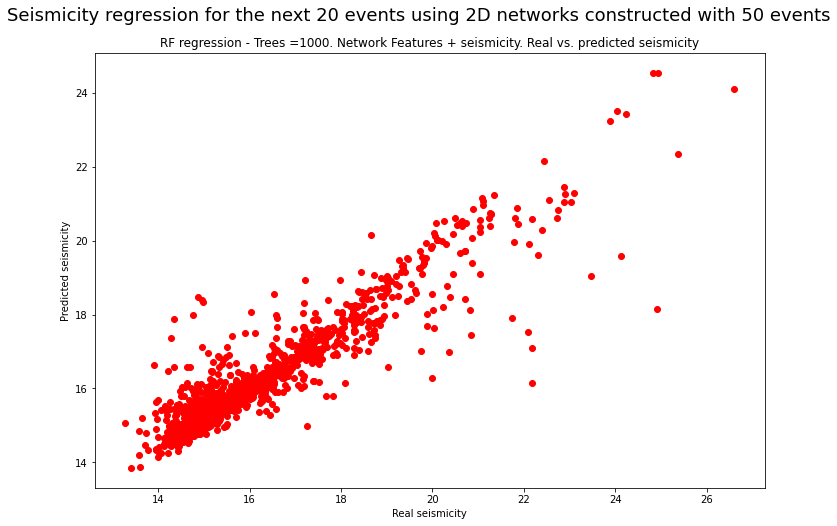

0.4751332596953107 0.6308757690640455 0.8327154080617288 0.028382806437526158
CPU times: user 1min 3s, sys: 297 ms, total: 1min 3s
Wall time: 1min 3s


In [49]:
%%time

n1=50
idx="nev"+str(n1)
sig=20
target="sismicidad"
c=1000

indice=idx+"-nsig"+str(sig)
y=dfvecsalidassigs[indice][target]
xmod=dfvecs2d[idx][0:len(y)].drop(columns=["Unnamed: 0"])

Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
regressor.fit(Xtrain,ytrain)
prediccion=regressor.predict(Xtest)

fig=plt.figure(figsize=(12,8))
plt.plot(ytest, prediccion, 'or')
plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
plt.title("RF regression - Trees ="+str(c)+". Network Features + seismicity. Real vs. predicted seismicity")
plt.xlabel("Real seismicity")
plt.ylabel("Predicted seismicity")
#plt.savefig("2Dfull-seismicity-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
plt.show()

mae = mean_absolute_error(ytest, prediccion)
mse = mean_squared_error(ytest, prediccion)
r2 = r2_score(ytest, prediccion)
mape = mean_absolute_percentage_error(ytest, prediccion)
print(mae,mse,r2,mape)
#metricasregresionsigrf.append(["RF","2d","inputfull",idx,sig,target,c,mae,mse,mape,r2])



In [48]:
xmod.columns

Index(['Unnamed: 0', 'nodos', 'edges', 'grad', 'clus', 'path', 'ent', 'sw',
       'bet', 'energia', 'dtdias', 'sismicidad'],
      dtype='object')

In [11]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=20)

idx="nev50"
sig=20
target="sismicidad"
c=1000

indice=idx+"-nsig"+str(sig)
y=dfvecsalidassigs[indice][target]
xmod=dfvecs2d[idx][0:len(y)]

regressor = RandomForestRegressor(n_estimators=100,oob_score=True)
scores=cross_val_score(regressor,xmod,y,scoring="r2",cv=kf)

#regressor = SVR(kernel='rbf',C=c)
#regressor.fit(xmod,y)
#prediccion=regressor.predict(xmod)


CPU times: user 1min 39s, sys: 631 ms, total: 1min 39s
Wall time: 1min 40s


In [35]:
scores

array([  0.24902455,  -0.52558964,  -0.15835471,  -1.45051216,
        -0.30699447,  -2.32115059,   0.13235301,  -1.06866855,
         0.0851495 ,  -3.10806075,  -0.12523472,  -0.52556436,
        -0.45581575,  -0.5414998 ,  -0.39279653,  -0.34630796,
        -0.43893016,  -0.98437558,  -0.20204385, -13.18298281])

In [ ]:
regressor = RandomForestRegressor(n_estimators=100,oob_score=True)


scores=cross_val_score(regressor,xmod,y,scoring="r2",cv=kf)

In [9]:
%%time

idx="nev50"
sig=20
target="sismicidad"
c=1000

indice=idx+"-nsig"+str(sig)
y=dfvecsalidassigs[indice][target]
xmod=dfvecs2d[idx][0:len(y)]

regressor = SVR(kernel='rbf',C=c)
regressor.fit(xmod,y)
prediccion=regressor.predict(xmod)

#fig=plt.figure(figsize=(12,8))
#plt.plot(dfvecsalidas[idx][target], color = 'green')
#plt.plot(prediccion, color = 'blue')
#plt.title(idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))

mae = mean_absolute_error(y, prediccion)
mse = mean_squared_error(y, prediccion)
r2 = r2_score(y, prediccion)
mape = mean_absolute_percentage_error(y, prediccion)
#metricasregresionsigsvr.append(["SVR","2d","inputfull",idx,sig,target,c,mae,mse,mape,r2])



CPU times: user 4.49 s, sys: 47.8 ms, total: 4.54 s
Wall time: 5.19 s


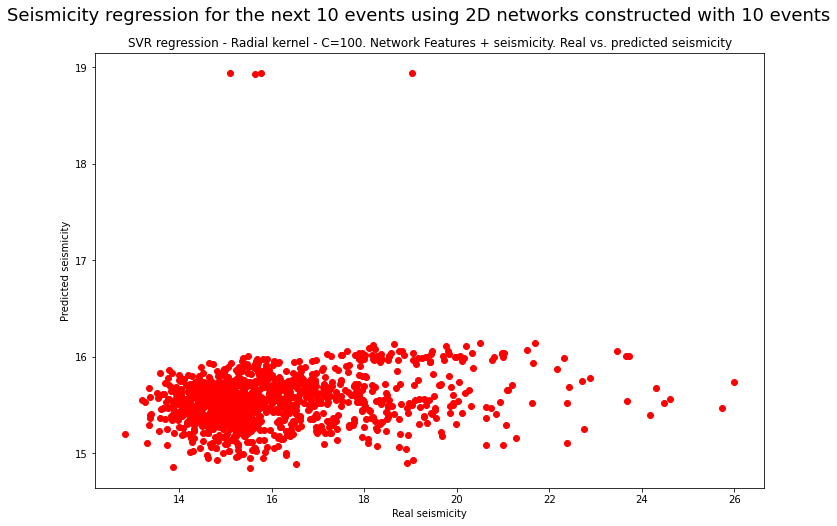

<Figure size 432x288 with 0 Axes>

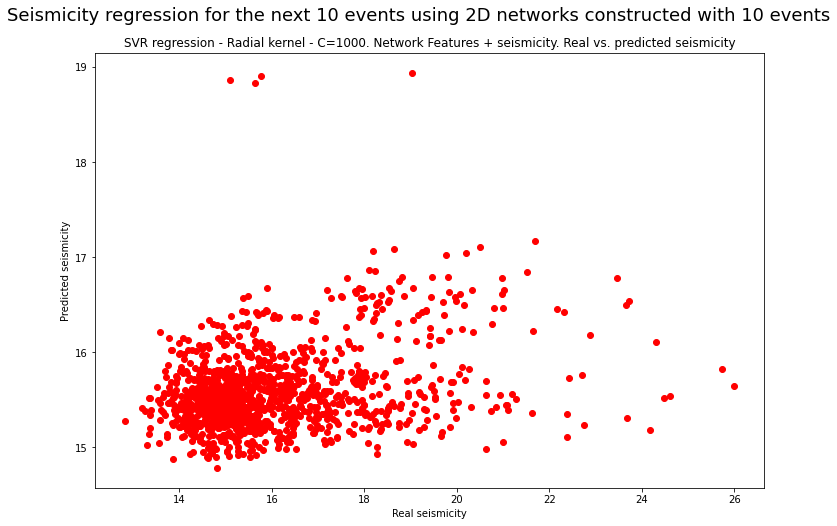

<Figure size 432x288 with 0 Axes>

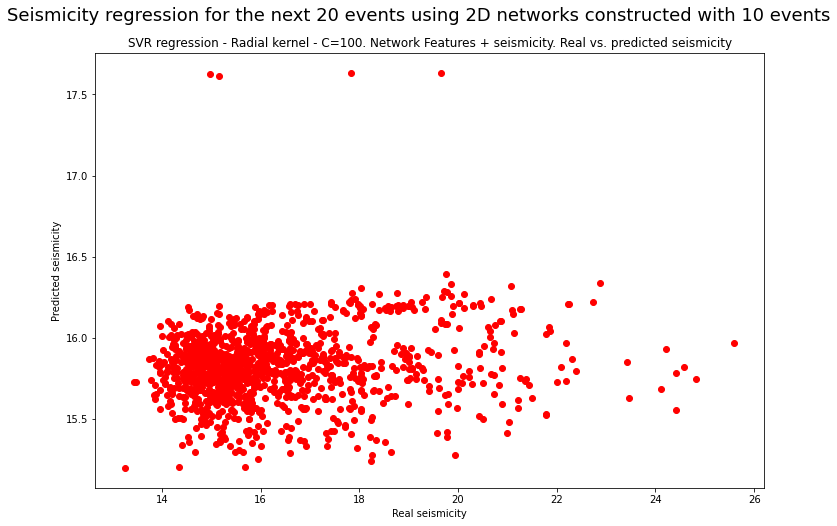

<Figure size 432x288 with 0 Axes>

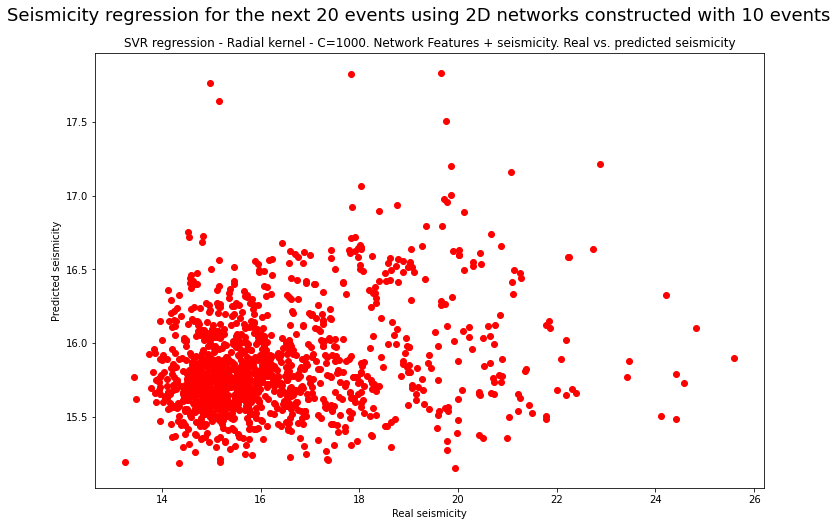

<Figure size 432x288 with 0 Axes>

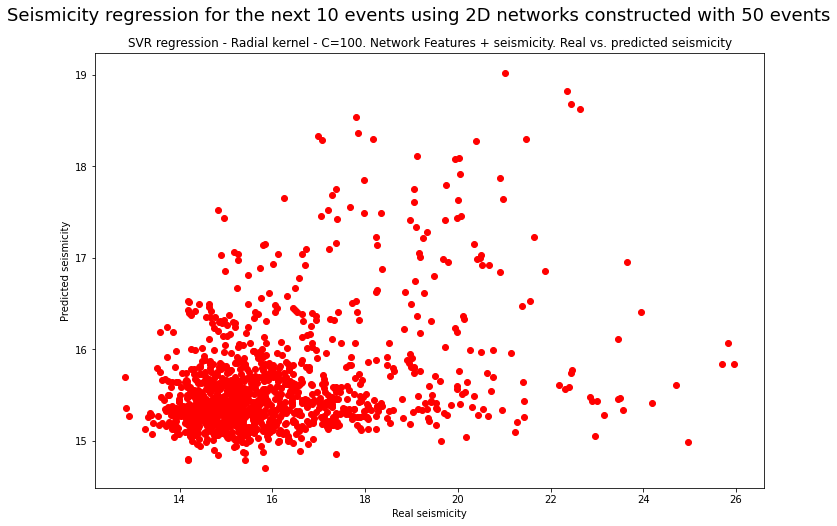

<Figure size 432x288 with 0 Axes>

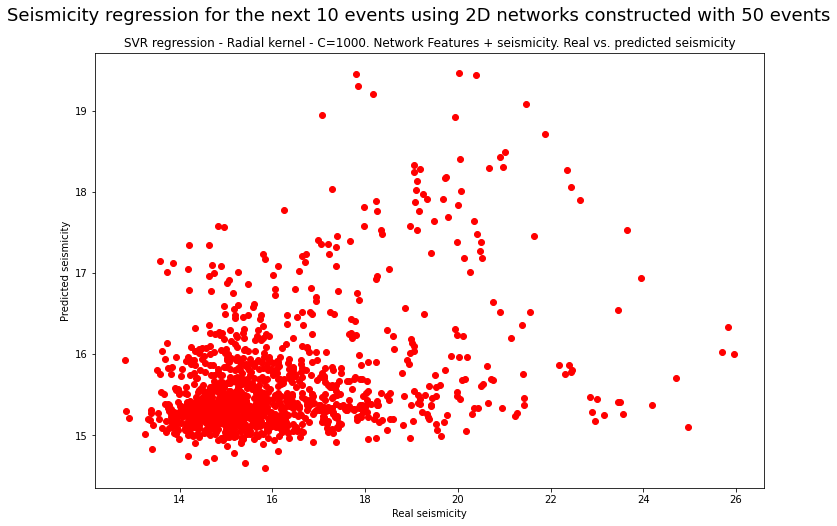

<Figure size 432x288 with 0 Axes>

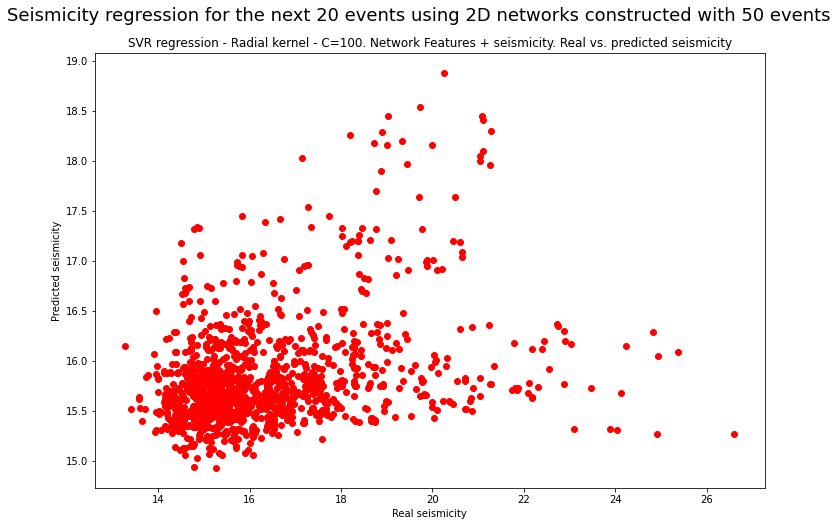

<Figure size 432x288 with 0 Axes>

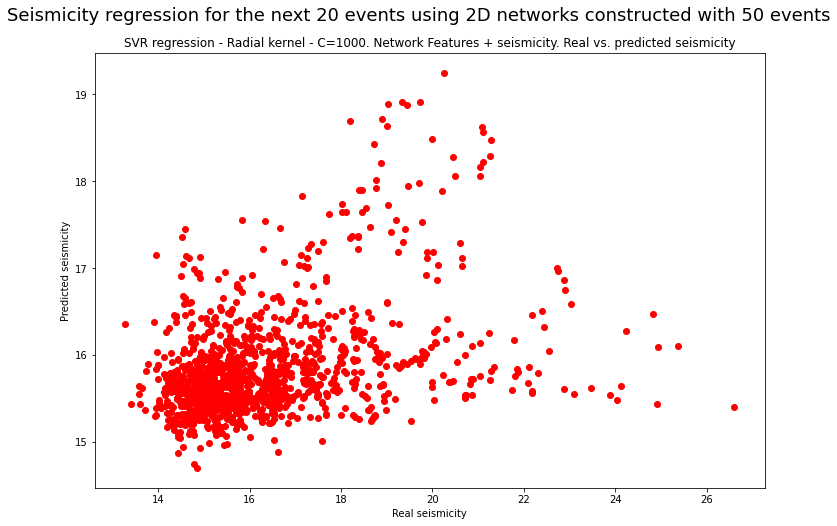

<Figure size 432x288 with 0 Axes>

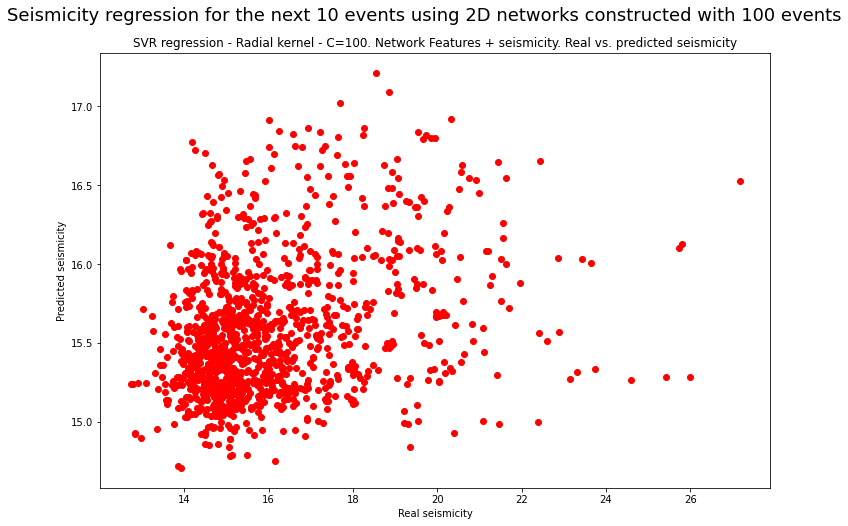

<Figure size 432x288 with 0 Axes>

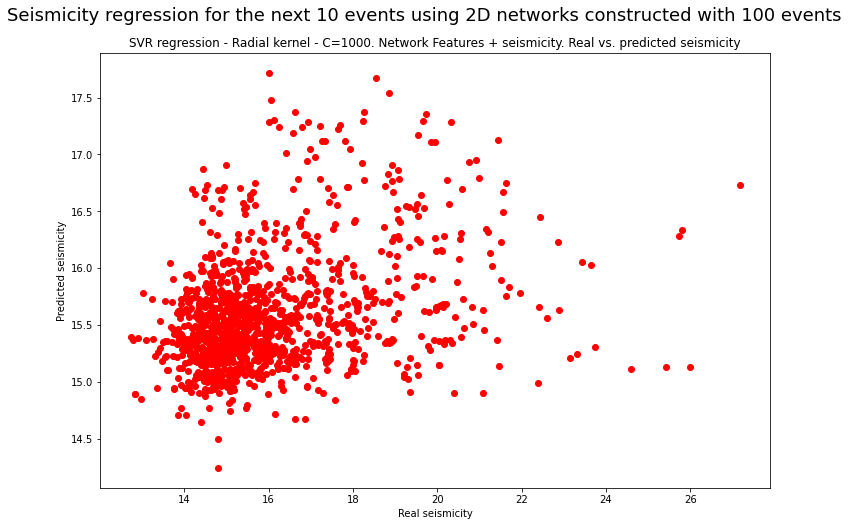

<Figure size 432x288 with 0 Axes>

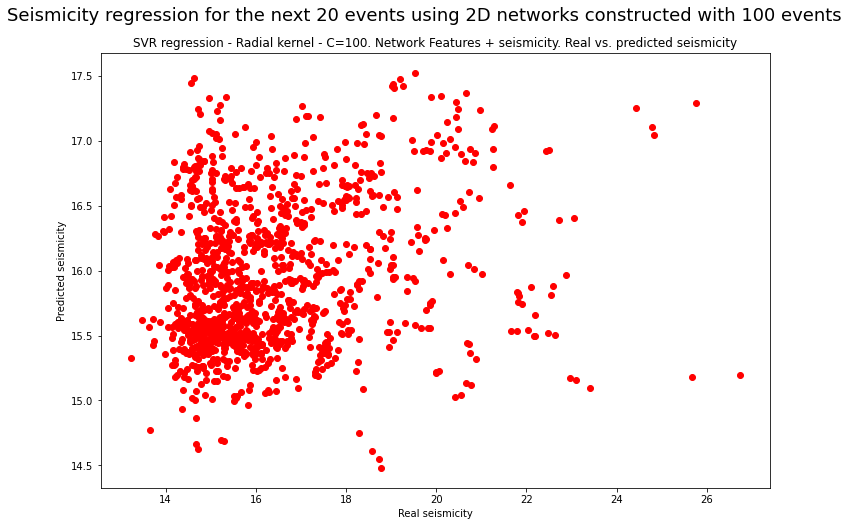

<Figure size 432x288 with 0 Axes>

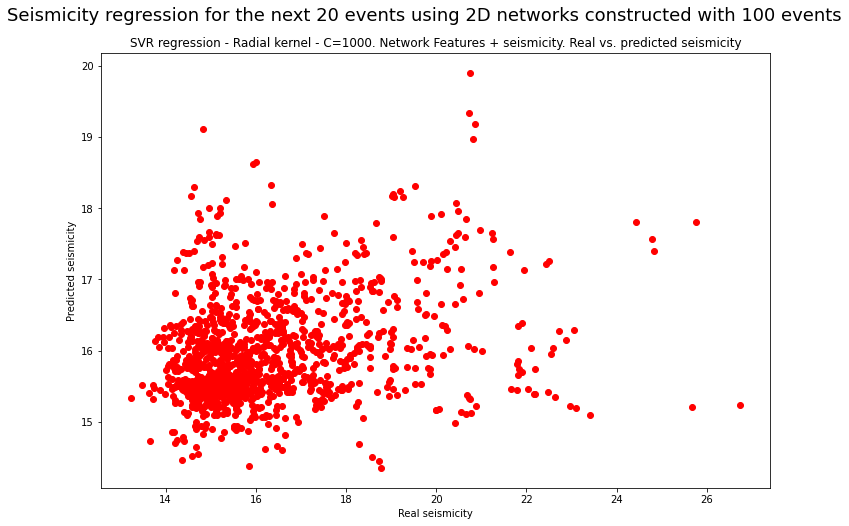

<Figure size 432x288 with 0 Axes>

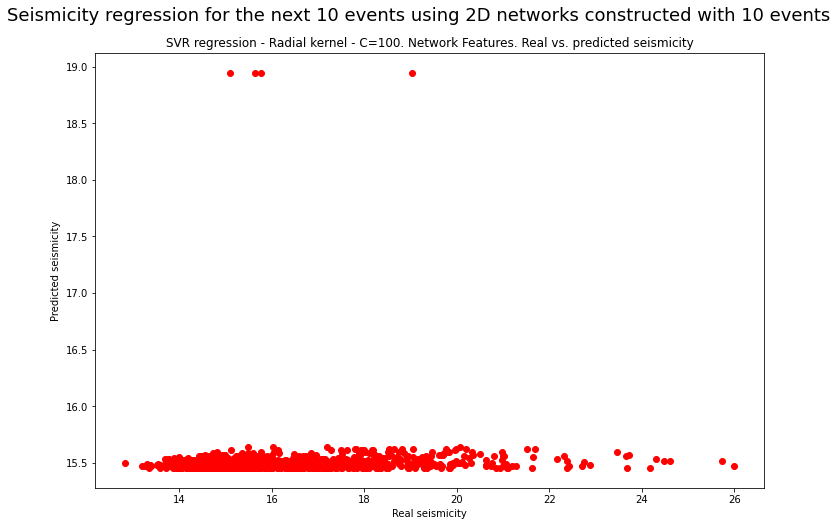

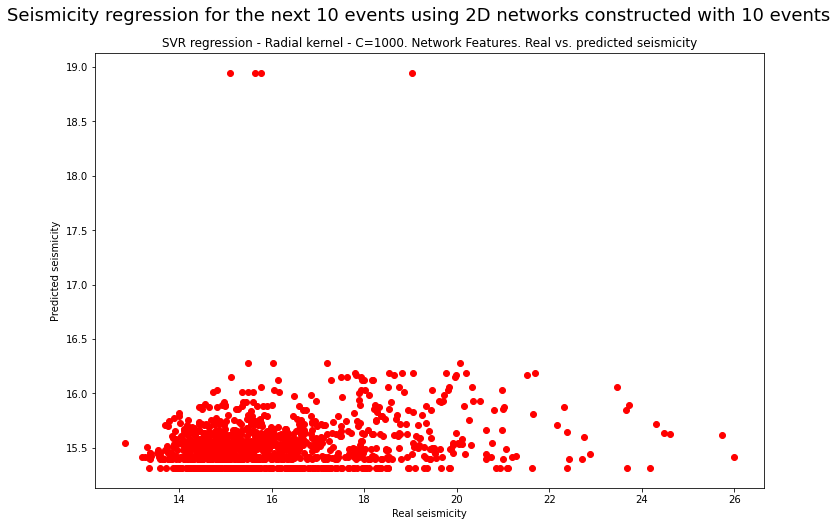

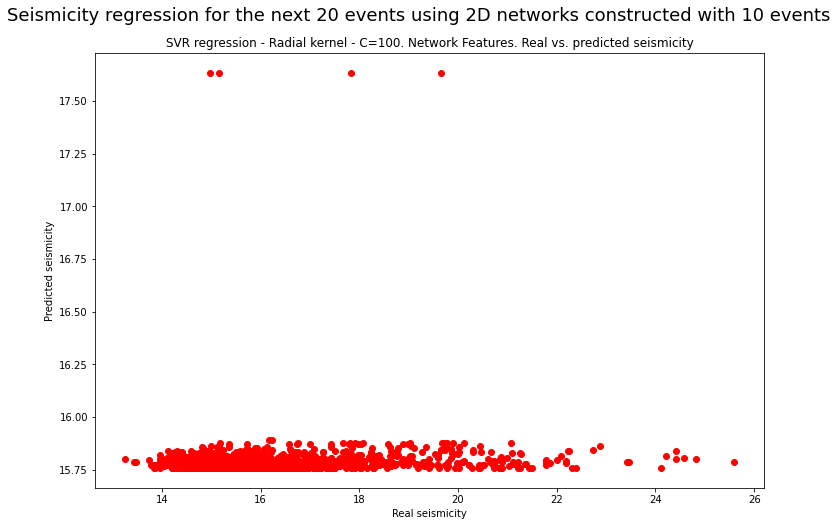

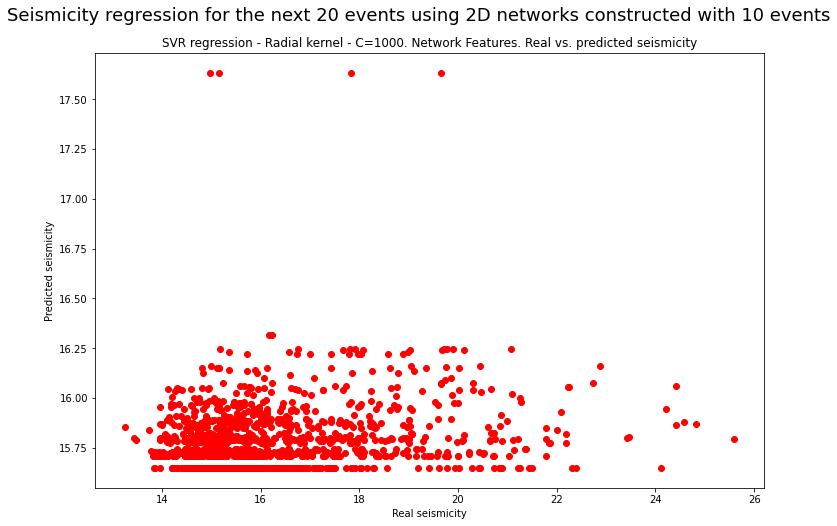

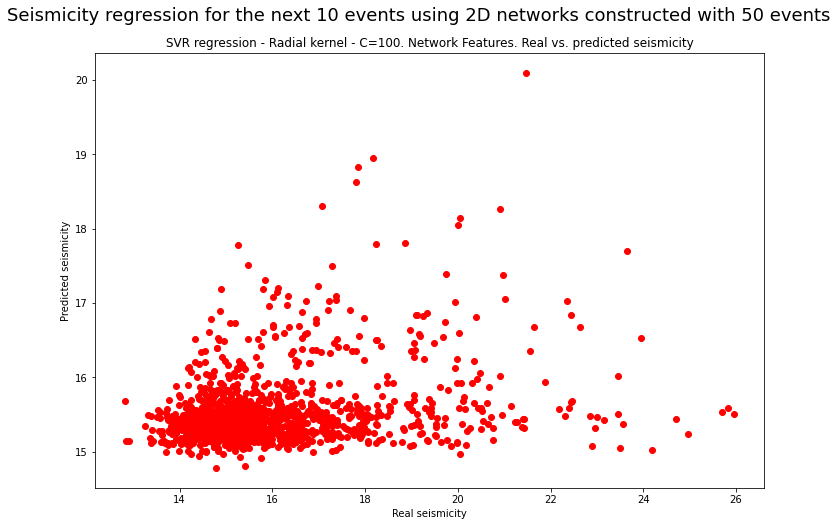

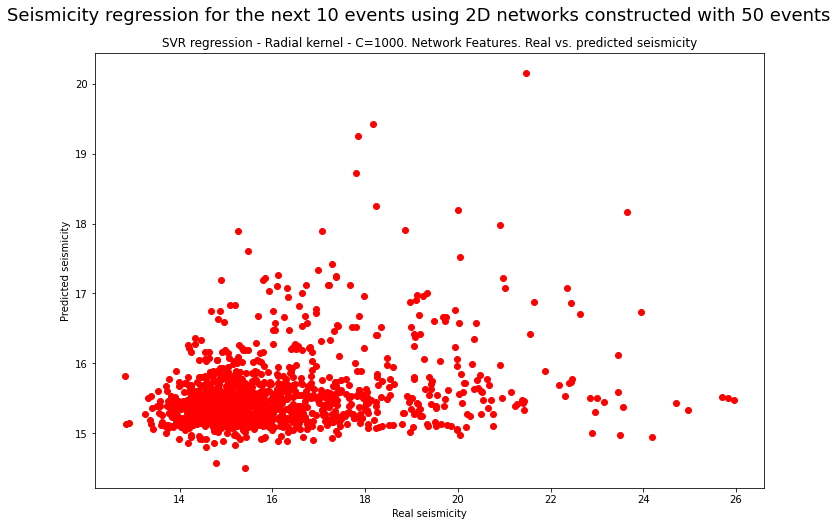

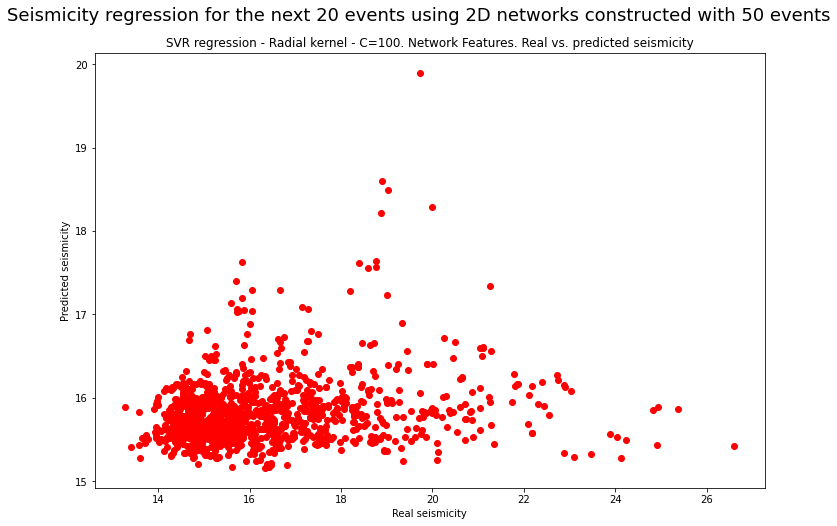

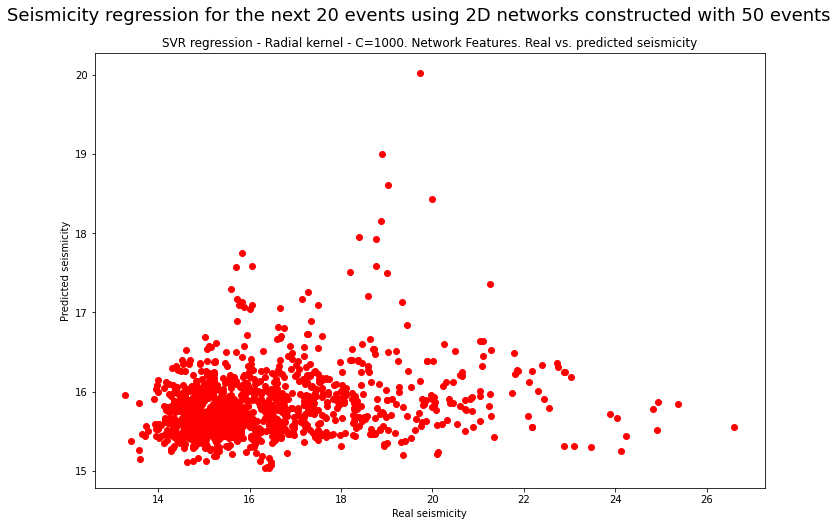

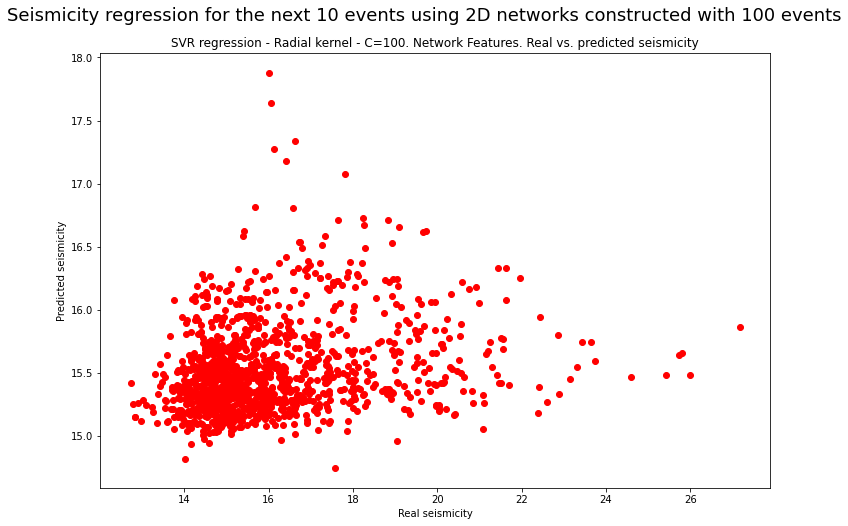

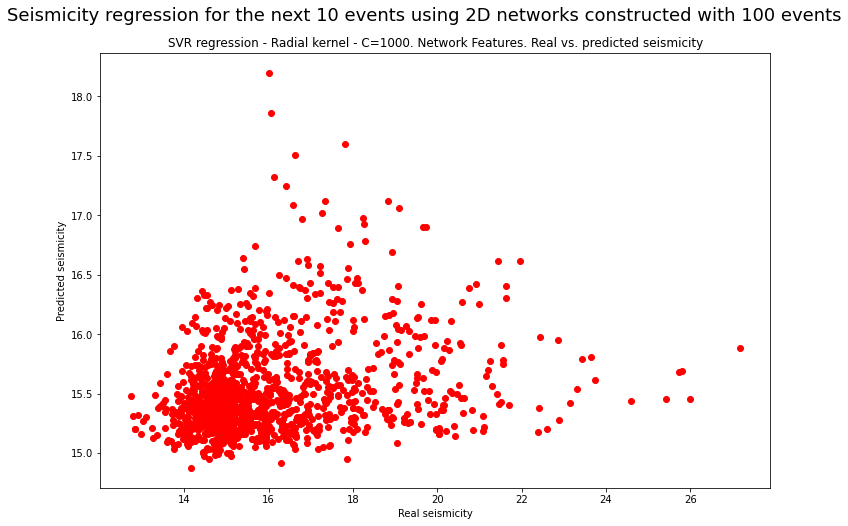

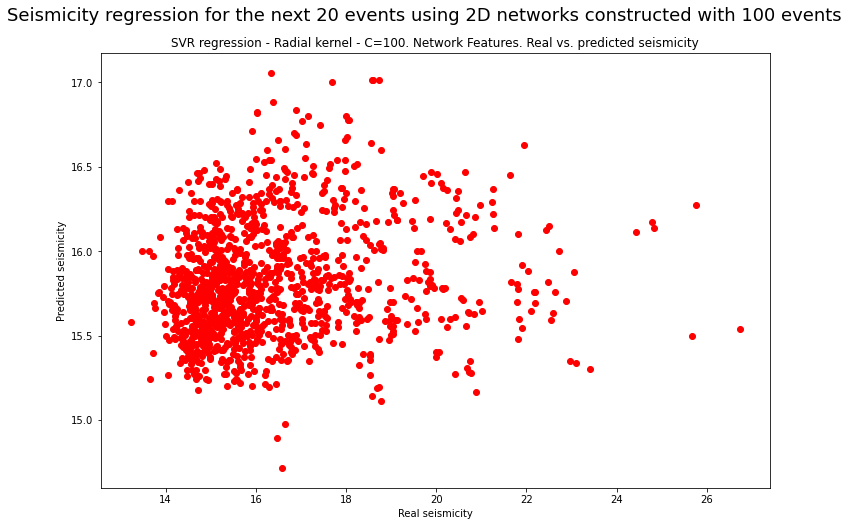

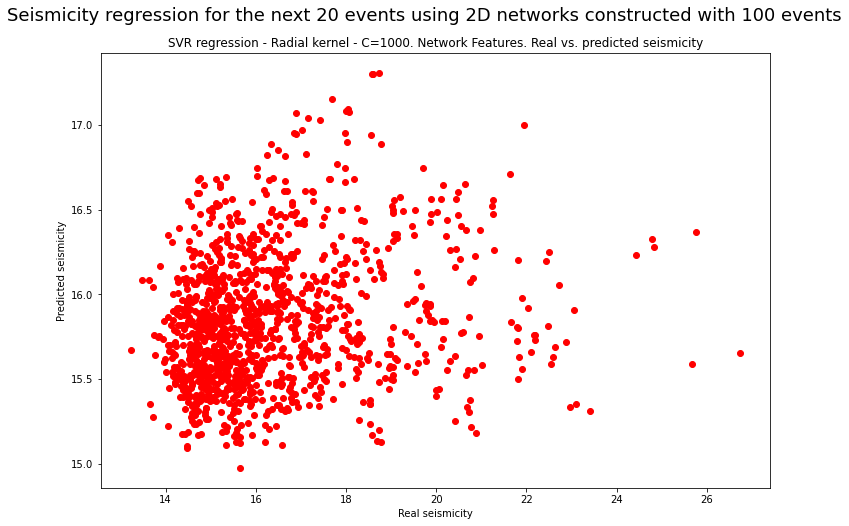

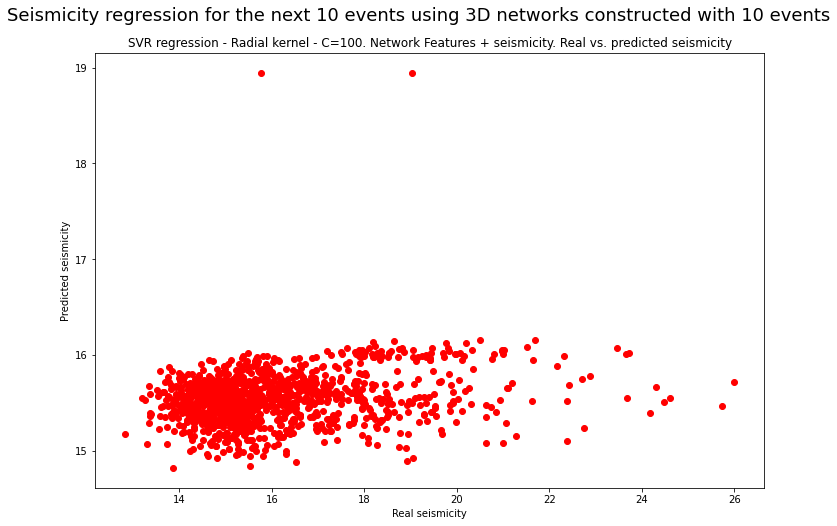

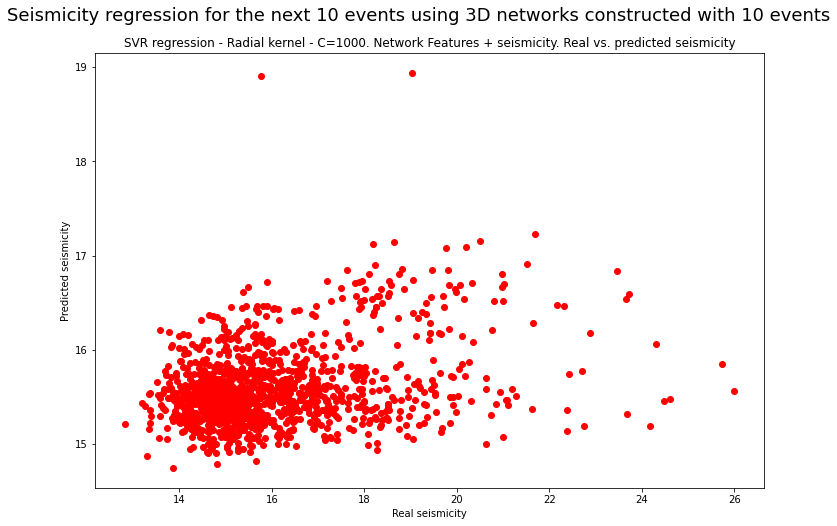

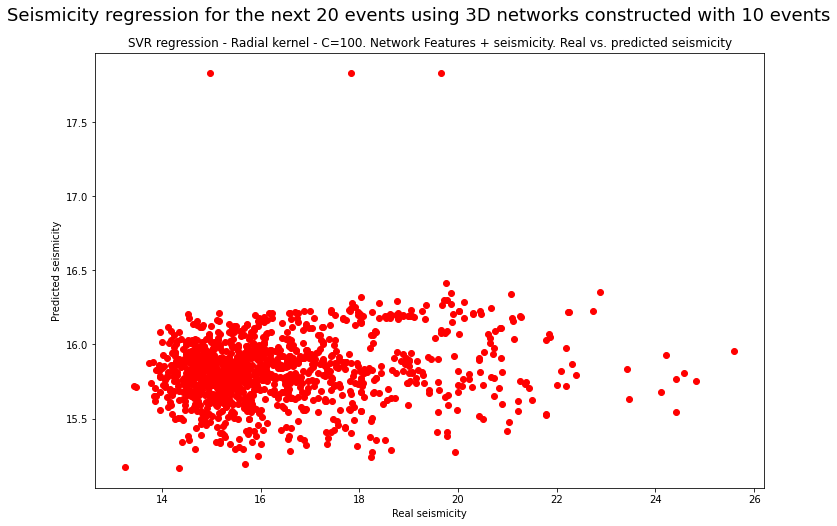

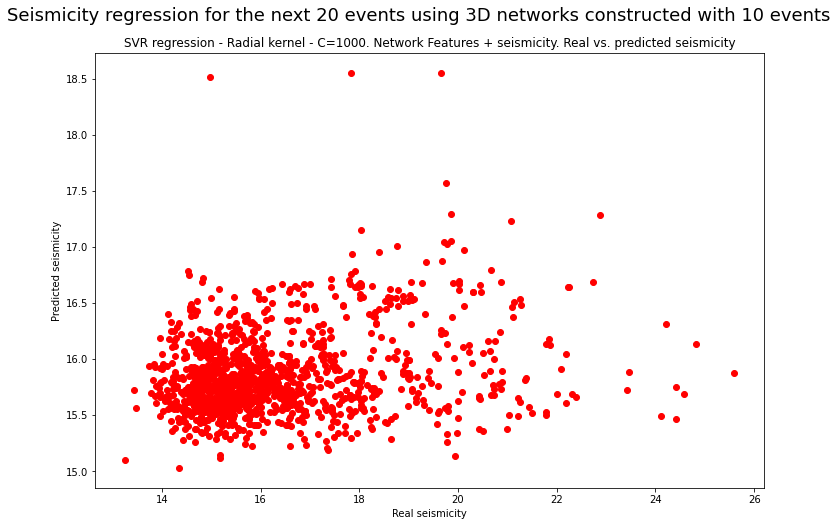

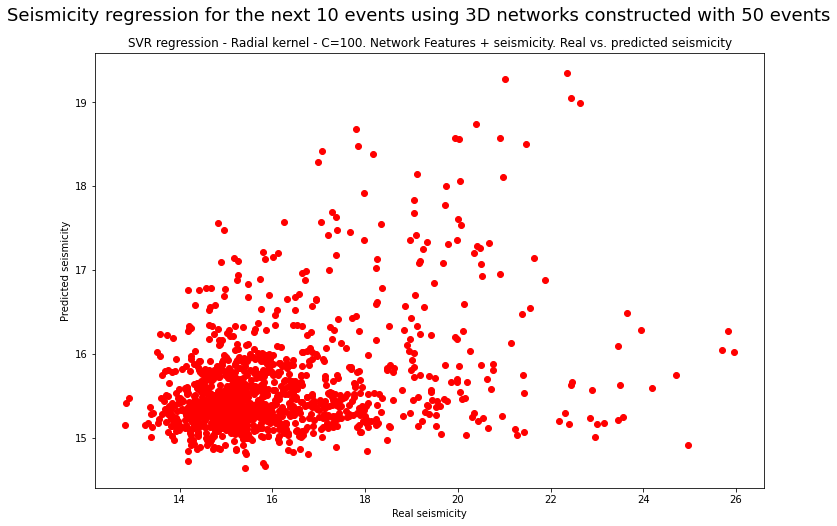

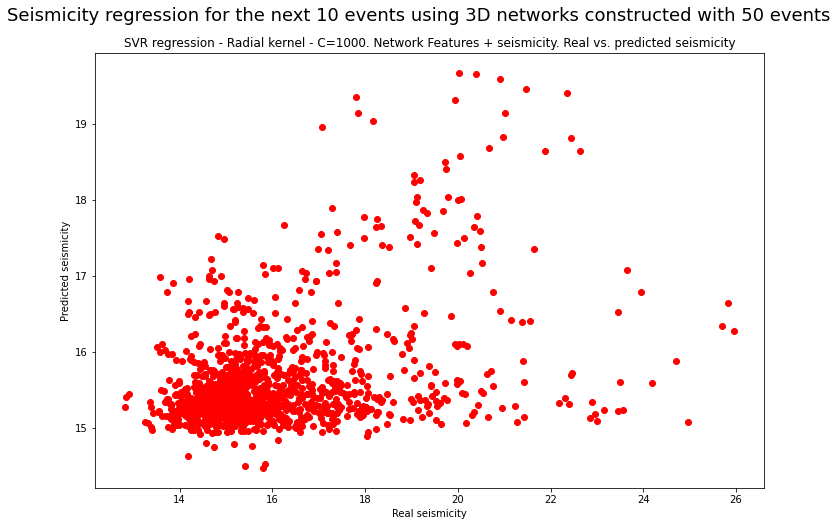

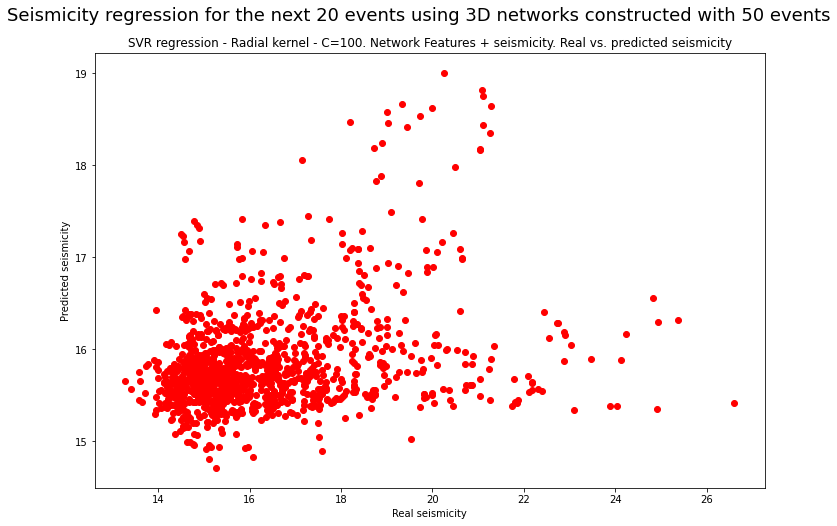

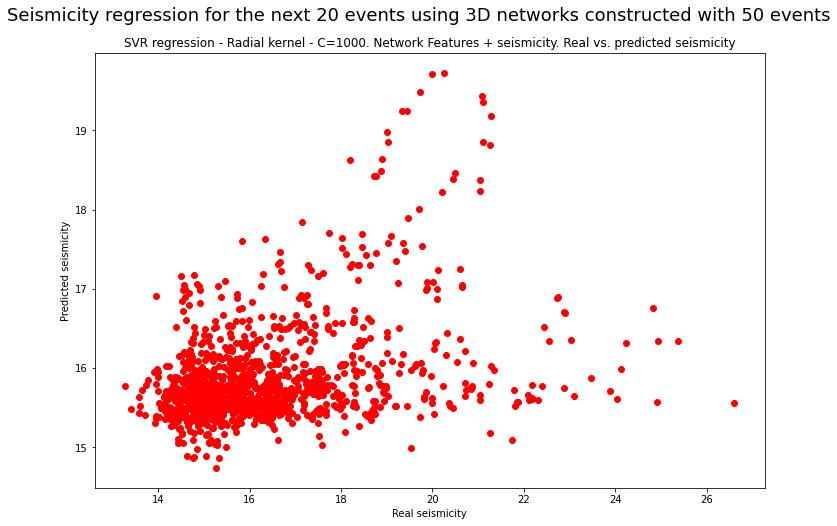

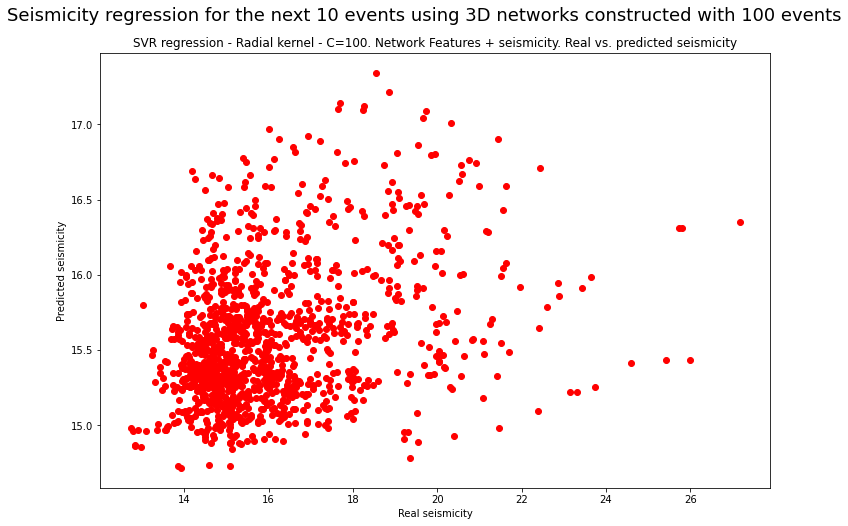

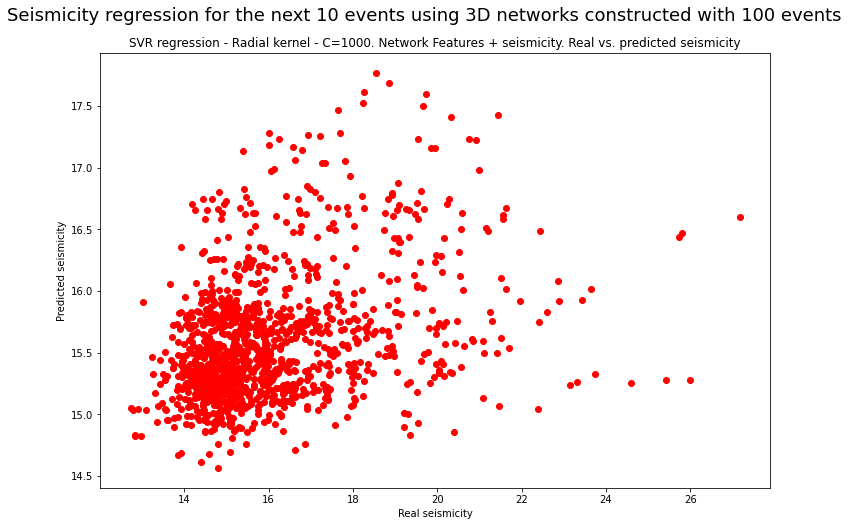

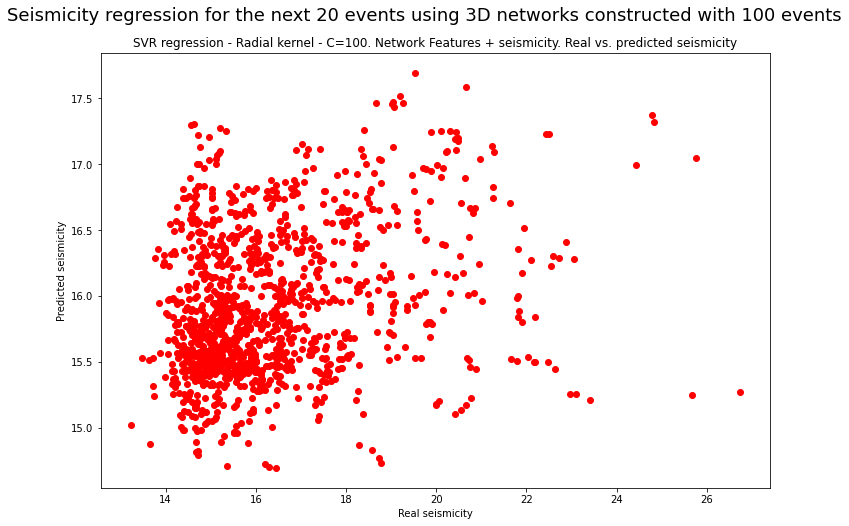

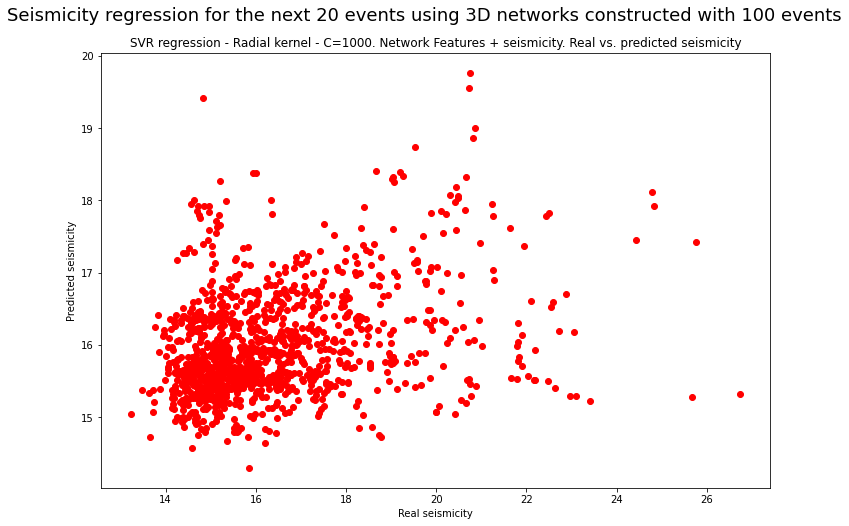

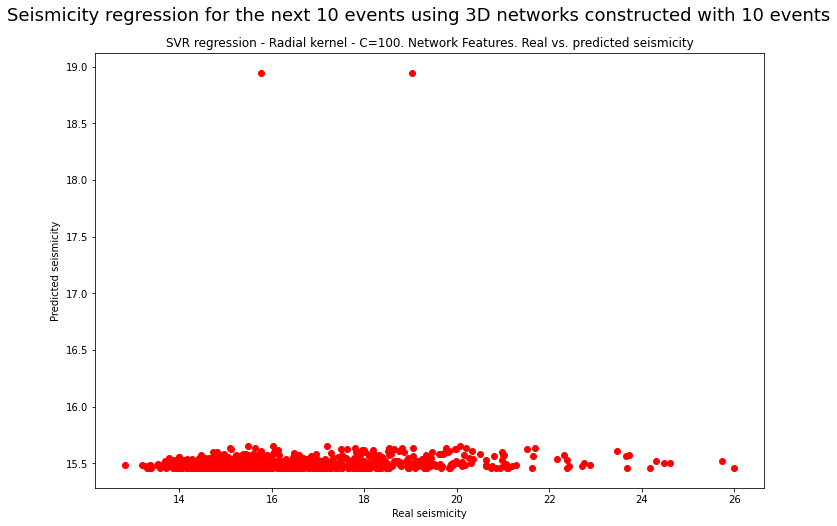

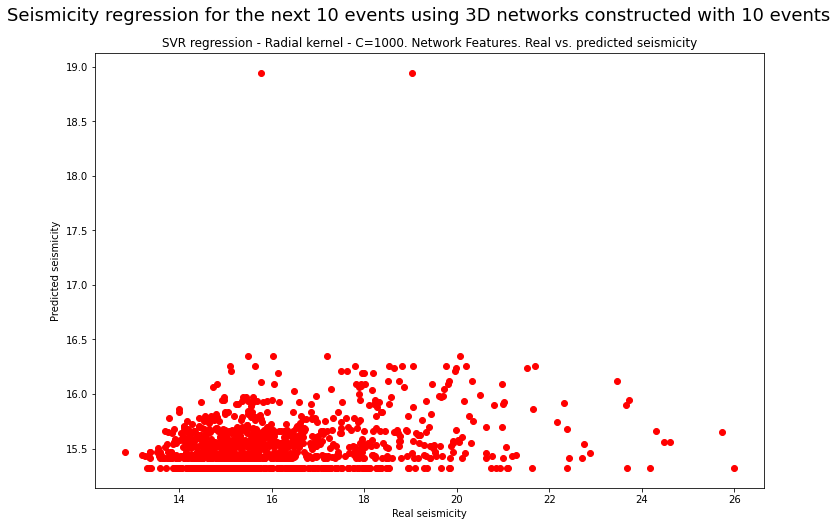

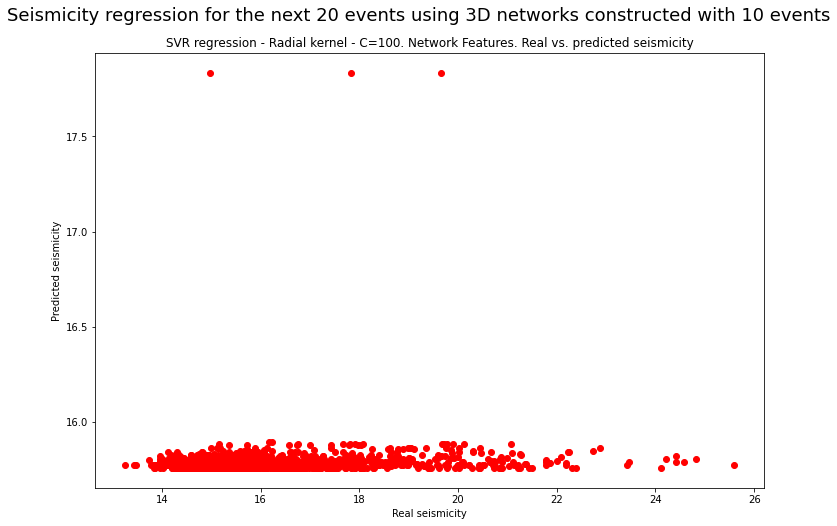

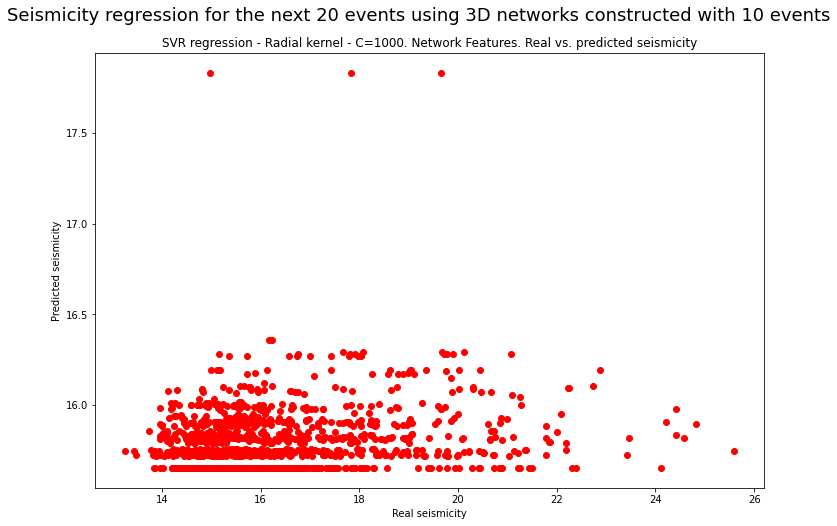

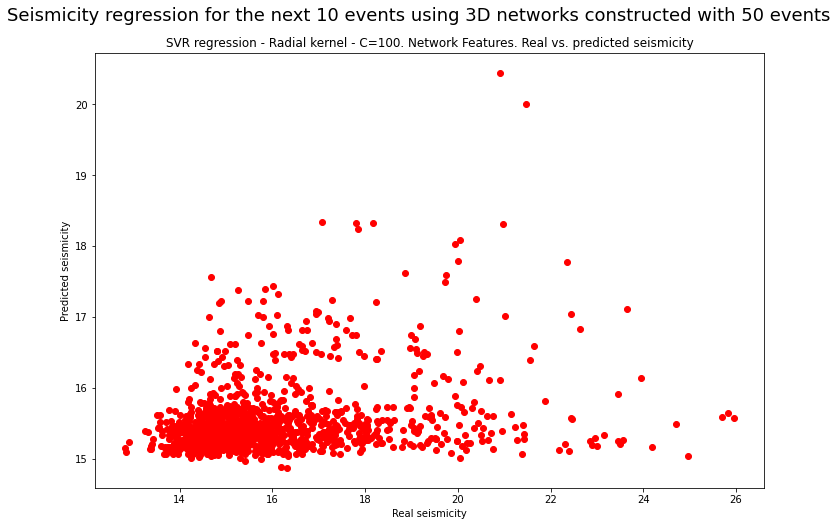

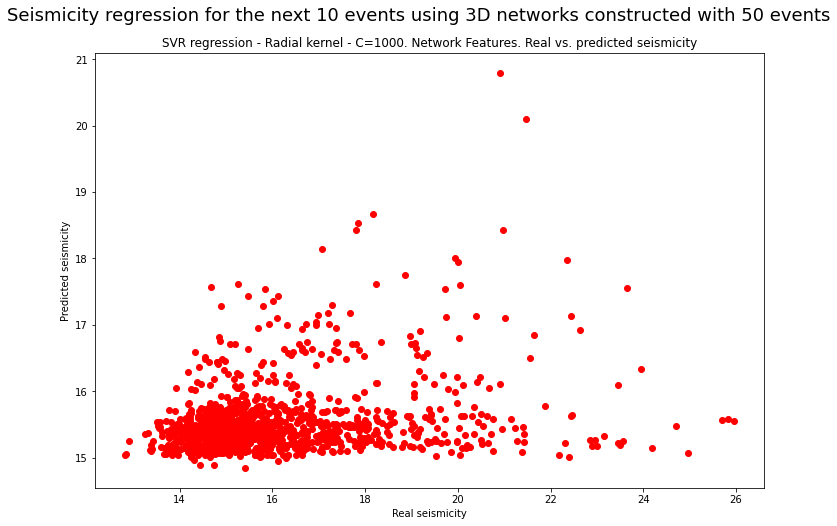

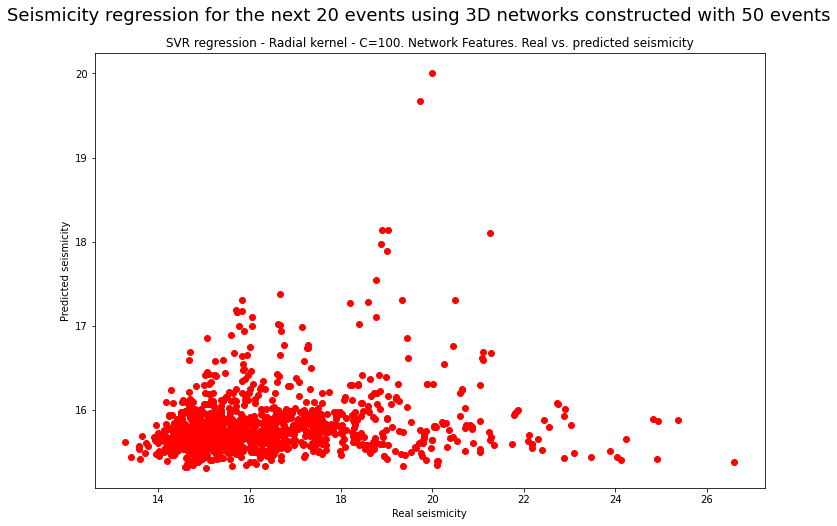

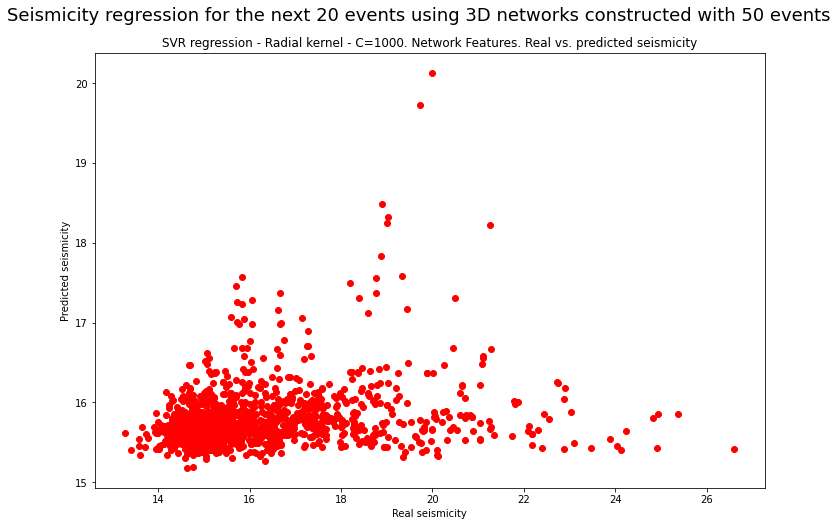

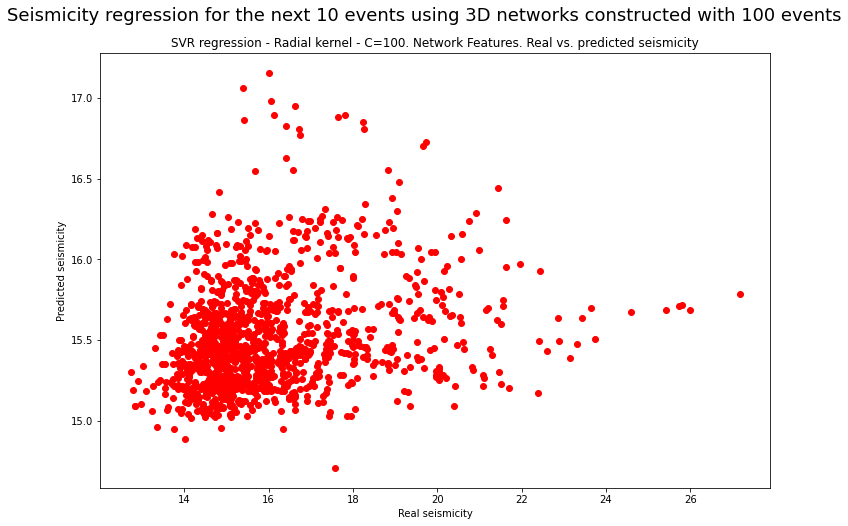

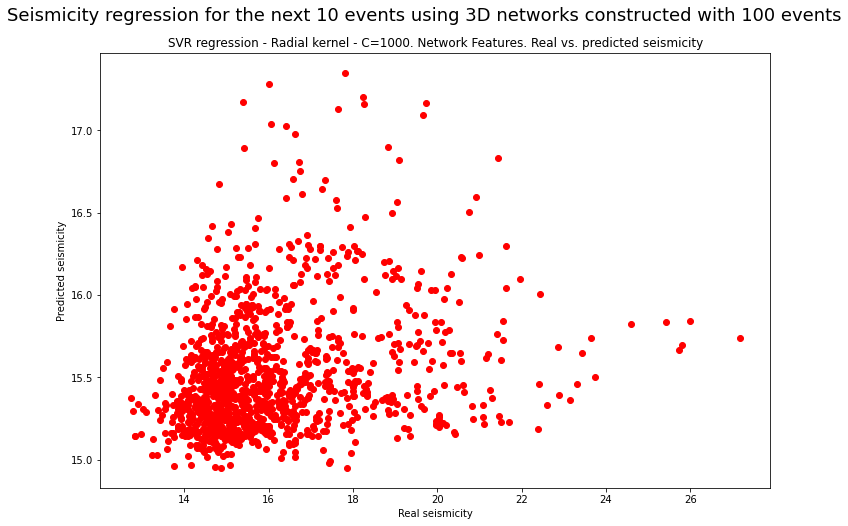

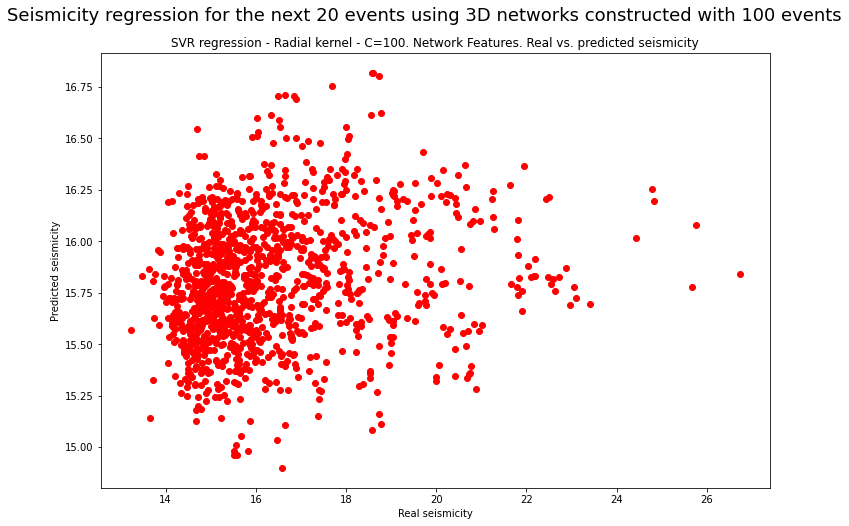

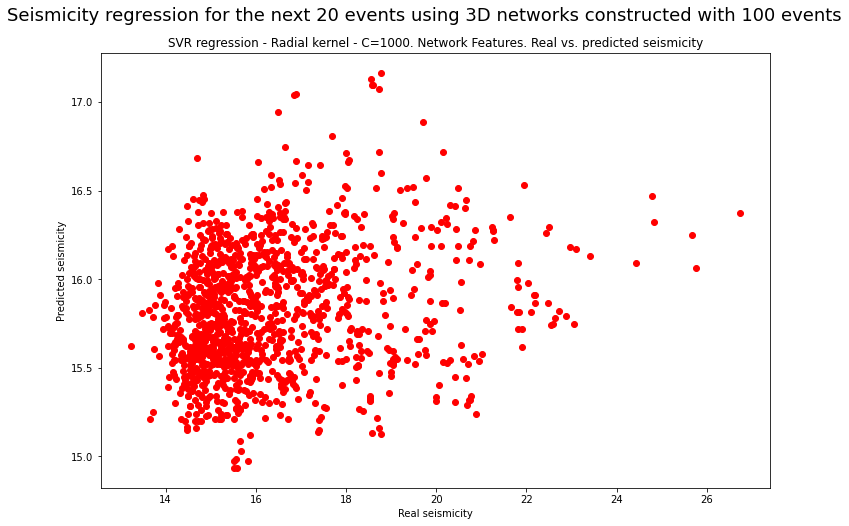

CPU times: user 1min 58s, sys: 7.65 s, total: 2min 5s
Wall time: 2min 18s


In [50]:
%%time

#Support vector machine para sismicidad

metricasregresionsigsvr=[]



#if tipo == "2D":
#    Xtrain, Xtest, ytrain, ytest = train_test_split(dfvecs2d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)
#else:
#    Xtrain, Xtest, ytrain, ytest = train_test_split(dfvecs3d[idx][0:len(dfvecsalidas[idx])], dfvecsalidas[idx][clase], test_size=0.2, random_state=42)



#2D full
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs2d[idx][0:len(y)].drop(columns=["Unnamed: 0"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
                
                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features + seismicity. Real vs. predicted seismicity")
                #idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))
                #plt.suptitle(title_string, y=1.05, fontsize=18)                plt.xlabel("Real seismicity")
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.show()
                plt.savefig("2Dfull-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigsvr.append(["SVR","2d","inputfull",idx,sig,target,c,mae,mse,mape,r2])

#2D solo network features
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs2d[idx][0:len(y)].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)

                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features. Real vs. predicted seismicity")
                
                #plt.title(idx+" 2D network features - Output vs prediction - "+target+" - SVR regression C="+str(c))
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("2Dmod-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigsvr.append(["SVR","2d","inputmod",idx,sig,target,c,mae,mse,mape,r2])

#3D full
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs3d[idx][0:len(y)].drop(columns=["Unnamed: 0"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)

                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features + seismicity. Real vs. predicted seismicity")
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("3Dfull-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigsvr.append(["SVR","3d","inputfull",idx,sig,target,c,mae,mse,mape,r2])

#3D mod
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs3d[idx][0:len(y)].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
                
                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features. Real vs. predicted seismicity")
                
                #plt.title(idx+" 2D network features - Output vs prediction - "+target+" - SVR regression C="+str(c))
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("3Dmod-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigsvr.append(["SVR","3d","inputmod",idx,sig,target,c,mae,mse,mape,r2])


dfmetricasregresionsigsvr=pd.DataFrame(metricasregresionsigsvr,columns=["Algorithm","NetworkType","InputType","Nevs","Nsigs","Target","Cost","MAE","MSE","MAPE","R2"])
dfmetricasregresionsigsvr.to_csv("dfmetricasregresionsigsvr.csv")

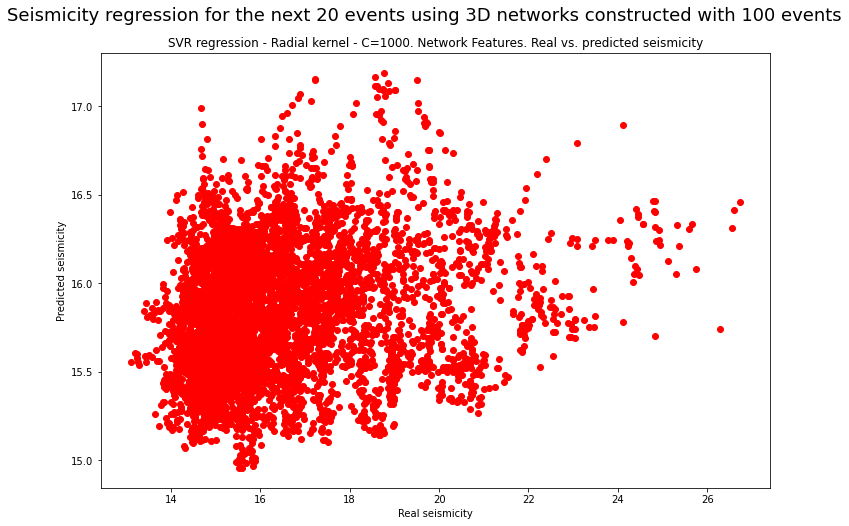

In [16]:
fig=plt.figure(figsize=(12,8))
plt.plot(y, prediccion, 'or')
plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features. Real vs. predicted seismicity")

#plt.title(idx+" 2D network features - Output vs prediction - "+target+" - SVR regression C="+str(c))
plt.xlabel("Real seismicity")
plt.ylabel("Predicted seismicity")
plt.savefig("test.svg",format="svg")
plt.show()


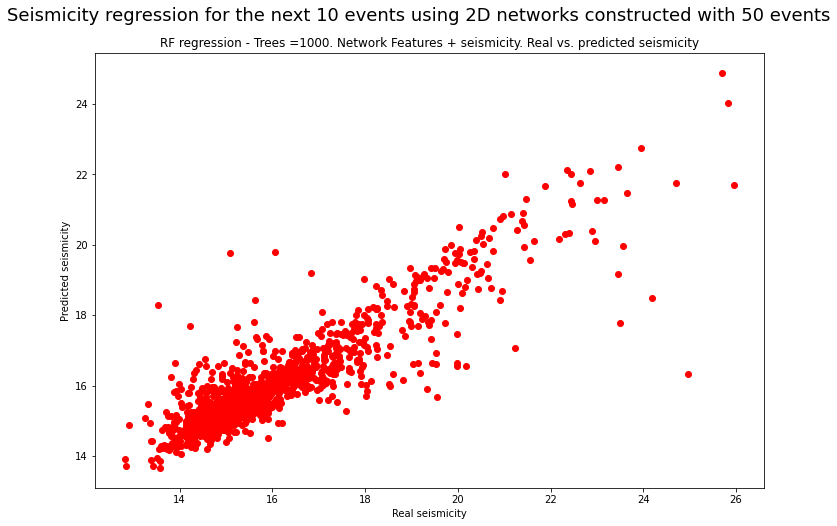

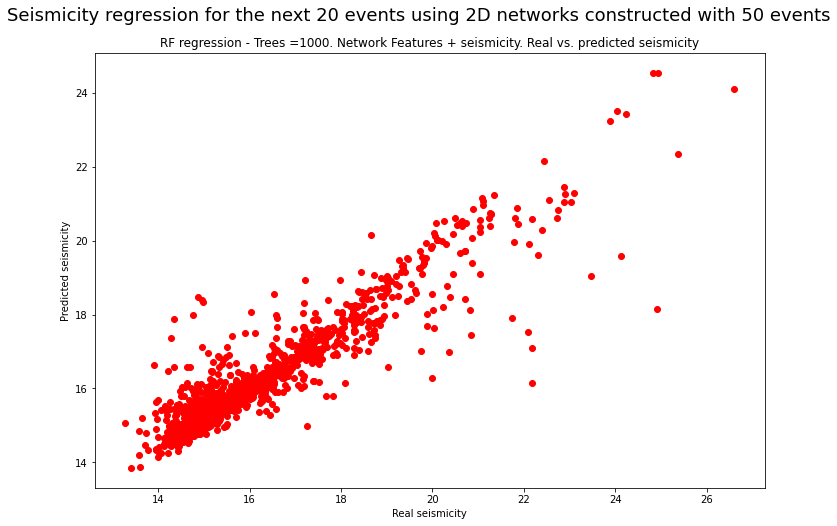

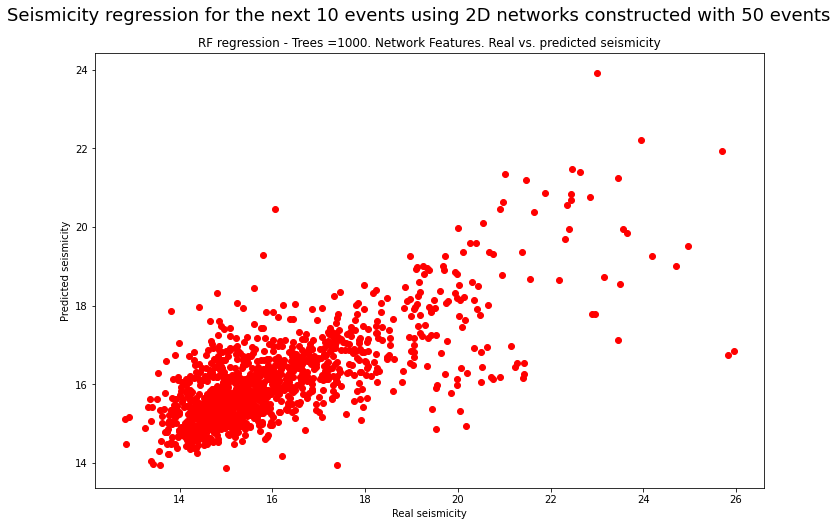

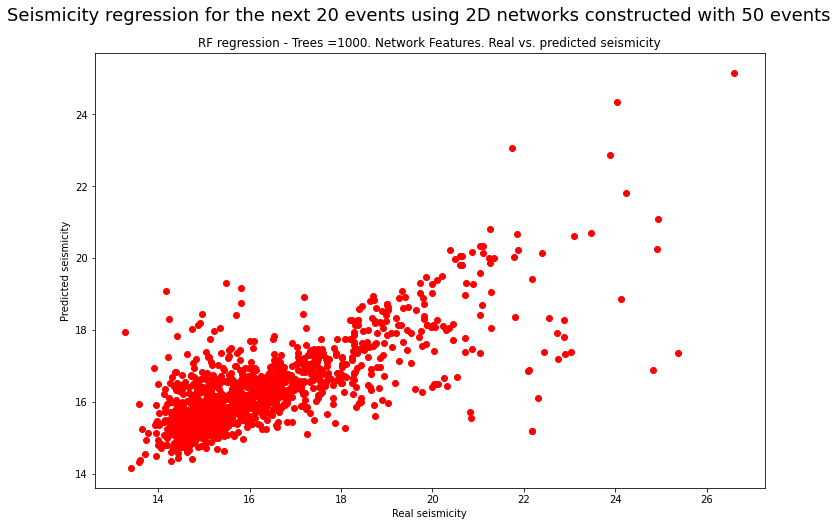

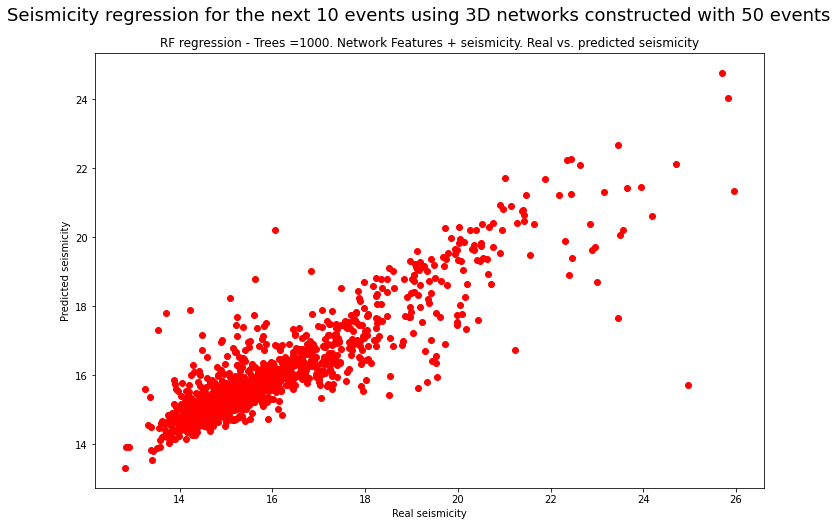

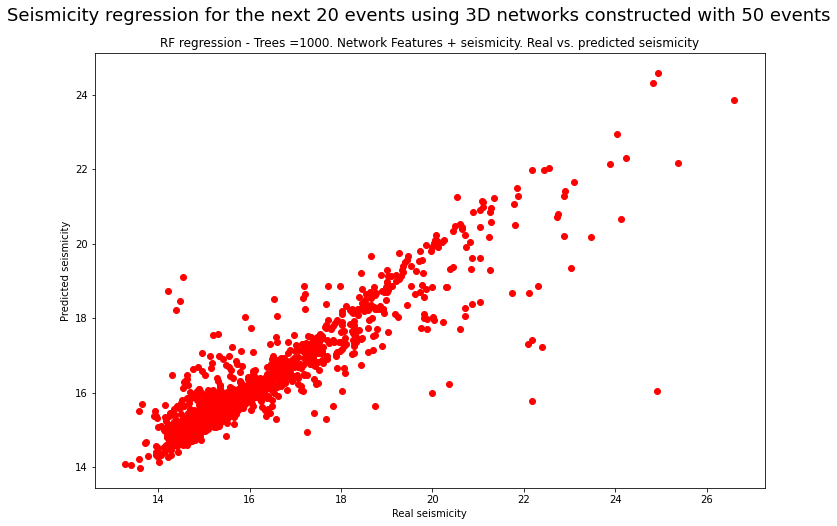

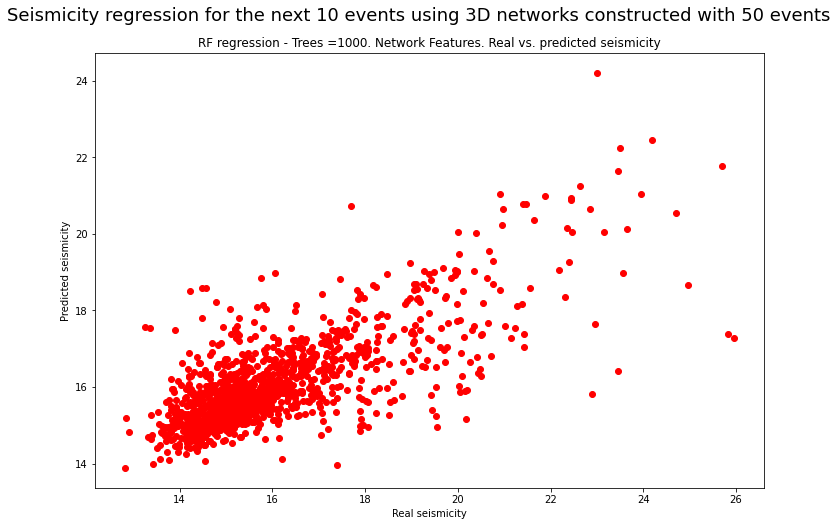

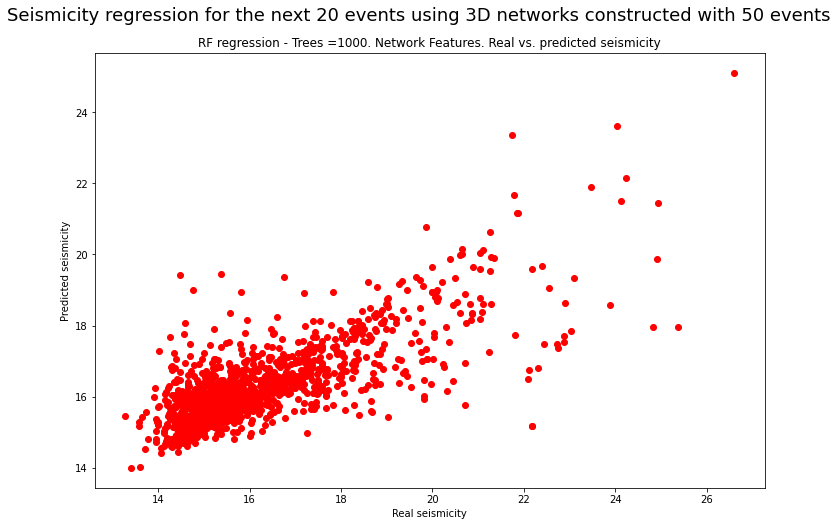

CPU times: user 6min 56s, sys: 1.58 s, total: 6min 57s
Wall time: 6min 55s


In [11]:
%%time

#Random Forest para sismicidad

metricasregresionsigrf=[]

#2D full
for n1 in [50]: #[10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [1000]: #,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs2d[idx][0:len(y)].drop(columns=["Unnamed: 0"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
                
                regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("RF regression - Trees ="+str(c)+". Network Features + seismicity. Real vs. predicted seismicity")
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("2Dfull-seismicity-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigrf.append(["RF","2d","inputfull",idx,sig,target,c,mae,mse,mape,r2])

#2D solo network features
for n1 in [50]: #[10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [1000]: #,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs2d[idx][0:len(y)].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
                
                regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("RF regression - Trees ="+str(c)+". Network Features. Real vs. predicted seismicity")
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("2Dmod-seismicity-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigrf.append(["RF","2d","inputmod",idx,sig,target,c,mae,mse,mape,r2])

#3D full
for n1 in [50]: #[10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [1000]: #,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs3d[idx][0:len(y)].drop(columns=["Unnamed: 0"])
                
                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)

                regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("RF regression - Trees ="+str(c)+". Network Features + seismicity. Real vs. predicted seismicity")
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("3Dfull-seismicity-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigrf.append(["RF","3d","inputfull",idx,sig,target,c,mae,mse,mape,r2])

#3D mod
for n1 in [50]: #[10,50,100]:
    idx="nev"+str(n1)
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [1000]: #,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs3d[idx][0:len(y)].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])

                Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
                
                regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
                regressor.fit(Xtrain,ytrain)
                prediccion=regressor.predict(Xtest)

                fig=plt.figure(figsize=(12,8))
                plt.plot(ytest, prediccion, 'or')
                plt.suptitle("Seismicity regression for the next "+str(sig)+" events using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
                plt.title("RF regression - Trees ="+str(c)+". Network Features. Real vs. predicted seismicity")
                plt.xlabel("Real seismicity")
                plt.ylabel("Predicted seismicity")
                plt.savefig("3Dmod-seismicity-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
                plt.show()

                mae = mean_absolute_error(ytest, prediccion)
                mse = mean_squared_error(ytest, prediccion)
                r2 = r2_score(ytest, prediccion)
                mape = mean_absolute_percentage_error(ytest, prediccion)
                metricasregresionsigrf.append(["RF","3d","inputmod",idx,sig,target,c,mae,mse,mape,r2])


dfmetricasregresionsigrf=pd.DataFrame(metricasregresionsigrf,columns=["Algorithm","NetworkType","InputType","Nevs","Nsigs","Target","Cost","MAE","MSE","MAPE","R2"])
dfmetricasregresionsigrf.to_csv("dfmetricasregresionsigrf.csv")

Ahora regresión para siguientes días y para magnitud.

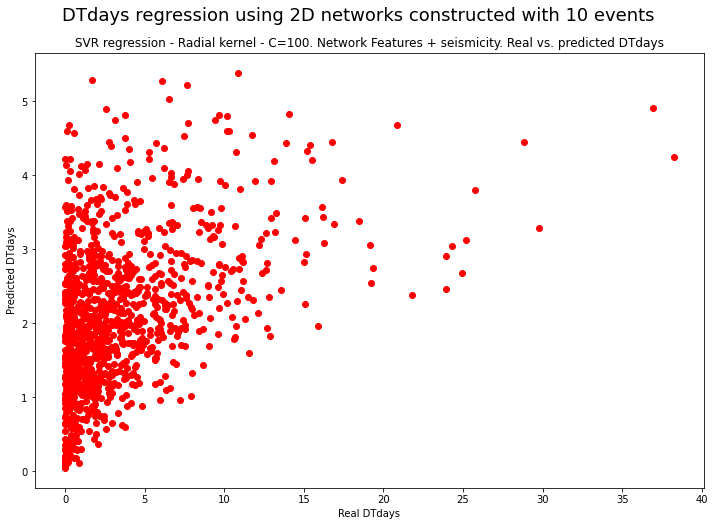

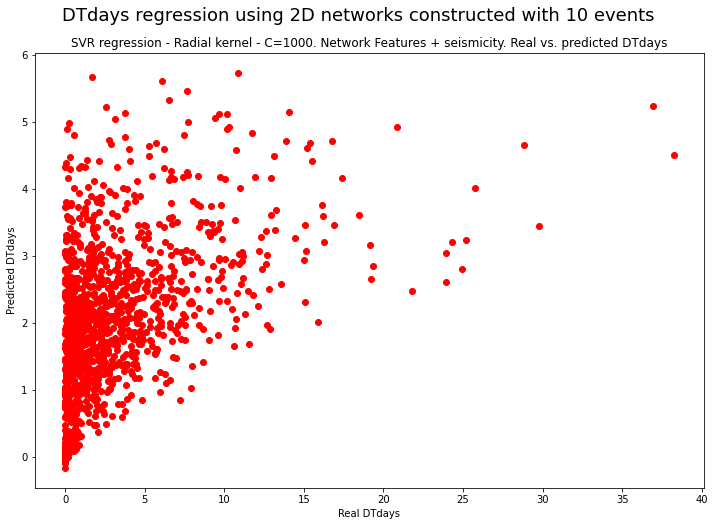

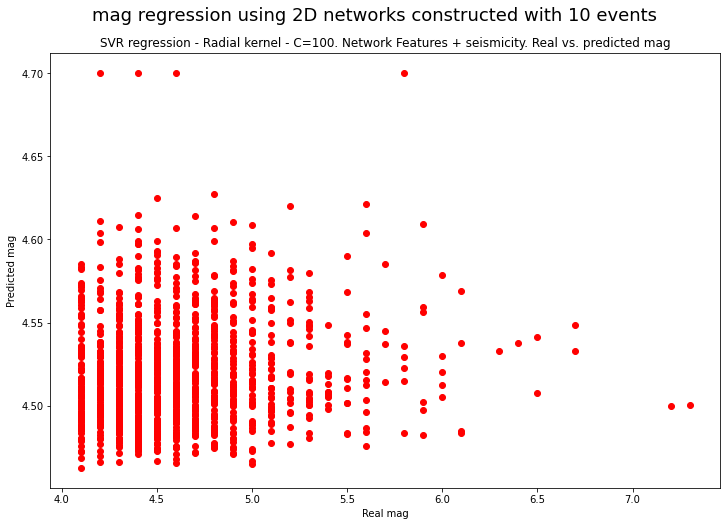

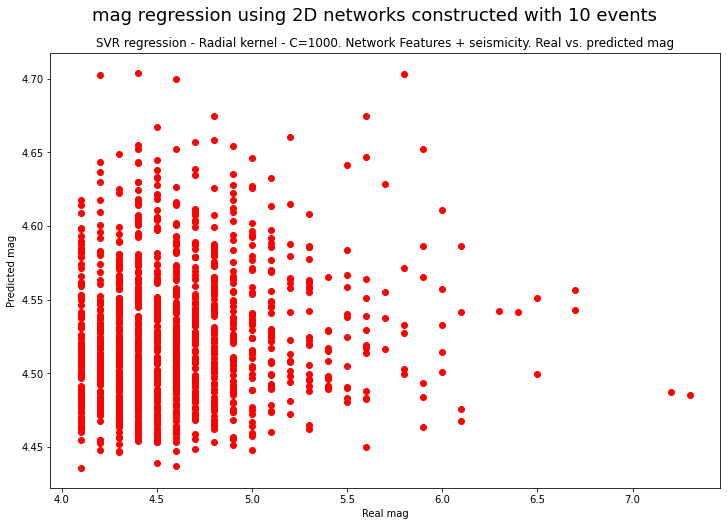

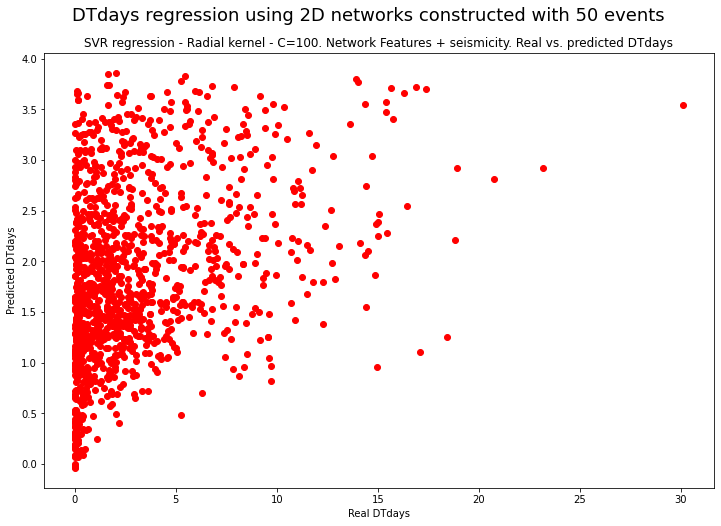

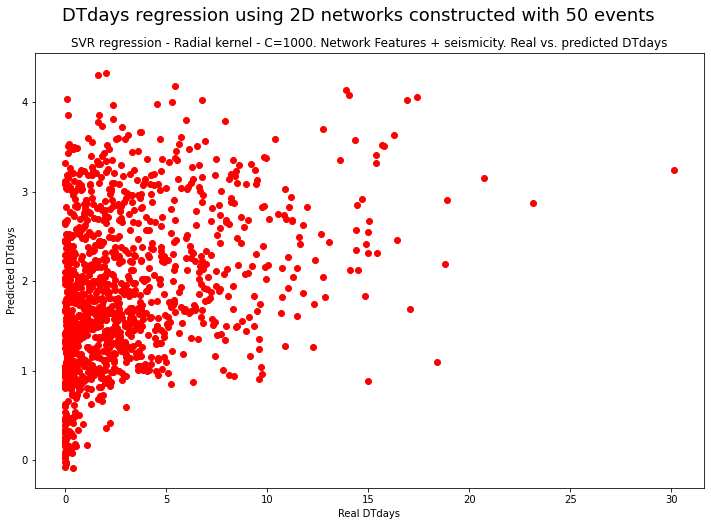

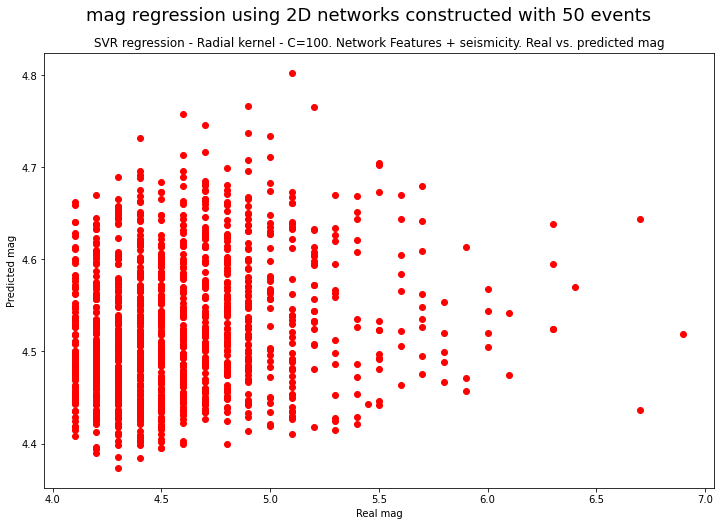

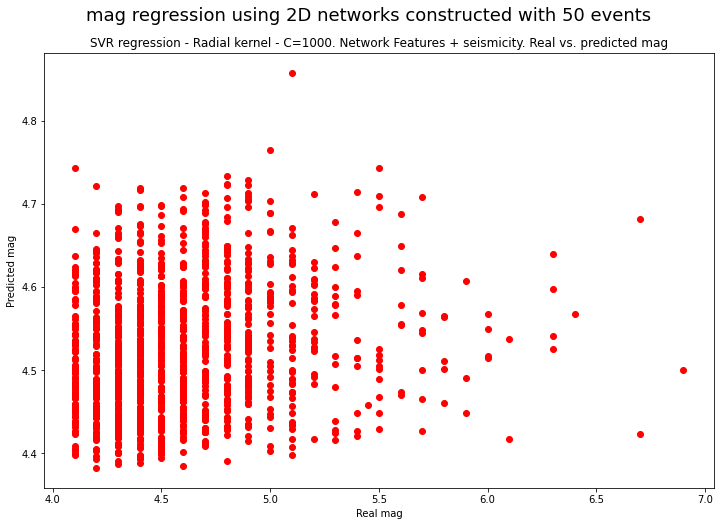

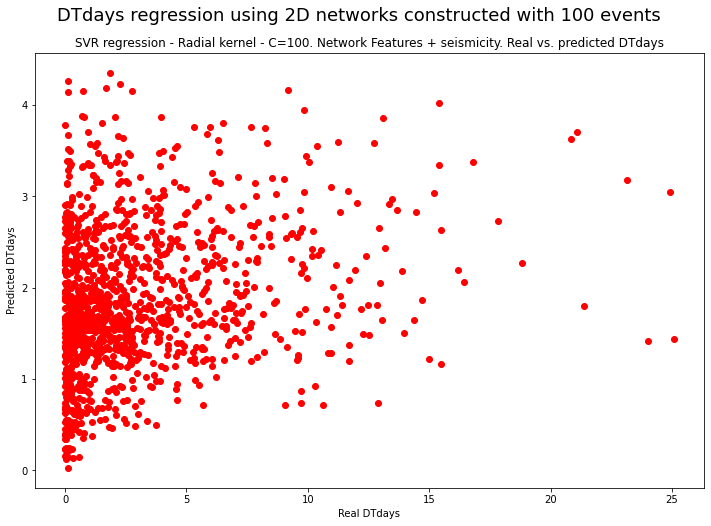

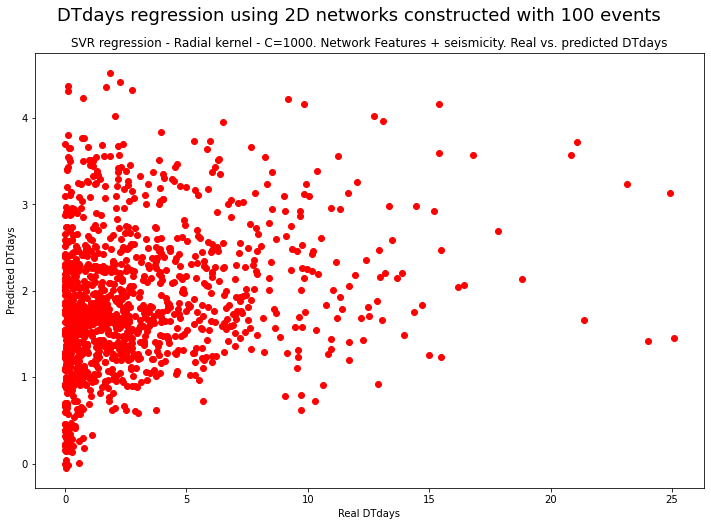

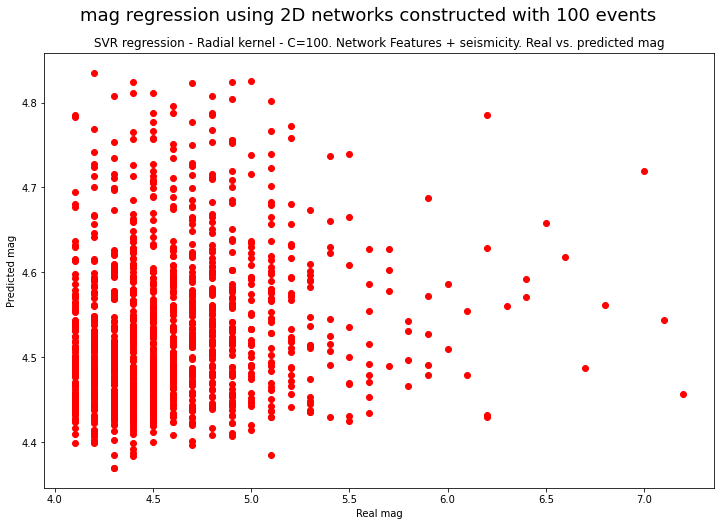

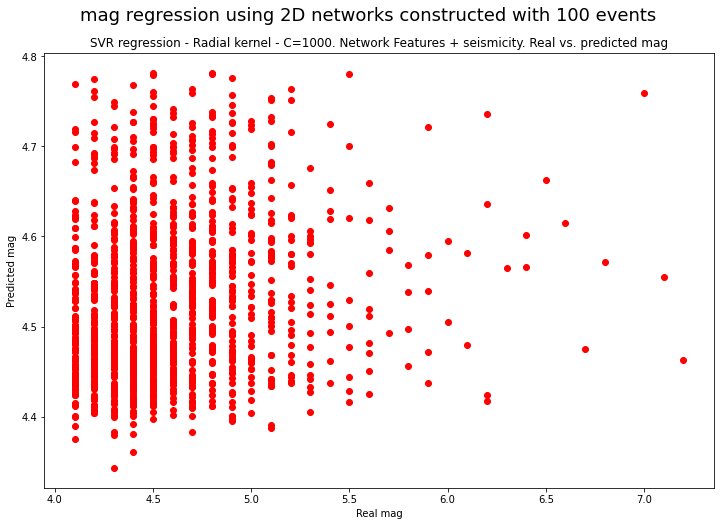

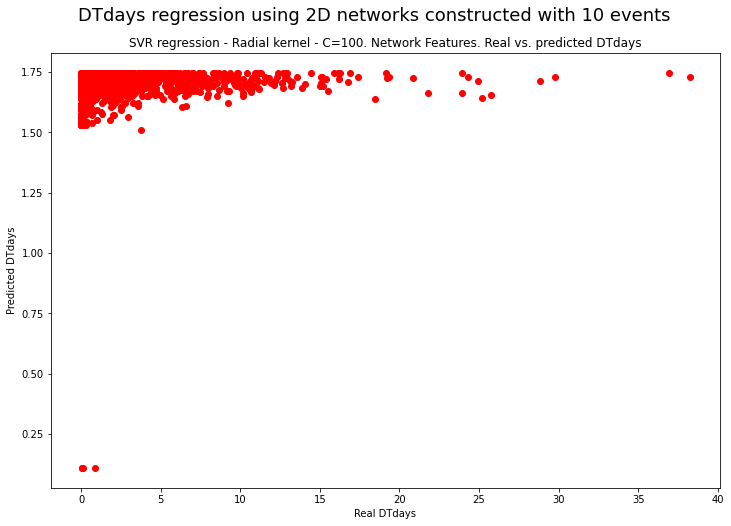

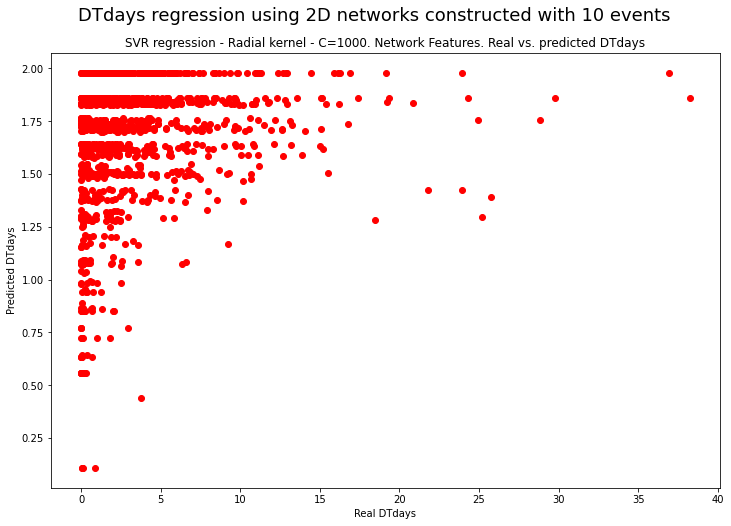

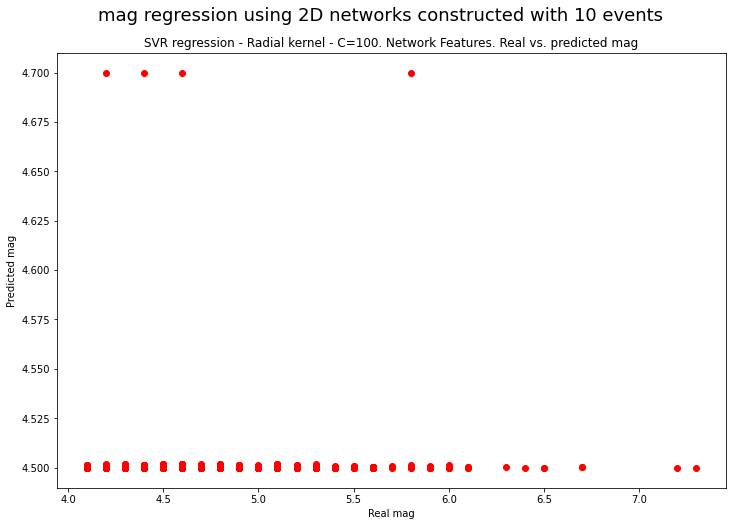

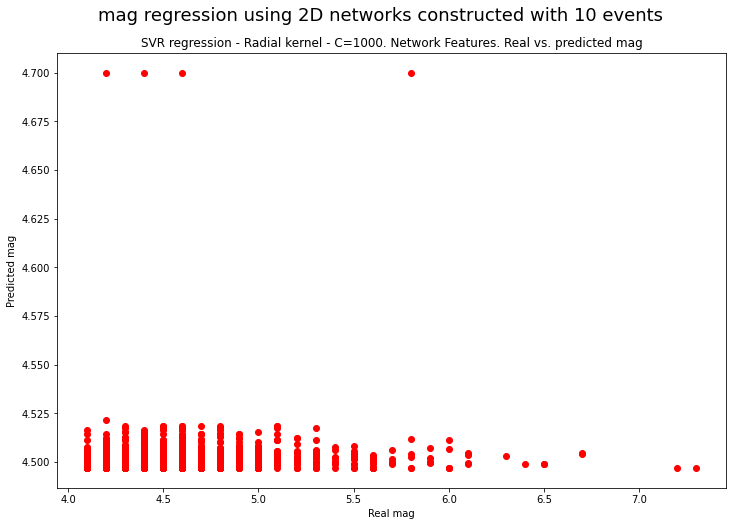

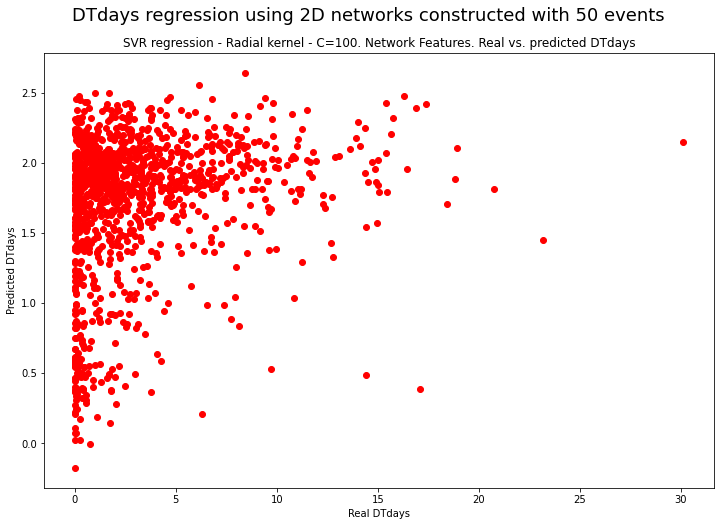

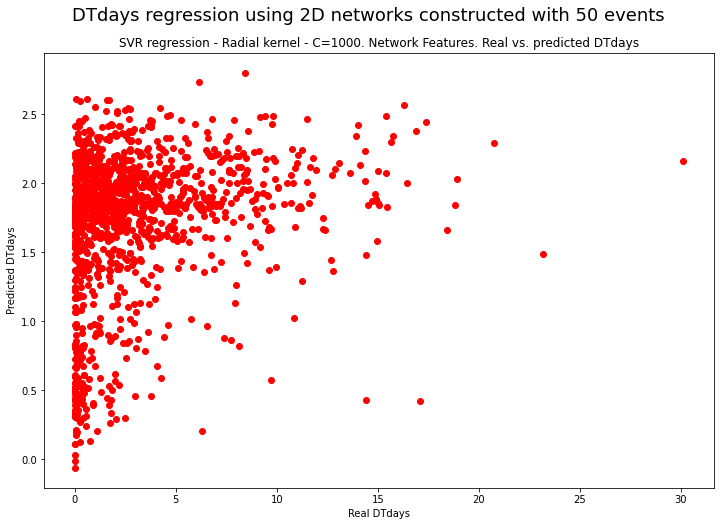

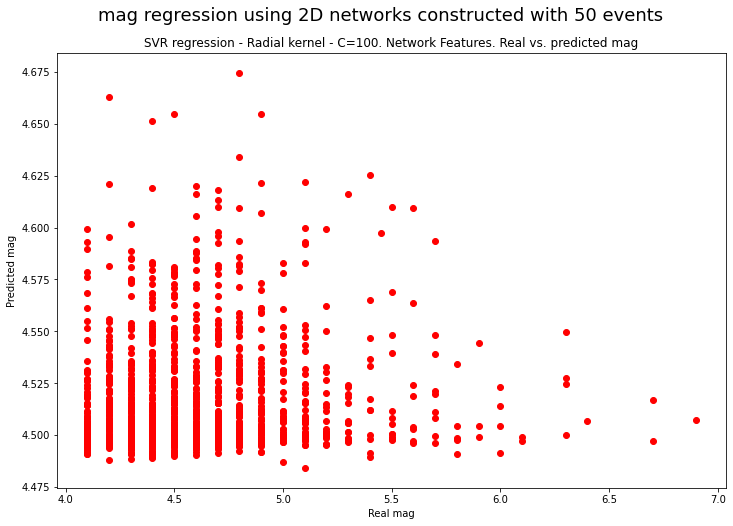

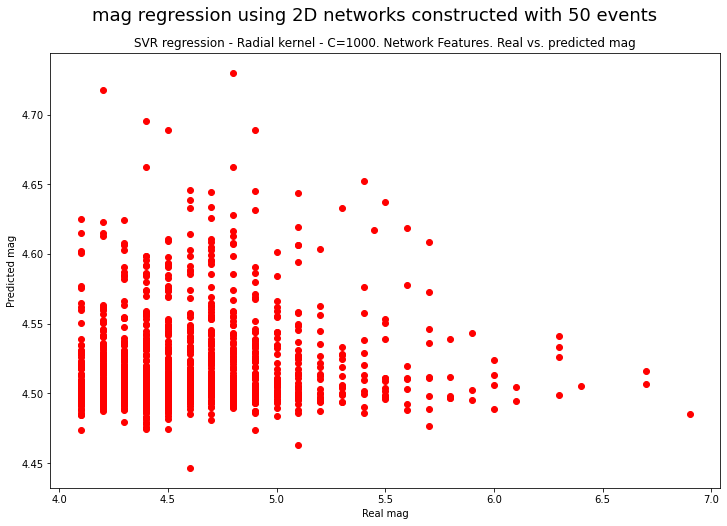

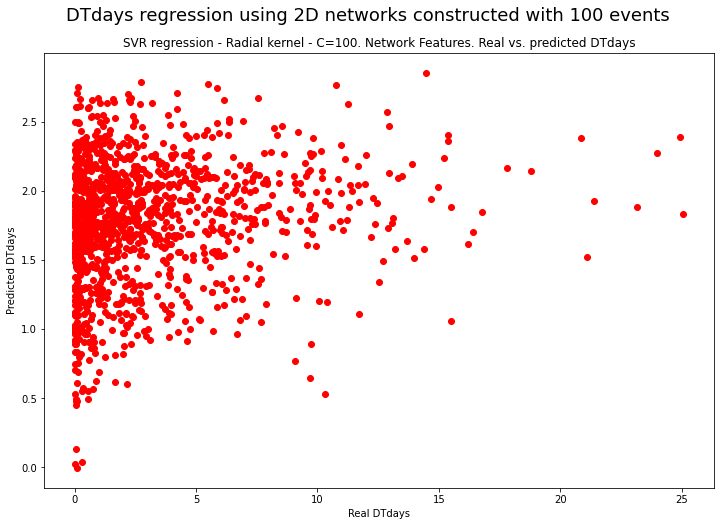

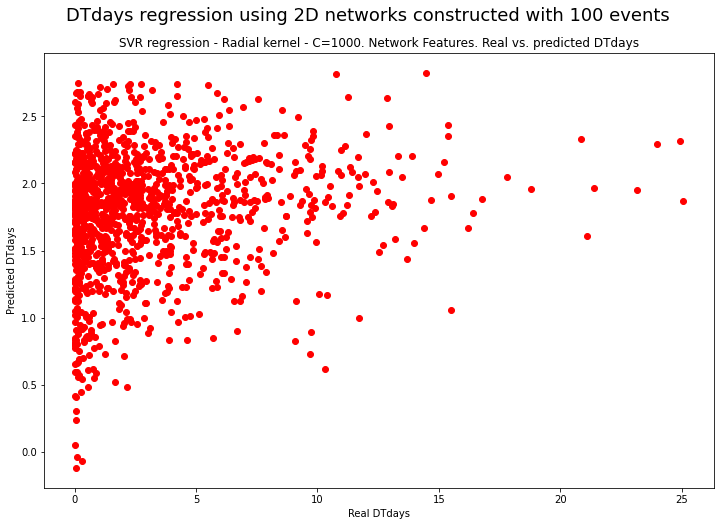

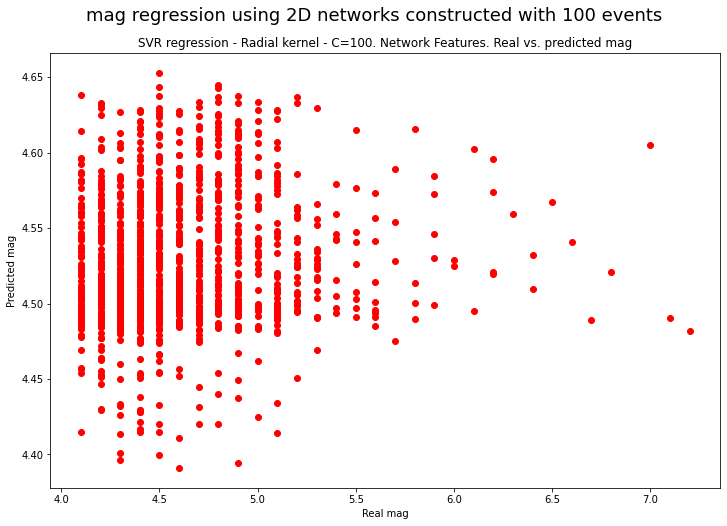

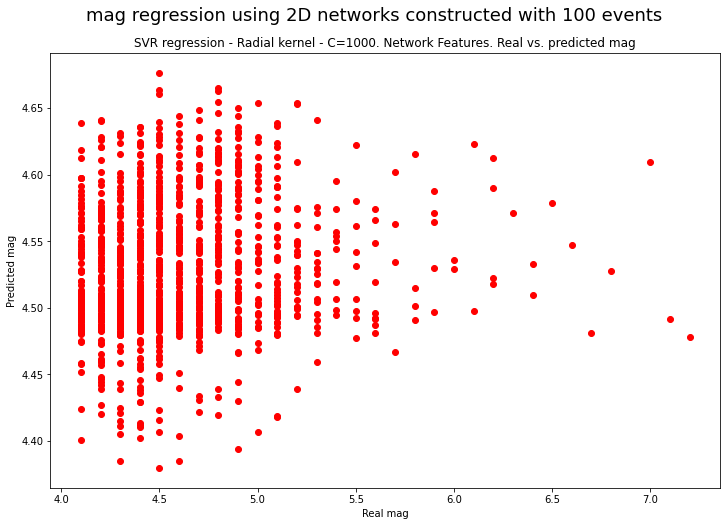

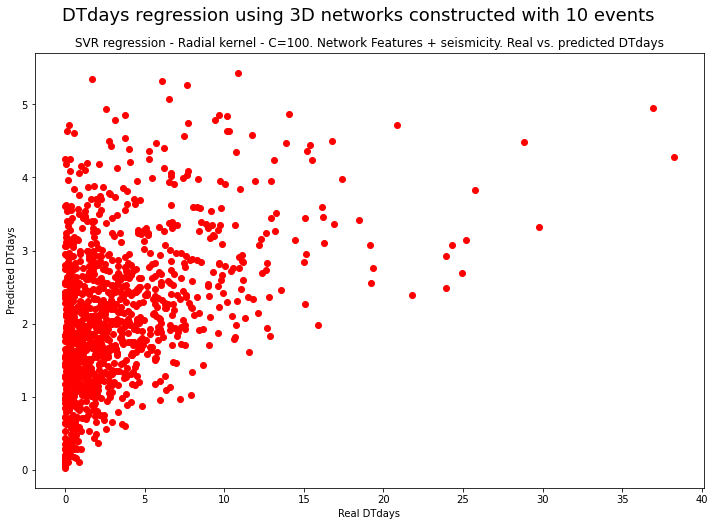

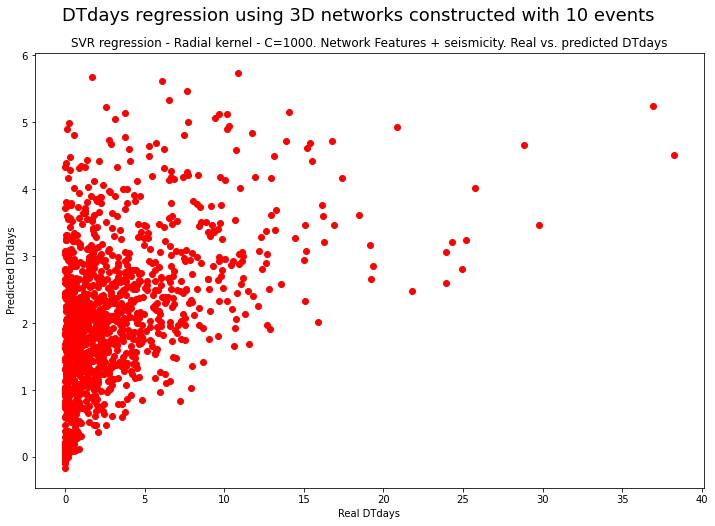

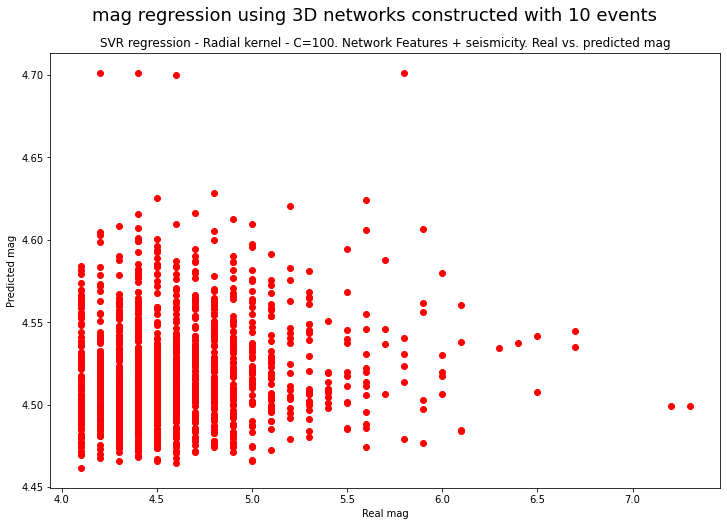

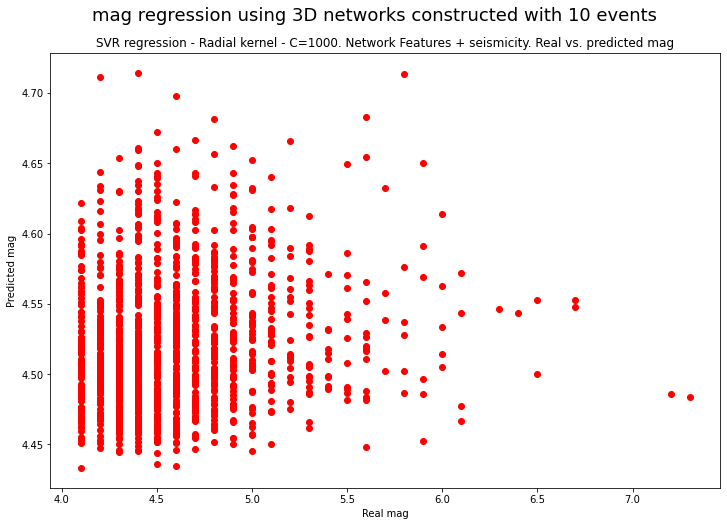

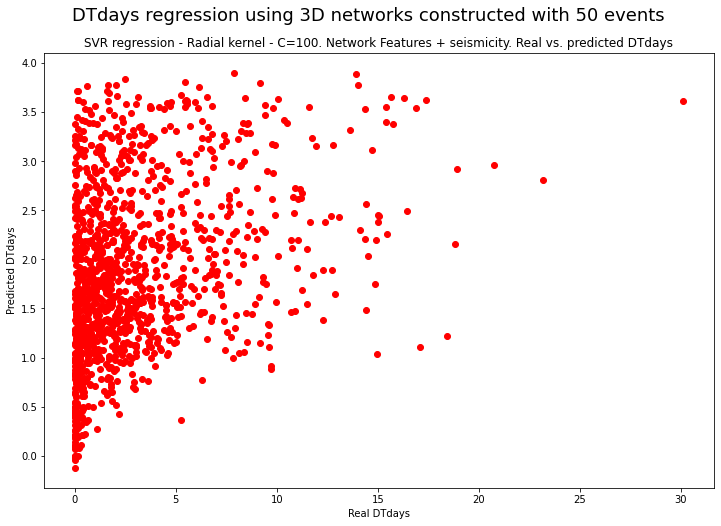

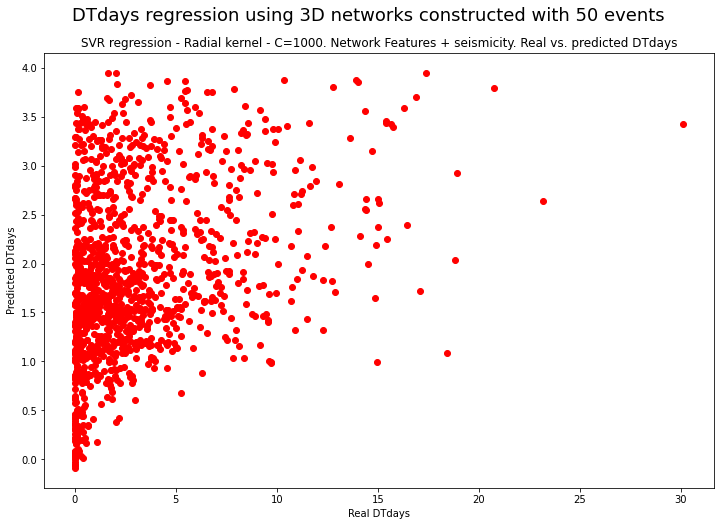

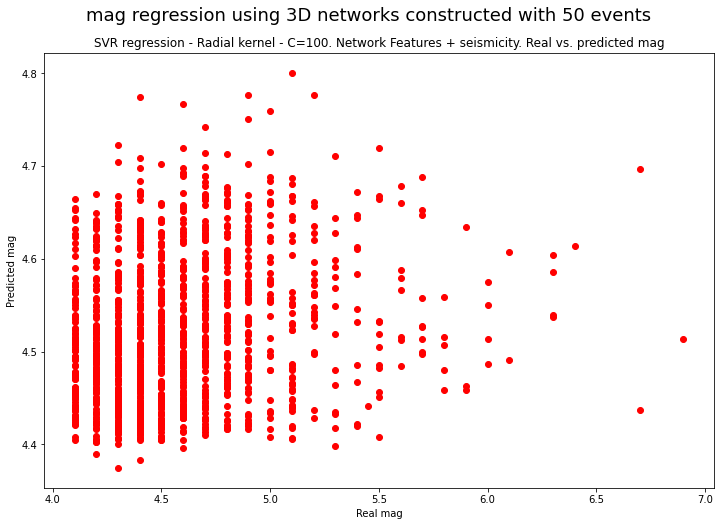

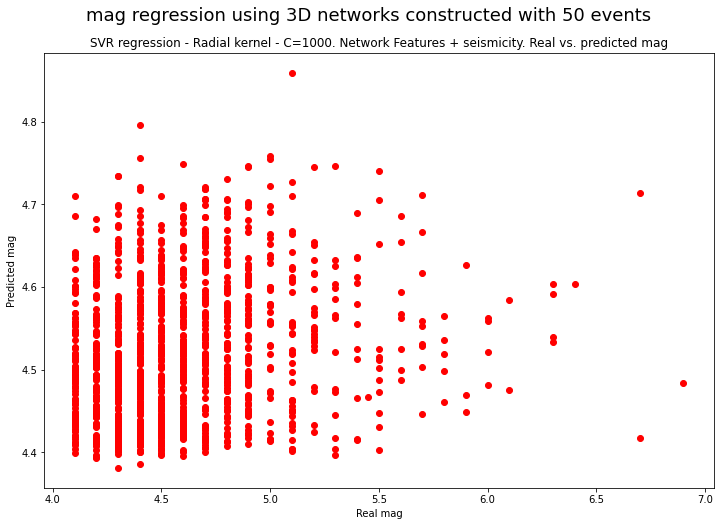

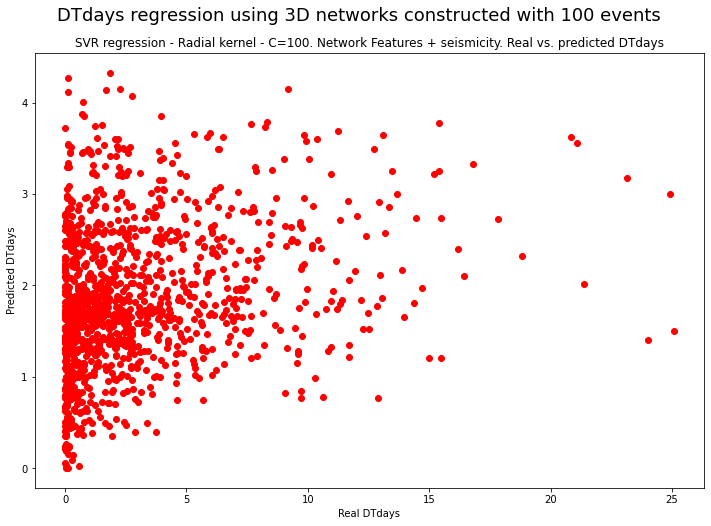

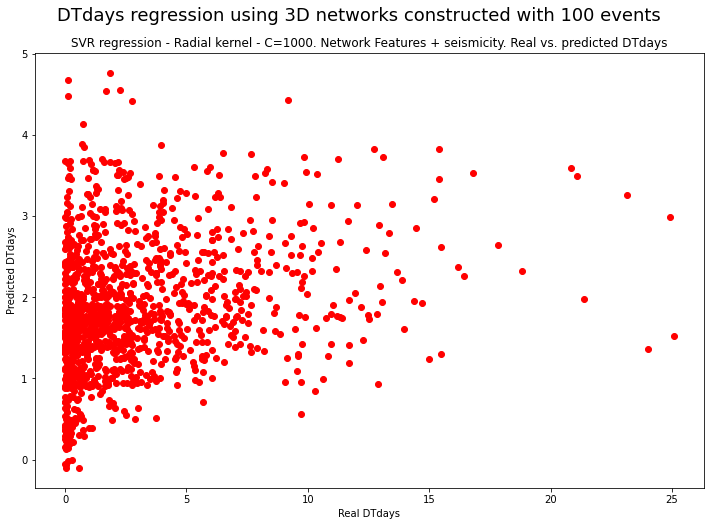

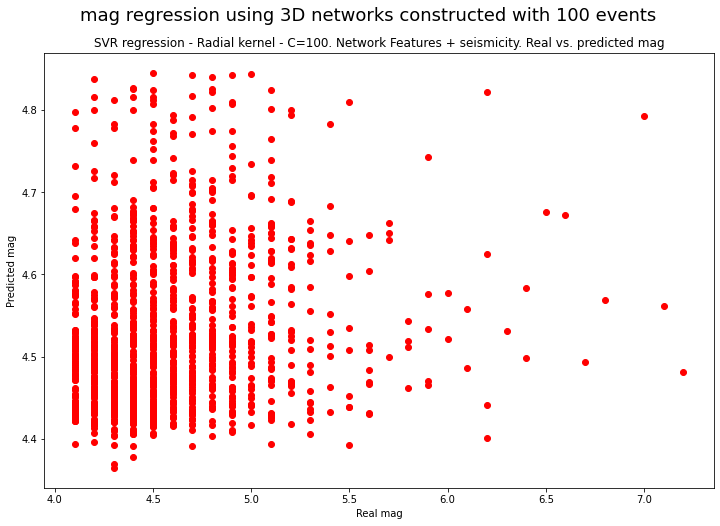

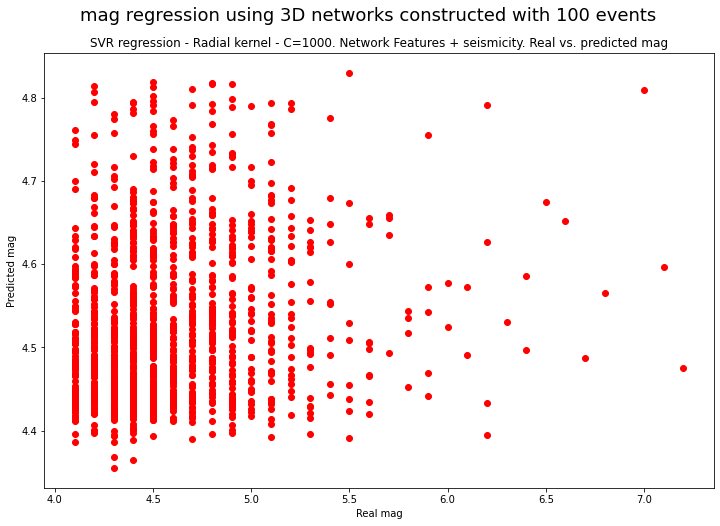

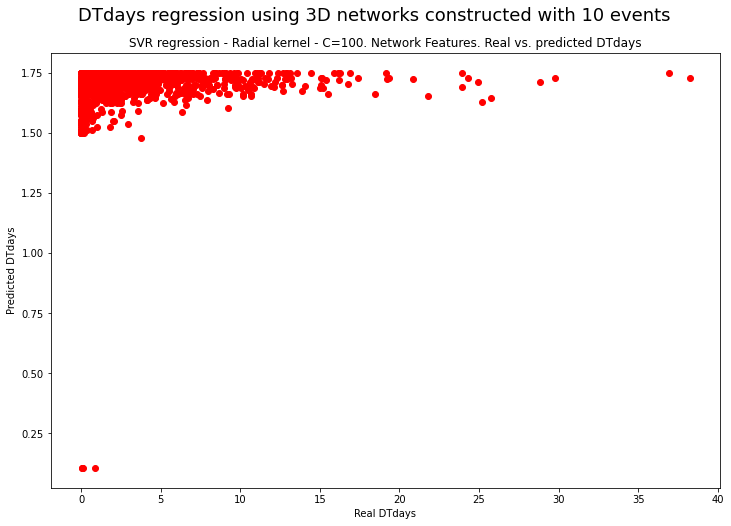

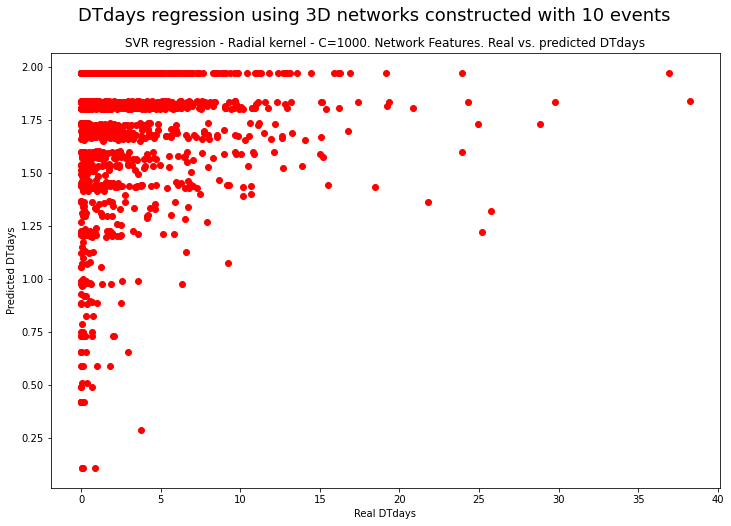

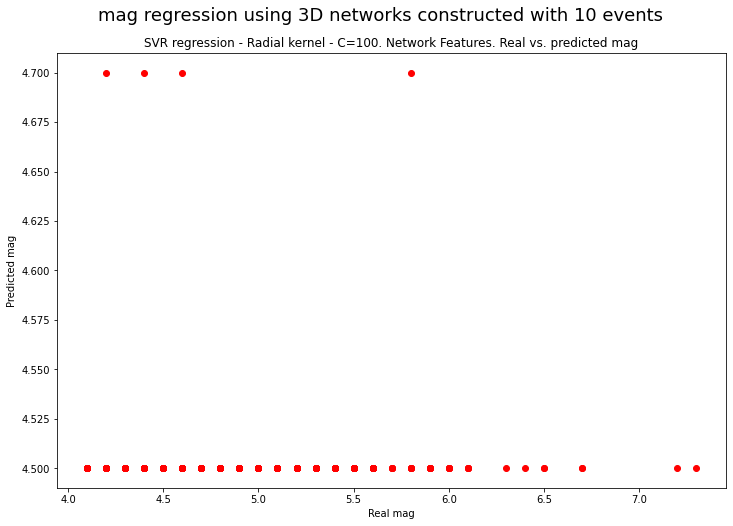

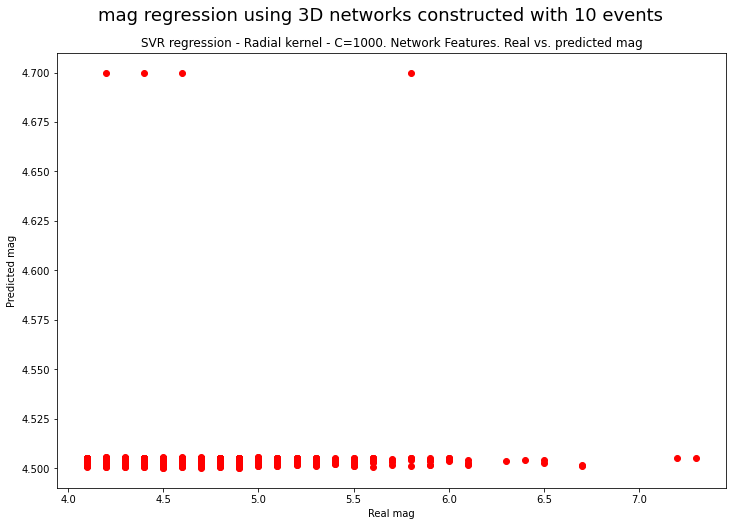

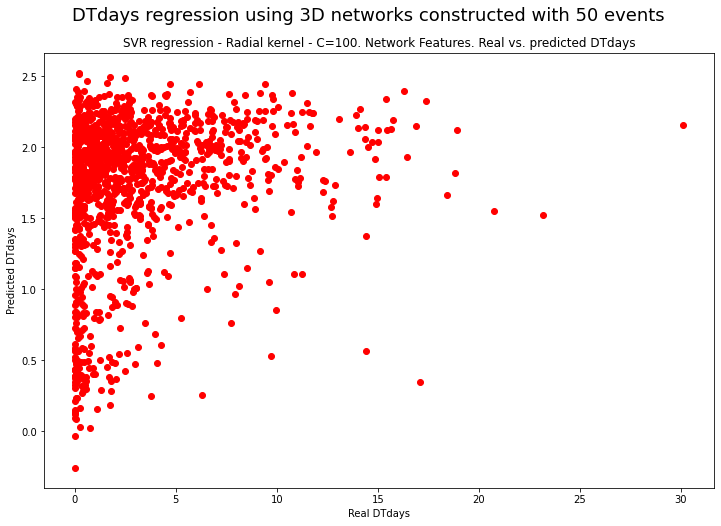

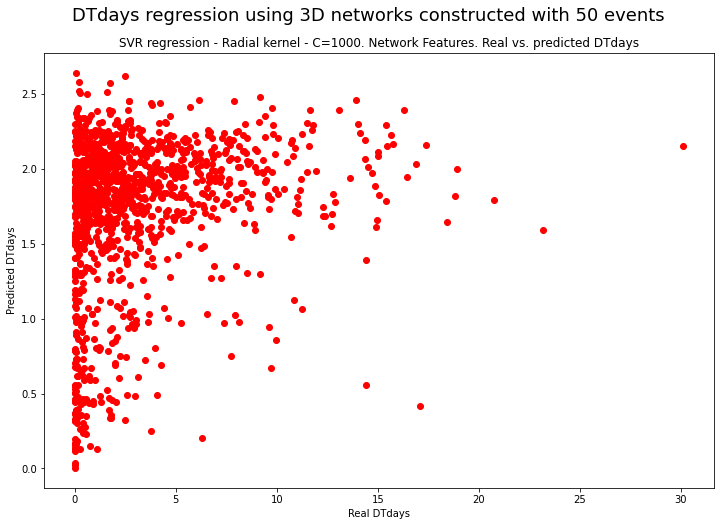

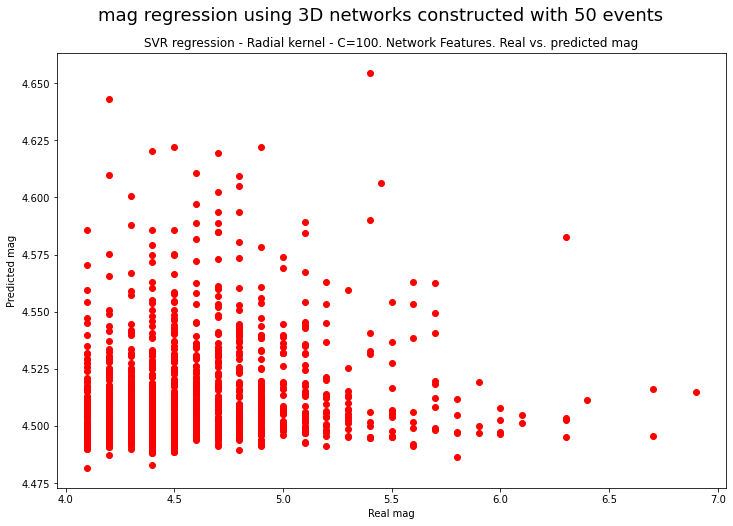

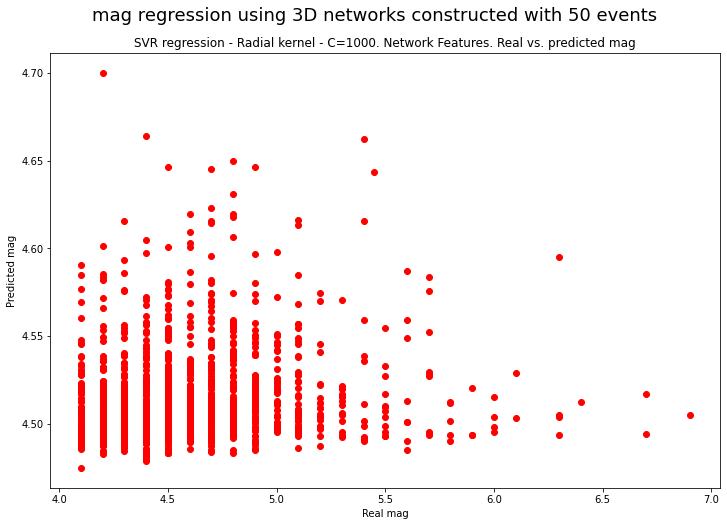

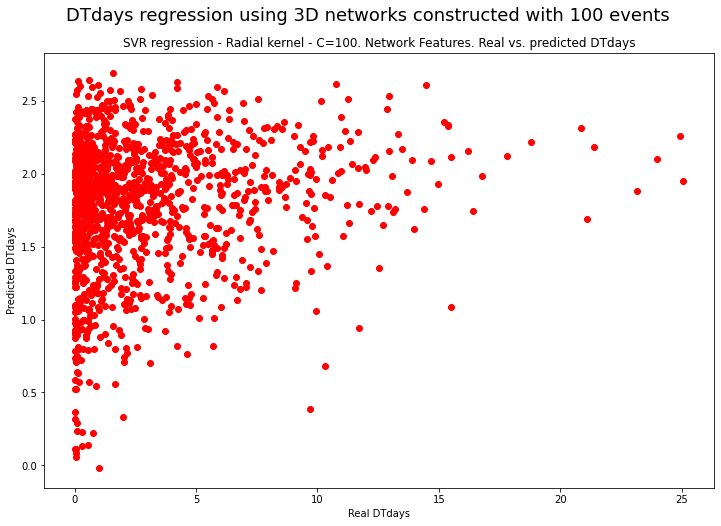

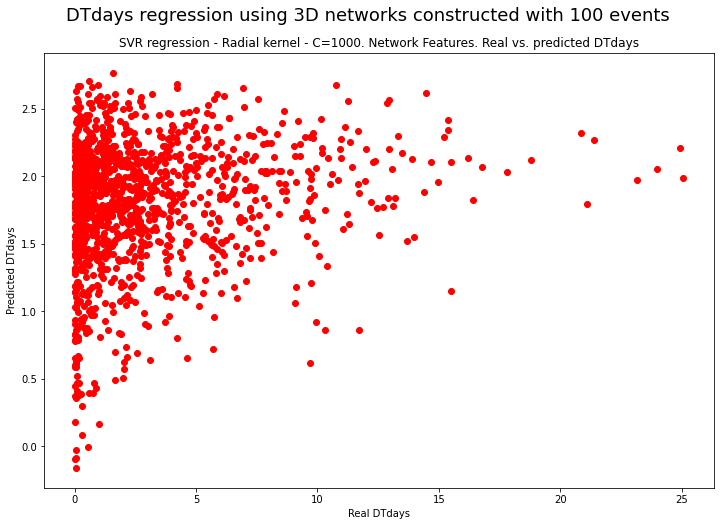

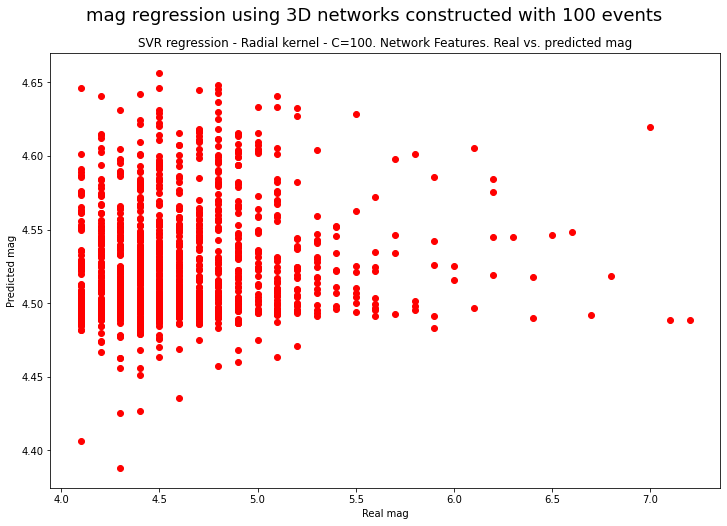

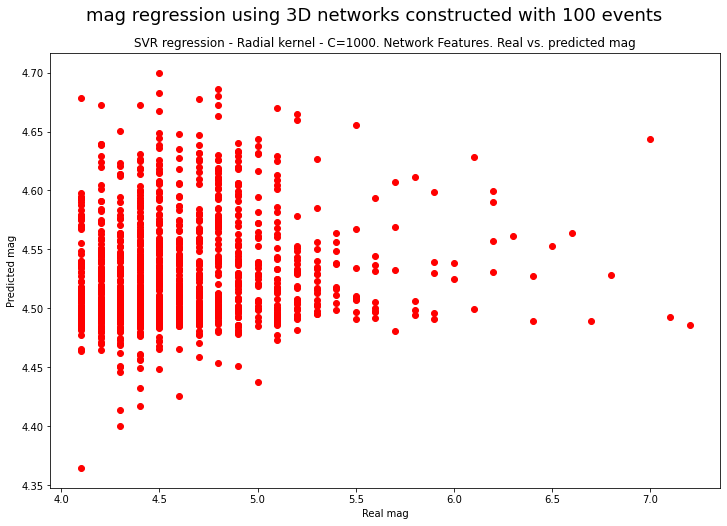

CPU times: user 1min 51s, sys: 7.5 s, total: 1min 58s
Wall time: 1min 46s


In [55]:
%%time

#Support vector machine para DTdays y mag

metricasregresionsvr=[]


#2D full
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [100,1000]:

            #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            xmod=dfvecs2d[idx].drop(columns=["Unnamed: 0"])

            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
            
            regressor = SVR(kernel='rbf',C=c)
            #regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features + seismicity. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("2Dfull-"+target+"-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionsvr.append(["SVR","2d","inputfull",idx,target,c,mae,mse,mape,r2])

#2D only network features
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [100,1000]:

            xmod=dfvecs2d[idx].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            #xmod=dfvecs2d[idx]
            
            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
            
            regressor = SVR(kernel='rbf',C=c)
            #regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("2Dmod-"+target+"-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionsvr.append(["SVR","2d","inputmod",idx,target,c,mae,mse,mape,r2])

#3D full
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [100,1000]:

            #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            xmod=dfvecs3d[idx].drop(columns=["Unnamed: 0"])

            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
            
            regressor = SVR(kernel='rbf',C=c)
            #regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features + seismicity. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("3Dfull-"+target+"-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionsvr.append(["SVR","3d","inputfull",idx,target,c,mae,mse,mape,r2])

#3D only network features
for n1 in [10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [100,1000]:

            xmod=dfvecs3d[idx].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            #xmod=dfvecs2d[idx]

            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
            
            regressor = SVR(kernel='rbf',C=c)
            #regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("SVR regression - Radial kernel - C="+str(c)+". Network Features. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("3Dmod-"+target+"-SVR-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionsvr.append(["SVR","3d","inputmod",idx,target,c,mae,mse,mape,r2])


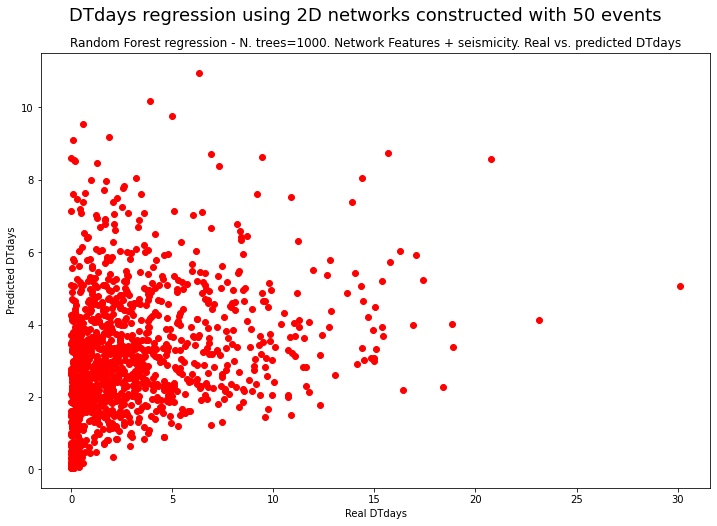

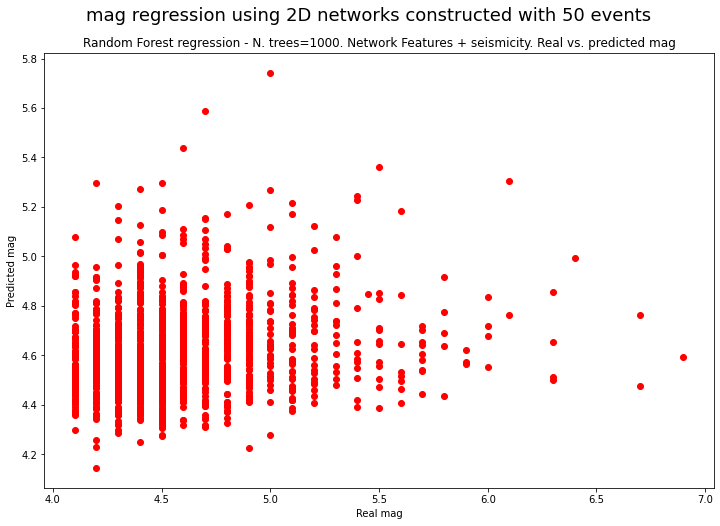

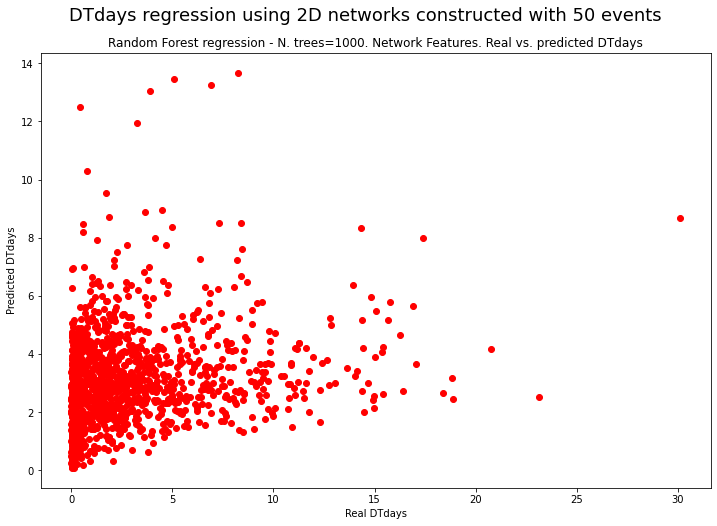

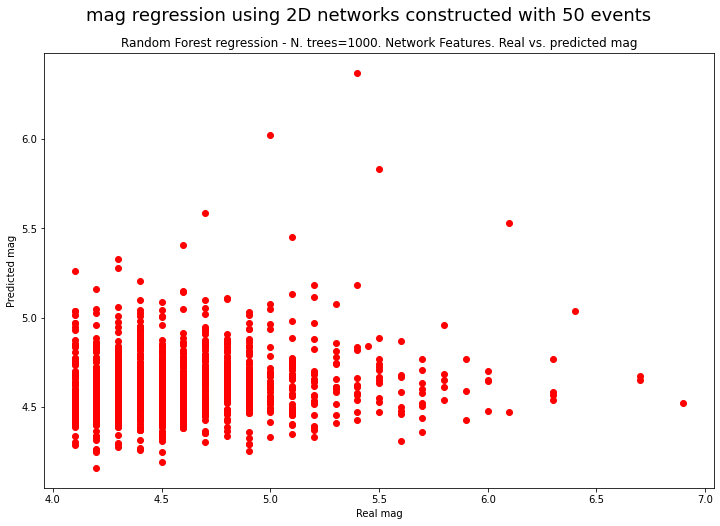

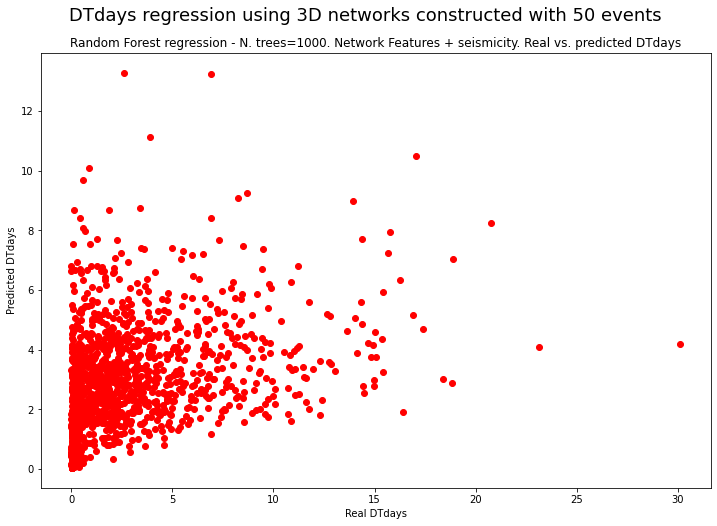

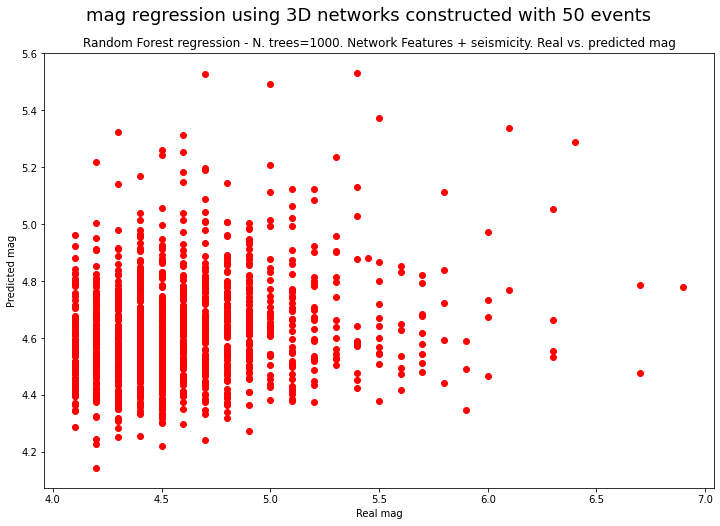

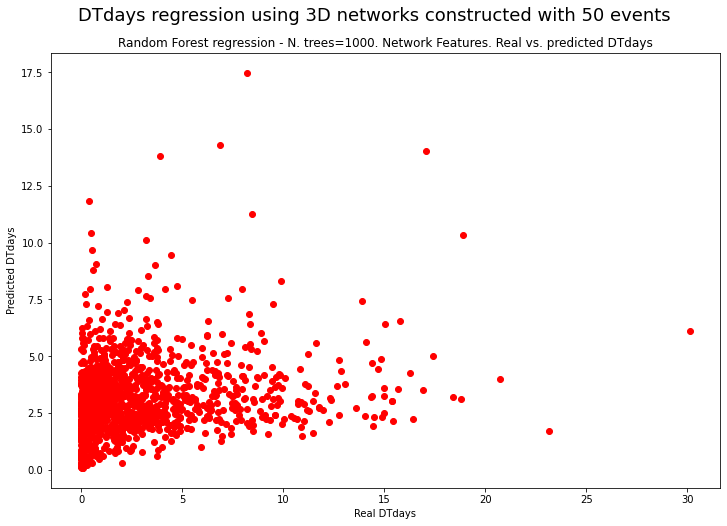

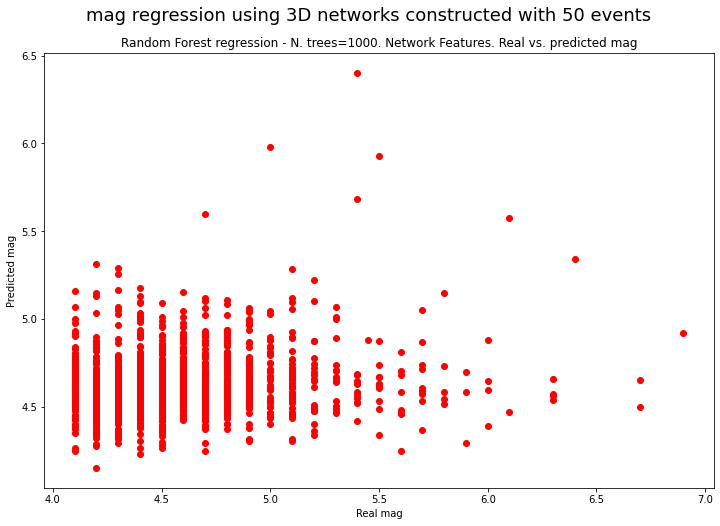

CPU times: user 7min 20s, sys: 1.52 s, total: 7min 22s
Wall time: 7min 19s


In [12]:
%%time

#Random Forest machine para DTdays y mag

metricasregresionrf=[]


#2D full
for n1 in [50]: #10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [1000]: #,1000]:

            #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            xmod=dfvecs2d[idx].drop(columns=["Unnamed: 0"])
            
            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)

            #regressor = SVR(kernel='rbf',C=c)
            regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("Random Forest regression - N. trees="+str(c)+". Network Features + seismicity. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("2Dfull-"+target+"-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionrf.append(["RF","2d","inputfull",idx,target,c,mae,mse,mape,r2])

#2D only network features
for n1 in [50]: #10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [1000]: #,1000]:

            xmod=dfvecs2d[idx].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            #xmod=dfvecs2d[idx]

            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
            
            #regressor = SVR(kernel='rbf',C=c)
            regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 2D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("Random Forest regression - N. trees="+str(c)+". Network Features. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("2Dmodl-"+target+"-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionrf.append(["RF","2d","inputmod",idx,target,c,mae,mse,mape,r2])

#3D full
for n1 in [50]: #10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [1000]: #,1000]:

            #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            xmod=dfvecs3d[idx].drop(columns=["Unnamed: 0"])
            
            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)

            #regressor = SVR(kernel='rbf',C=c)
            regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("Random Forest regression - N. trees="+str(c)+". Network Features + seismicity. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("3Dfull-"+target+"-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionrf.append(["RF","3d","inputfull",idx,target,c,mae,mse,mape,r2])

#3D only network features
for n1 in [50]: #10,50,100]:
    idx="nev"+str(n1)
    for target in ["DTdays","mag"]:
        for c in [1000]: #,1000]:

            xmod=dfvecs3d[idx].drop(columns=["Unnamed: 0","energia","dtdias","sismicidad"])
            indice=idx+"-nsig"+str(sig)
            y=dfvecsalidas[idx][target]
            #xmod=dfvecs2d[idx]

            Xtrain, Xtest, ytrain, ytest = train_test_split(xmod, y, test_size=0.2, random_state=42)
            
            #regressor = SVR(kernel='rbf',C=c)
            regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            regressor.fit(Xtrain,ytrain)
            prediccion=regressor.predict(Xtest)
            
            fig=plt.figure(figsize=(12,8))
            plt.plot(ytest, prediccion, 'or')
            plt.suptitle(target+" regression using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
            plt.title("Random Forest regression - N. trees="+str(c)+". Network Features. Real vs. predicted "+target)
            plt.xlabel("Real "+target)
            plt.ylabel("Predicted "+target)
            plt.savefig("3Dmod-"+target+"-RF-C"+str(c)+"-"+idx+"-sig"+str(sig)+".svg",format="svg")
            plt.show()

            mae = mean_absolute_error(ytest, prediccion)
            mse = mean_squared_error(ytest, prediccion)
            r2 = r2_score(ytest, prediccion)
            mape = mean_absolute_percentage_error(ytest, prediccion)
            metricasregresionrf.append(["RF","3d","inputmod",idx,target,c,mae,mse,mape,r2])

            
dfmetricasregresionrf=pd.DataFrame(metricasregresionrf,columns=["Algorithm","NetworkType","InputType","Nevs","Target","Cost","MAE","MSE","MAPE","R2"])
dfmetricasregresionrf.to_csv("dfmetricasregresionrf.csv")

In [13]:
dfmetricasregresionsigrf

Algorithm NetworkType  InputType   Nevs  Nsigs      Target  Cost       MAE  \
0        RF          2d  inputfull  nev50     10  sismicidad  1000  0.604342   
1        RF          2d  inputfull  nev50     20  sismicidad  1000  0.475133   
2        RF          2d   inputmod  nev50     10  sismicidad  1000  0.949176   
3        RF          2d   inputmod  nev50     20  sismicidad  1000  0.883632   
4        RF          3d  inputfull  nev50     10  sismicidad  1000  0.606538   
5        RF          3d  inputfull  nev50     20  sismicidad  1000  0.493221   
6        RF          3d   inputmod  nev50     10  sismicidad  1000  0.936082   
7        RF          3d   inputmod  nev50     20  sismicidad  1000  0.890856   

        MSE      MAPE        R2  
0  0.857717  0.036753  0.781148  
1  0.630876  0.028383  0.832715  
2  1.866574  0.057298  0.523731  
3  1.711529  0.052534  0.546167  
4  0.870338  0.036791  0.777927  
5  0.720054  0.029316  0.809069  
6  1.831248  0.056433  0.532744  
7  1.688541  0.052868  0.552262

# Regresion con datos reales.

In [10]:
def gradprom( g ):
    return sum(dict(g.degree()).values())/len(g.degree())

def disprobgrado(grafo):
    m=nx.adjacency_matrix(grafo)
    v=[0 for i in range (m.shape[0])]
    v1=[0 for i in range (m.shape[0])]
    for i in range (m.shape[1]):
        i1=m[i].todense().sum()
        v[i1-1]=v[i1-1]+1
    tod=sum(v)
    for i in range(m.shape[1]):
        v1[i]=v[i]/tod
    return v1

def dentropy(v):
    v1=[i*math.log(i) for i in list(filter(lambda x: x>0, v))]
    a=math.log(len(v)-1)
    if a>0:
        s1=-sum(v1)/a
    else:
        s1=-sum(v1)/0.00001
    return s1

def smallworldness(g):
    n=nx.number_of_nodes(g)
    gp=gradprom(g)
    c=nx.average_clustering(g)
    p=nx.average_shortest_path_length(g)
    sw=c*n*np.log(n)/(p*gp*np.log(gp))
    return sw

def creavector(df,col,pos,nevs):
    grafo=nx.Graph()
    vector=df[col].values[pos:nevs+pos]
    for i in range(1,len(vector)):
        grafo.add_edge(vector[i-1],vector[i])
    
    clusttemp=nx.average_clustering(grafo)
    pathstemp=nx.average_shortest_path_length(grafo)
    nedgestemp=grafo.number_of_edges()
    nodostemp=nx.number_of_nodes(grafo)
    gradstemp=gradprom( grafo )
    prgradtemp=disprobgrado(grafo)
    enttemp=dentropy(prgradtemp)
    smallworldtemp=smallworldness(grafo)
    betweentemp=list(nx.betweenness_centrality(grafo).values())
    mbetweentemp=np.mean([float(d) for d in betweentemp])

    energia=df.energia[pos:pos+nevs].sum()
    lenergia=np.log(energia)
    
    tini=df.epochs.values[pos]
    tfin=df.epochs.values[pos+nevs-1]
    dtdias=(tfin-tini)/(60*60*24)

    sismicidad=energia/dtdias
    lsismicidad=np.log(sismicidad)

    veccaracs=[nodostemp,nedgestemp,gradstemp,clusttemp,pathstemp,enttemp,smallworldtemp,mbetweentemp,lenergia,dtdias,lsismicidad]
    return(veccaracs)
    

In [45]:
dfvecsalidas["nev50"]["DTdays"]

0       0.102488
1       0.283333
2       0.496366
3       0.186100
4       1.008542
          ...   
6206    3.858866
6207    1.460451
6208    3.676563
6209    3.925544
6210    3.111100
Name: DTdays, Length: 6211, dtype: float64

In [46]:
catalogo.iloc[50:]["DTdays"]

50      0.102488
51      0.283333
52      0.496366
53      0.186100
54      1.008542
          ...   
6257    1.460451
6258    3.676563
6259    3.925544
6260    3.111100
6261    0.620833
Name: DTdays, Length: 6212, dtype: float64

In [17]:
dfvecsalidassigs["nev50-nsig20"]

sismicidad
0      17.281272
1      17.076551
2      16.971834
3      16.795105
4      16.736861
...          ...
6186   16.219792
6187   16.117046
6188   16.057727
6189   15.367684
6190   15.333320

[6191 rows x 1 columns]

In [21]:
xmod

nodos  edges      grad      clus      path       ent        sw  \
0        26     41  3.153846  0.191508  2.689231  0.327155  1.665250   
1        25     40  3.200000  0.199492  2.696667  0.291263  1.599398   
2        25     39  3.120000  0.156159  2.753333  0.340572  1.285638   
3        24     38  3.166667  0.164054  2.717391  0.285362  1.261528   
4        24     37  3.083333  0.166832  2.811594  0.329730  1.303575   
...     ...    ...       ...       ...       ...       ...       ...   
6206     32     44  2.750000  0.096635  3.137097  0.328962  1.228028   
6207     32     44  2.750000  0.096780  3.177419  0.328962  1.214272   
6208     33     44  2.666667  0.032874  3.312500  0.331616  0.437810   
6209     33     44  2.666667  0.032874  3.392045  0.331616  0.427543   
6210     33     44  2.666667  0.032997  3.570076  0.319684  0.407735   

           bet    energia      dtdias  sismicidad  
0     0.070385  33.961025  111.010544   29.251400  
1     0.073768  33.960396  109.276412   29.266515  
2     0.076232  33.962467  105.532569   29.303447  
3     0.078063  33.962282  105.126343   29.307119  
4     0.082345  33.962690  104.687905   29.311706  
...        ...        ...         ...         ...  
6206  0.071237  32.819700   77.818356   28.465323  
6207  0.072581  32.819700   78.003646   28.462945  
6208  0.074597  32.819205   78.175671   28.460247  
6209  0.077163  32.818627   77.511111   28.468205  
6210  0.082906  32.823497   78.958241   28.454578  

[6211 rows x 11 columns]

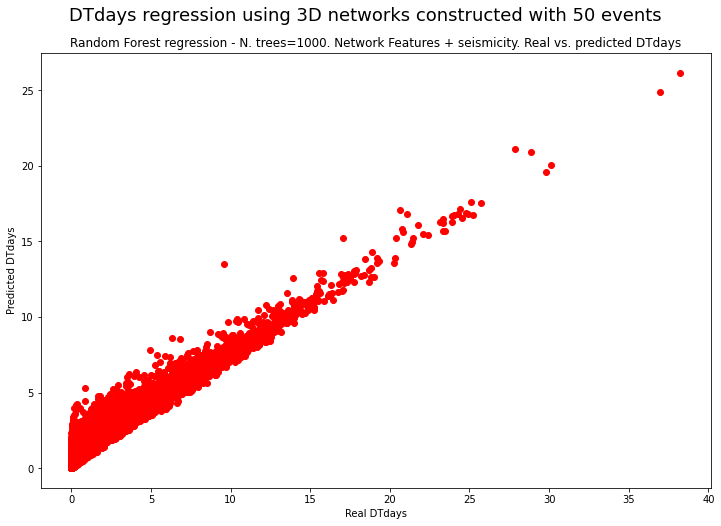

CPU times: user 50.2 s, sys: 213 ms, total: 50.4 s
Wall time: 50.3 s


In [58]:
%%time
import matplotlib.pyplot as plt
#Entrena modelo de regresión

nevs=50
#trgt="DTdays"
target="DTdays"


n1=nevs
idx="nev"+str(n1)
c=1000

#indice=idx+"-nsig"+str(sig)
y=dfvecsalidas[idx][target]
#y=dfvecsalidassigs[idx+"-nsig20"]
xmod=dfvecs3d[idx][0:len(y)]
xmod=xmod.drop(columns=["Unnamed: 0"])

regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
regressor.fit(xmod,y)
prediccion=regressor.predict(xmod)
            
fig=plt.figure(figsize=(12,8))
plt.plot(y, prediccion, 'or')
plt.suptitle(target+" regression using 3D networks constructed with "+str(n1)+" events",y=0.96,fontsize=18)
plt.title("Random Forest regression - N. trees="+str(c)+". Network Features + seismicity. Real vs. predicted "+target)
plt.xlabel("Real "+target)
plt.ylabel("Predicted "+target)
plt.show()

mae = mean_absolute_error(y, prediccion)
mse = mean_squared_error(y, prediccion)
r2 = r2_score(y, prediccion)
mape = mean_absolute_percentage_error(y, prediccion)
#metricasregresionrf.append(["RF","3d","inputfull",idx,target,c,mae,mse,mape,r2])


In [55]:
newcatalogo

time  latitude  longitude    depth  mag  \
0   2023-10-13 03:49:50.275000+00:00    6.8699   -73.1439  143.627  4.2   
1   2023-10-13 04:00:14.342000+00:00   -2.9014   -79.0940   85.441  4.5   
2   2023-10-19 05:39:29.493000+00:00    6.7914   -73.0949  157.651  4.2   
3   2023-10-21 23:39:00.250000+00:00    7.6175   -75.0255   59.032  4.5   
4   2023-10-25 22:59:33.974000+00:00    7.6827   -77.5009   25.845  4.4   
..                               ...       ...        ...      ...  ...   
158 2024-09-29 07:05:47.171000+00:00    6.7894   -73.1424  156.292  4.7   
159 2024-10-01 09:07:36.450000+00:00   -2.7017   -80.8537   35.000  4.5   
160 2024-10-01 09:17:15.681000+00:00   -2.6637   -80.9125   35.000  4.6   
161 2024-10-04 19:36:25.562000+00:00    6.8553   -73.1539  154.430  4.2   
162 2024-10-05 23:54:02.808000+00:00   -2.0657   -80.5293   35.000  4.2   

         epochs       energia  celda2d50  celda3d50  DTsegs    DTdays  \
0    1697168990  1.258925e+11        956    4159684       0  0.000000   
1    1697169614  3.548134e+11        151    2079515     624  0.007222   
2    1697693969  1.258925e+11        956    6239048  524355  6.068924   
3    1697931540  3.548134e+11       1024    2080388  237571  2.749664   
4    1698274773  2.511886e+11       1018       1018  343233  3.972604   
..          ...           ...        ...        ...     ...       ...   
158  1727593547  7.079458e+11        956    6239048   42818  0.495579   
159  1727773656  3.548134e+11        183        183  180109  2.084595   
160  1727774235  5.011872e+11        183        183     579  0.006701   
161  1728070585  1.258925e+11        956    6239048  296350  3.429977   
162  1728172442  1.258925e+11        220        220  101857  1.178900   

     energialog  
0     25.558695  
1     26.594858  
2     25.558695  
3     26.594858  
4     26.249470  
..          ...  
158   27.285633  
159   26.594858  
160   26.940246  
161   25.558695  
162   25.558695  

[163 rows x 12 columns]

In [24]:
%%time

newcatalogo=pd.read_csv("/data/doctorado/redessismos/catalogo-2023-2024.csv", parse_dates=["time"])
#newcatalogo.sort_values('time')
newcatalogo.sort_values(by='time', inplace = True) 
newcatalogo=newcatalogo[['time', 'latitude', 'longitude', 'depth', 'mag']]
tini=(pd.Timestamp("1973-01-01T00:00:00Z")-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')
newcatalogo["epochs"]=(newcatalogo["time"]-pd.Timestamp("1970-01-01T00:00:00Z"))//pd.Timedelta('1s')
newcatalogo.insert(len(newcatalogo.columns),"energia",[math.pow(10,4.8+1.5*lin) for lin in newcatalogo["mag"]])
cp2dnew=[]
cp3dnew=[]
for i, lin in newcatalogo.iterrows():
    cp2dnew.append(calculacelda2D(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"]))
    cp3dnew.append(calculacelda3D(ltmin,lnmin,tcel,gr2km,ancho,largo,lin["latitude"],lin["longitude"],lin["depth"]))

newcatalogo.insert(len(newcatalogo.columns),"celda2d"+str(tcel),cp2dnew)
newcatalogo.insert(len(newcatalogo.columns),"celda3d"+str(tcel),cp3dnew)
newcatalogo=newcatalogo.reset_index().drop(columns=["index"])
losepochsnew=newcatalogo.epochs.values
stiemposnew=[]
#dtiempos.append(0)
stiemposnew.append(0)


for t in range(len(losepochsnew)-1):
    t1=losepochsnew[t+1]-losepochsnew[t]
    #dtiempos.append(t1/(60*60*24))
    stiemposnew.append(t1)
    #ti=tiempos
newcatalogo.insert(len(newcatalogo.columns),"DTsegs",stiemposnew)
newcatalogo["DTdays"]=newcatalogo["DTsegs"]/(60*60*24)
newcatalogo["energialog"]=np.log(newcatalogo.energia)


CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 26.4 ms


In [26]:
lnsiguientes

[10, 20]

In [27]:
%%time

#newvsalidassigs={}
nsiguientes=20
neventos=50

newtammuestrassiguientes=len(newcatalogo)-neventos-nsiguientes-1
print(neventos,nsiguientes,len(newcatalogo),newtammuestrassiguientes)
newvecsalidassiguientes=[]

for i in range(newtammuestrassiguientes):
    posmuestra=i+neventos
    energia=newcatalogo.energia[posmuestra:posmuestra+nsiguientes].sum()
    tini=newcatalogo.epochs.values[i+neventos]
    tfin=newcatalogo.epochs.values[i+neventos+nsiguientes-1]
    #sismicidad de siguientes nsiguientes eventos
    sismi=np.log(energia/(tfin-tini))
    newvecsalidassiguientes.append(sismi)
#newvsalidassigs["nev"+str(neventos)+"-nsig"+str(nsiguientes)]=newvecsalidassiguientes

newdfvecsalidassigs=pd.DataFrame(newvecsalidassiguientes,columns=["sismicidad"])

#for k, vecs in newvsalidassigs.items():
#    newdfvecsalidassigs[k]=pd.DataFrame(vecs,columns=["sismicidad"])


50 20 163 92
CPU times: user 30.9 ms, sys: 0 ns, total: 30.9 ms
Wall time: 30.2 ms


In [40]:
len(sismicidad)

42

In [59]:
%%time

nmuestras=100

vectores=[]
for i in range(nmuestras):
    vectores.append(creavector(newcatalogo,"celda3d50",i,50))

dfvectores=pd.DataFrame(vectores,columns=["nodos","edges","grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"])
dias=newcatalogo["DTdays"].values[50:50+nmuestras]
#sismicidad=newdfvecsalidassigs.values[50:50+nmuestras]
#mag=newcatalogo["mag"].values[50:50+nmuestras]
preddias=regressor.predict(dfvectores)
#predsismicidad=regressor.predict(dfvectores[0:len(sismicidad)])
#predmag=regressor.predict(dfvectores)



CPU times: user 1.51 s, sys: 4 ms, total: 1.51 s
Wall time: 1.52 s


In [52]:
len(predmag)

100

In [39]:
len(predsismicidad)

50

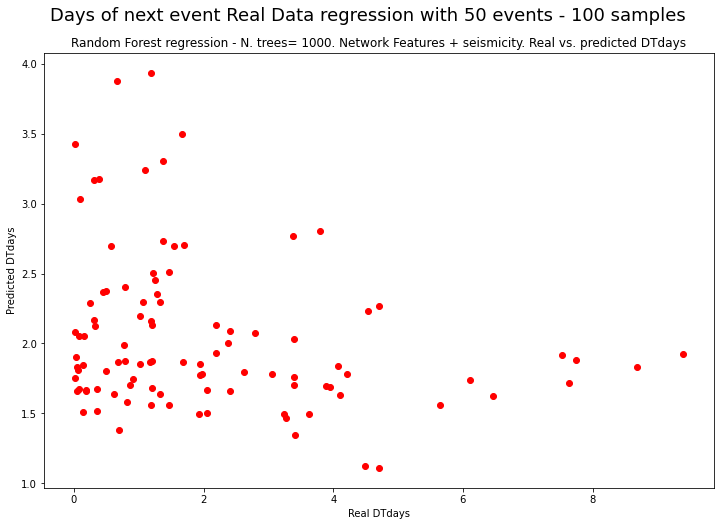

In [65]:

fig=plt.figure(figsize=(12,8))
plt.plot(dias, preddias, 'or')
#plt.plot(sismicidad, predsismicidad, 'or')
#plt.plot(mag, predmag, 'or')
#plt.suptitle("20 events seismicity regression constructed with 50 events - 50 samples",y=0.96,fontsize=18)
#plt.suptitle("Magnitude Real Data regression with 50 events - "+str(nmuestras)+" samples",y=0.96,fontsize=18)
plt.suptitle("Days of next event Real Data regression with 50 events - "+str(nmuestras)+" samples",y=0.96,fontsize=18)
plt.title("Random Forest regression - N. trees= 1000. Network Features + seismicity. Real vs. predicted "+target)
plt.xlabel("Real "+target)
plt.ylabel("Predicted "+target)
#plt.savefig("mag-RF-C1000-"+idx+"-sig"+str(sig)+".svg",format="svg")
plt.savefig("realseimicity-RF-C1000-"+idx+"-sig"+str(sig)+".svg",format="svg")
#plt.savefig("realdays-RF-C1000-"+idx+"-sig"+str(sig)+".svg",format="svg")
plt.show()
#



In [ ]:




tinis=catalogo.epochs.values[i]
        tfins=catalogo.epochs.values[i+neventos]
        dtdias=(tfins-tinis)/(60*60*24)
        #dtdias=dtsegs

        sismicidad=energia/dtdias
        lsismicidad=np.log(sismicidad)
        veccaracs2d.append([nodostemp2d,nedgestemp2d,gradstemp2d,clusttemp2d,pathstemp2d,enttemp2d,smallworldtemp2d,mbetweentemp2d,lenergia,dtdias,lsismicidad])
        veccaracs3d.append([nodostemp3d,nedgestemp3d,gradstemp3d,clusttemp3d,pathstemp3d,enttemp3d,smallworldtemp3d,mbetweentemp3d,lenergia,dtdias,lsismicidad])
    
    print("termina neventos ",neventos," - len dfbordes2d: ",len(dfbordes2d)," - len nodedatas2d: ",len(node_datas2d))
    
    grafosstellars2d=[]
    for i in range(len(dfbordes2d)):
        dfbordes2d[i].columns=["source","target"]
        grafosstellars2d.append(StellarGraph(node_datas2d[i],dfbordes2d[i]))
    grafosstellars3d=[]
    for i in range(len(dfbordes3d)):
        dfbordes3d[i].columns=["source","target"]
        grafosstellars3d.append(StellarGraph(node_datas3d[i],dfbordes3d[i]))

    grafosstellars2dall['nev'+str(neventos)]=grafosstellars2d
    grafosstellars3dall['nev'+str(neventos)]=grafosstellars3d

    redes2d['nev'+str(neventos)]=redesnx2d
    redes3d['nev'+str(neventos)]=redesnx3d

    dfvecs2d['nev'+str(neventos)]=pd.DataFrame(veccaracs2d,columns=["nodos","edges","grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"])
    dfvecs3d['nev'+str(neventos)]=pd.DataFrame(veccaracs3d,columns=["nodos","edges","grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"])



CPU times: user 127 ms, sys: 7.75 ms, total: 134 ms
Wall time: 346 ms


In [ ]:
dfvecresultados

In [12]:
newcatalogo[:50]

time  latitude  longitude    depth  mag  \
162 2023-10-13 03:49:50.275000+00:00    6.8699   -73.1439  143.627  4.2   
161 2023-10-13 04:00:14.342000+00:00   -2.9014   -79.0940   85.441  4.5   
160 2023-10-19 05:39:29.493000+00:00    6.7914   -73.0949  157.651  4.2   
159 2023-10-21 23:39:00.250000+00:00    7.6175   -75.0255   59.032  4.5   
158 2023-10-25 22:59:33.974000+00:00    7.6827   -77.5009   25.845  4.4   
157 2023-10-29 21:34:37.065000+00:00    6.8086   -73.0954  156.550  4.3   
156 2023-10-30 11:44:01.671000+00:00    6.7196   -72.9917  160.352  4.4   
155 2023-10-31 09:52:02.489000+00:00    4.4451   -76.2619  141.956  4.2   
154 2023-11-04 11:00:36.531000+00:00    6.7014   -73.0657  159.015  4.6   
153 2023-11-06 05:18:37.567000+00:00   -4.0832   -76.7297   10.000  4.1   
152 2023-11-06 20:58:32.027000+00:00    4.3276   -76.4337   85.061  4.3   
151 2023-11-07 03:33:46.457000+00:00   -0.9016   -79.2503   25.049  5.0   
150 2023-11-08 15:56:18.308000+00:00    7.0146   -73.3307  129.259  4.3   
149 2023-11-09 02:01:27.144000+00:00   11.6278   -70.3050   21.831  4.1   
148 2023-11-10 07:48:04.471000+00:00    4.3431   -73.4809   10.000  4.5   
147 2023-11-12 08:26:50.690000+00:00   -2.5189   -80.6013   37.932  4.5   
146 2023-11-15 12:20:41.563000+00:00   -2.4599   -79.4749   21.974  4.5   
145 2023-11-18 06:35:49.868000+00:00   -1.2383   -77.7529  189.021  4.7   
144 2023-11-18 23:32:53.076000+00:00    2.5126   -79.7082   10.000  4.5   
143 2023-11-22 17:45:03.578000+00:00   -2.2421   -77.1393   12.773  4.7   
142 2023-11-24 03:43:52.190000+00:00    6.8801   -73.1356  148.794  4.4   
141 2023-11-25 12:22:13.153000+00:00    7.3360   -79.8068   10.000  4.9   
140 2023-11-25 12:59:52.776000+00:00   -2.0798   -77.2810  155.521  5.1   
139 2023-11-26 14:30:56.609000+00:00    4.2967   -76.0903  145.003  4.2   
138 2023-11-28 12:42:48.892000+00:00   -2.2069   -77.0449  131.340  4.3   
137 2023-12-01 03:54:29.830000+00:00    7.4310   -80.4933   10.000  4.4   
136 2023-12-11 07:36:33.539000+00:00    0.9582   -77.5751   95.262  4.6   
135 2023-12-15 17:15:20.370000+00:00    9.0844   -75.2416   37.850  4.5   
134 2023-12-15 20:24:22.404000+00:00    7.2102   -76.2392   46.554  4.4   
133 2023-12-17 03:16:46.063000+00:00    6.8023   -73.0045  154.824  4.5   
132 2023-12-26 16:11:31.567000+00:00   10.9150   -70.5127   25.954  4.5   
131 2023-12-28 06:51:58.594000+00:00   10.9242   -70.4900   17.868  4.4   
130 2023-12-28 22:44:58.620000+00:00   -1.7562   -78.0928  164.910  4.2   
129 2024-01-06 01:03:31.563000+00:00   -1.3156   -81.0475   10.000  4.5   
128 2024-01-06 11:51:34.489000+00:00   -2.2219   -79.7851   83.278  4.4   
127 2024-01-08 12:59:52.208000+00:00   -2.4091   -81.9572   10.000  4.6   
126 2024-01-08 13:06:56.285000+00:00   -2.5314   -81.8388   10.000  4.6   
125 2024-01-15 11:23:19.711000+00:00    6.8935   -73.1499  151.315  4.3   
124 2024-01-16 10:35:22.056000+00:00    7.1797   -79.7804   10.000  4.4   
123 2024-01-19 11:26:03.598000+00:00    4.7429   -75.8481   65.067  5.6   
122 2024-01-19 11:47:28.023000+00:00    4.8447   -75.9969   76.307  4.3   
121 2024-01-21 17:19:48.289000+00:00    6.7852   -73.0286  154.112  5.0   
120 2024-01-22 19:05:50.061000+00:00    6.8566   -73.0861  152.431  4.7   
119 2024-01-24 01:42:11.505000+00:00   -3.1744   -77.6843   10.000  4.5   
118 2024-01-25 09:41:10.327000+00:00    9.3386   -70.3853   10.000  4.4   
117 2024-01-28 05:19:05.061000+00:00   -3.8201   -80.3235   35.382  4.4   
116 2024-01-28 06:10:38.878000+00:00    5.7787   -77.7520   17.402  4.4   
115 2024-01-28 08:17:55.788000+00:00    6.2056   -77.5807   21.804  4.5   
114 2024-02-04 13:04:08.095000+00:00    6.8770   -73.0575  151.984  4.1   
113 2024-02-06 13:37:32.568000+00:00    7.3280   -80.5906   16.804  4.8   

         epochs       energia  celda2d50  celda3d50  DTsegs     DTdays  \
162  1697168990  1.258925e+11        956    4159684       0   0.000000   
161  1697169614  3.548134e+11        151    2079515     62

In [20]:
newcatalogo["DTdays"].values[50]

1.5407407407407407

In [21]:
dfvecresultadosnew.columns

Index(['neventos', 'tiempo', 'dtsegs', 'energias', 'dtdias', 'sismicidad',
       'sismicidadlog'],
      dtype='object')

In [15]:
dfvecresultadosnew["dtdias"].values[50]

20.186840277777776

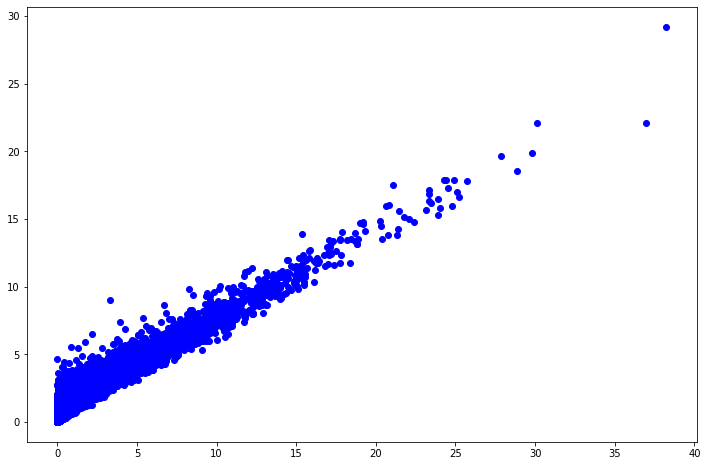

CPU times: user 5.99 s, sys: 140 ms, total: 6.13 s
Wall time: 5.85 s


In [40]:
%%time

metricasregresionsvr=[]

#for idx in ["nev10","nev50","nev100"]:
for idx in ["nev50"]:
    for target in ["DTdays"]: #,"mag"]:
        for c in [100]: #,1000]:

            #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
            xmod=dfvecs2d[idx]

            #regressor = SVR(kernel='rbf',C=c)
            regressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
            y=dfvecsalidas[idx][target]
            regressor.fit(xmod,y)
            prediccion=regressor.predict(xmod)

            #fig=plt.figure(figsize=(12,8))
            #plt.plot(dfvecsalidas[idx][target], color = 'green')
            #plt.plot(prediccion, color = 'blue')
            #plt.title(idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))

            mae = mean_absolute_error(y, prediccion)
            mse = mean_squared_error(y, prediccion)
            r2 = r2_score(y, prediccion)
            mape = mean_absolute_percentage_error(y, prediccion)
            metricasregresionsvr.append(["SVR","2d","inputfull",idx,target,c,mae,mse,mape,r2])
            
            plt.figure(figsize=(12,8))
            plt.plot(y,prediccion,'bo')
            plt.title()
            plt.show()

In [ ]:
%%time

#Support Vector Regression

metricasregresionsigsvr=[]

for idx in ["nev10","nev50","nev100"]:
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs2d[idx][0:len(y)]

                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(xmod,y)
                prediccion=regressor.predict(xmod)

                #fig=plt.figure(figsize=(12,8))
                #plt.plot(dfvecsalidas[idx][target], color = 'green')
                #plt.plot(prediccion, color = 'blue')
                #plt.title(idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))

                mae = mean_absolute_error(y, prediccion)
                mse = mean_squared_error(y, prediccion)
                r2 = r2_score(y, prediccion)
                mape = mean_absolute_percentage_error(y, prediccion)
                metricasregresionsigsvr.append(["SVR","2d","inputfull",idx,sig,target,c,mae,mse,mape,r2])

for idx in ["nev10","nev50","nev100"]:
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs2d[idx][0:len(y)].drop(columns=["energia","dtdias","sismicidad"])

                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(xmod,y)
                prediccion=regressor.predict(xmod)

                #fig=plt.figure(figsize=(12,8))
                #plt.plot(dfvecsalidas[idx][target], color = 'green')
                #plt.plot(prediccion, color = 'blue')
                #plt.title(idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))

                mae = mean_absolute_error(y, prediccion)
                mse = mean_squared_error(y, prediccion)
                r2 = r2_score(y, prediccion)
                mape = mean_absolute_percentage_error(y, prediccion)
                metricasregresionsigsvr.append(["SVR","2d","inputmod",idx,sig,target,c,mae,mse,mape,r2])


for idx in ["nev10","nev50","nev100"]:
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs3d[idx][0:len(y)]

                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(xmod,y)
                prediccion=regressor.predict(xmod)

                #fig=plt.figure(figsize=(12,8))
                #plt.plot(dfvecsalidas[idx][target], color = 'green')
                #plt.plot(prediccion, color = 'blue')
                #plt.title(idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))

                mae = mean_absolute_error(y, prediccion)
                mse = mean_squared_error(y, prediccion)
                r2 = r2_score(y, prediccion)
                mape = mean_absolute_percentage_error(y, prediccion)
                metricasregresionsigsvr.append(["SVR","3d","inputfull",idx,sig,target,c,mae,mse,mape,r2])

for idx in ["nev10","nev50","nev100"]:
    for sig in lnsiguientes:
        for target in ["sismicidad"]:
            for c in [100,1000]:

                #xmod=dfvecs2d[idx].drop(columns=["energia","dtdias","sismicidad"])
                indice=idx+"-nsig"+str(sig)
                y=dfvecsalidassigs[indice][target]
                xmod=dfvecs3d[idx][0:len(y)].drop(columns=["energia","dtdias","sismicidad"])

                regressor = SVR(kernel='rbf',C=c)
                regressor.fit(xmod,y)
                prediccion=regressor.predict(xmod)

                #fig=plt.figure(figsize=(12,8))
                #plt.plot(dfvecsalidas[idx][target], color = 'green')
                #plt.plot(prediccion, color = 'blue')
                #plt.title(idx+" 2D network features + seismicity - Output vs prediction - "+target+" - SVR regression C="+str(c))

                mae = mean_absolute_error(y, prediccion)
                mse = mean_squared_error(y, prediccion)
                r2 = r2_score(y, prediccion)
                mape = mean_absolute_percentage_error(y, prediccion)
                metricasregresionsigsvr.append(["SVR","3d","inputmod",idx,sig,target,c,mae,mse,mape,r2])


dfmetricasregresionsigsvr=pd.DataFrame(metricasregresionsigsvr,columns=["Algorithm","NetworkType","InputType","Nevs","Nsigs","Target","Cost","MAE","MSE","MAPE","R2"])
dfmetricasregresionsigsvr.to_csv("dfmetricasregresionsigsvr.csv")

## LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


totalsize=len(dfvecsalidas["nev50"]["DTdays"].values)
data=dfvecs3d["nev50"][["grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"]]
train_size = int(totalsize * 0.67)
test_size = totalsize - train_size
train, test = data[0:train_size], data[train_size:len(data)]
print(len(train), len(test))

X=data.values
y=dfvecsalidas["nev50"]["DTdays"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

model = Sequential()
#model.add(LSTM(50, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(LSTM(10, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_scaled, y_scaled, epochs=200, batch_size=32, validation_split=0.2)

y_pred_scaled = model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print(r2_score(y_scaled, y_pred_scaled))

import matplotlib.pyplot as plt

plt.figure(figsize=(50, 8))  # Optional: Set the figure size
plt.plot(y, label='Data val', color='blue', marker='o')
plt.plot(scaler_y.inverse_transform(y_pred_scaled), label='predicciones', color='red', marker='o')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Example Plot')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
data=dfvecs3d["nev50"][["grad","clus","path","ent","sw","bet","energia","dtdias","sismicidad"]]
#data = dfvecs3d["nev50"]

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Example: Your data as a NumPy array
#data = dfvecs3d["nev50"].values.reshape(len(dfvecs2d["nev50"]),len(dfvecs2d["nev50"].columns))
#np.random.random((6211, 11))  # Replace with your actual dataset
targets = dfvecsalidas["nev50"]["DTdays"].values.reshape(len(dfvecs2d["nev50"]),1)
#np.random.random(6211)    # Replace with your actual targets

# Normalize input features
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Reshape for LSTM: (samples, timesteps, features)
data_reshaped = np.expand_dims(data_normalized, axis=1)  # Adding a "timesteps" dimension


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#keras.backend.clear_session()

# Define the LSTM model
model = Sequential([
    LSTM(16,  activation='tanh', input_shape=(len(data.columns),1)),  # (timesteps, features)
    Dense(32, activation='sigmoid'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print summary
model.summary()


In [ ]:
data_reshaped=data_reshaped.reshape(len(data),len(data.columns),1)
#targets=targets.reshape(len(data))

model.fit(data_reshaped,targets)

In [ ]:
predictions = model.predict(data_reshaped)

print(r2_score(targets, predictions))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Optional: Set the figure size
plt.plot(targets, label='Data val', color='blue', marker='o')
plt.plot(predictions, label='predicciones', color='red', marker='o')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Example Plot')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [ ]:

c=100
rfregressor = RandomForestRegressor(n_estimators=c,oob_score=True,random_state=42)
rfregressor.fit(data_normalized,targets)
rfprediccion=rfregressor.predict(data_normalized)
rfr2 = r2_score(targets, rfprediccion)
print(rfr2)

#import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Optional: Set the figure size
plt.plot(targets, label='Data val', color='blue', marker='o')
plt.plot(rfprediccion, label='predicciones', color='red', marker='o')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Example Plot')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(data_reshaped, targets, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


In [ ]:
# Evaluate
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation MAE: {mae}")

# Predict
predictions = model.predict(X_val)


In [ ]:
#mean_absolute_error(y_val, predictions)
#mean_squared_error(y_val, predictions)
r2_score(y_val, predictions)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.plot(targets, label='Data val', color='blue', marker='o')
plt.plot(predictions, label='predicciones', color='red', marker='o')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Example Plot')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

modellstm = Sequential([
    LSTM(units=64, input_shape=(11, 1)),  # Adjust units as needed
    Dense(1)
])


modellstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
X=dfvecs2d["nev50"].values

In [ ]:
X=X.reshape(6211,11,1)

In [ ]:
y=dfvecsalidas["nev50"]["DTdays"].values.reshape(6211,1)

In [ ]:
modellstm.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
dfvecs2d["nev50"].head()

In [ ]:
dfvecsalidas["nev10"].head()

# Regresión
